<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/Pix2Struct/Fine_tune_Pix2Struct_on_key_value_pair_dataset_(PyTorch_Lightning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune Pix2Struct on a key-value pair dataset

In this notebook, we'll fine-tune Google's [Pix2Struct](https://huggingface.co/docs/transformers/main/en/model_doc/pix2struct) model on the [CORD dataset](https://huggingface.co/datasets/naver-clova-ix/cord-v2), in the format in which the Donut authors (Donut is a model very similar to Pix2Struct in terms of architecture) prepared it. See also my [notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Donut/DocVQA/Creating_a_toy_DocVQA_dataset_for_Donut.ipynb) regarding preparing a custom dataset in this format.

The goal for the model is to predict a piece of text given a document image.

## Set-up environment

We start by installing 🤗 Transformers and 🤗 Datasets.

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 26.1 MB/s eta 0:00:00


In [ ]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 33.6 MB/s eta 0:00:00


We'll also install PyTorch Lightning and Weights and Biases, as those are the tools we'll use for training.

In [ ]:
!pip install -q lightning wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.4/716.4 KB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 546.0/546.0 KB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Load dataset

Let's load the dataset from the [hub](https://huggingface.co/datasets/naver-clova-ix/cord-v2).

In [ ]:
from datasets import load_dataset

dataset = load_dataset("naver-clova-ix/cord-v2")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/naver-clova-ix___parquet/naver-clova-ix--cord-v2-c97f979311033a44/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

The dataset consists of 3 splits as can be seen: train, validation and test. Each example consists of an "image" and a "ground_truth" string.

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 800
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
})

Let's check and visualize the first training example:

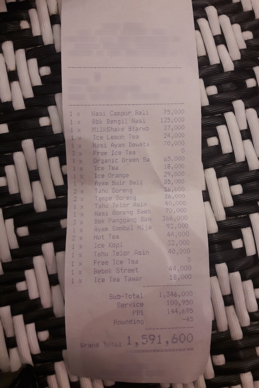

In [ ]:
example = dataset['train'][0]
image = example['image']
# let's make the image a bit smaller when visualizing
width, height = image.size
display(image.resize((int(width*0.3), int(height*0.3))))

In [ ]:
# let's load the corresponding JSON dictionary (as string representation)
ground_truth = example['ground_truth']
print(ground_truth)

{"gt_parse": {"menu": [{"nm": "Nasi Campur Bali", "cnt": "1 x", "price": "75,000"}, {"nm": "Bbk Bengil Nasi", "cnt": "1 x", "price": "125,000"}, {"nm": "MilkShake Starwb", "cnt": "1 x", "price": "37,000"}, {"nm": "Ice Lemon Tea", "cnt": "1 x", "price": "24,000"}, {"nm": "Nasi Ayam Dewata", "cnt": "1 x", "price": "70,000"}, {"nm": "Free Ice Tea", "cnt": "3 x", "price": "0"}, {"nm": "Organic Green Sa", "cnt": "1 x", "price": "65,000"}, {"nm": "Ice Tea", "cnt": "1 x", "price": "18,000"}, {"nm": "Ice Orange", "cnt": "1 x", "price": "29,000"}, {"nm": "Ayam Suir Bali", "cnt": "1 x", "price": "85,000"}, {"nm": "Tahu Goreng", "cnt": "2 x", "price": "36,000"}, {"nm": "Tempe Goreng", "cnt": "2 x", "price": "36,000"}, {"nm": "Tahu Telor Asin", "cnt": "1 x", "price": "40,000."}, {"nm": "Nasi Goreng Samb", "cnt": "1 x", "price": "70,000"}, {"nm": "Bbk Panggang Sam", "cnt": "3 x", "price": "366,000"}, {"nm": "Ayam Sambal Hija", "cnt": "1 x", "price": "92,000"}, {"nm": "Hot Tea", "cnt": "2 x", "price

Using Python's `literal_eval` function, you can turn it into an actual Python dictionary:

In [ ]:
from ast import literal_eval

literal_eval(ground_truth)['gt_parse']

{'menu': [{'nm': 'Nasi Campur Bali', 'cnt': '1 x', 'price': '75,000'},
  {'nm': 'Bbk Bengil Nasi', 'cnt': '1 x', 'price': '125,000'},
  {'nm': 'MilkShake Starwb', 'cnt': '1 x', 'price': '37,000'},
  {'nm': 'Ice Lemon Tea', 'cnt': '1 x', 'price': '24,000'},
  {'nm': 'Nasi Ayam Dewata', 'cnt': '1 x', 'price': '70,000'},
  {'nm': 'Free Ice Tea', 'cnt': '3 x', 'price': '0'},
  {'nm': 'Organic Green Sa', 'cnt': '1 x', 'price': '65,000'},
  {'nm': 'Ice Tea', 'cnt': '1 x', 'price': '18,000'},
  {'nm': 'Ice Orange', 'cnt': '1 x', 'price': '29,000'},
  {'nm': 'Ayam Suir Bali', 'cnt': '1 x', 'price': '85,000'},
  {'nm': 'Tahu Goreng', 'cnt': '2 x', 'price': '36,000'},
  {'nm': 'Tempe Goreng', 'cnt': '2 x', 'price': '36,000'},
  {'nm': 'Tahu Telor Asin', 'cnt': '1 x', 'price': '40,000.'},
  {'nm': 'Nasi Goreng Samb', 'cnt': '1 x', 'price': '70,000'},
  {'nm': 'Bbk Panggang Sam', 'cnt': '3 x', 'price': '366,000'},
  {'nm': 'Ayam Sambal Hija', 'cnt': '1 x', 'price': '92,000'},
  {'nm': 'Hot Tea', '

## Load model and processor

Next, let's load the model and its processor from the [hub](https://huggingface.co/models?other=pix2struct). Here we just use the pre-trained only, base-sized model, but note that there are 20 different checkpoints released on the hub.

In [ ]:
from transformers import Pix2StructForConditionalGeneration, AutoProcessor

repo_id = "google/pix2struct-base"

processor = AutoProcessor.from_pretrained(repo_id)
model = Pix2StructForConditionalGeneration.from_pretrained(repo_id)

## Create PyTorch dataset

We create a regular PyTorch Dataset class which returns examples of the data, prepared for the model.

In [ ]:
import json
import random
from typing import Any, List
from torch.utils.data import Dataset

added_tokens = []

class ImageCaptioningDataset(Dataset):
    def __init__(
        self,
        dataset_name_or_path: str,
        max_patches: int = 1024,
        max_length: int = 512,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.split = split
        self.dataset = load_dataset(dataset_name_or_path, split=self.split)
        self.max_patches = max_patches
        self.max_length = max_length
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key

        self.gt_token_sequences = []
        for ground_truth in self.dataset["ground_truth"]:
            ground_truth = json.loads(ground_truth)
            if "gt_parses" in ground_truth:  # when multiple ground truths are available, e.g., docvqa
                assert isinstance(ground_truth["gt_parses"], list)
                gt_jsons = ground_truth["gt_parses"]
            else:
                assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
                gt_jsons = [ground_truth["gt_parse"]]

            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        update_special_tokens_for_json_key=self.split == "train",
                        sort_json_key=self.sort_json_key,
                    )
                    for gt_json in gt_jsons  # load json from list of json
                ]
            )

        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"<s_{k}>", fr"</s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in added_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj
    
    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add special tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))
            added_tokens.extend(list_of_tokens)
    
    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        # prepare inputs
        encoding = processor(images=item["image"], max_patches=self.max_patches, return_tensors="pt")
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        
        # prepare targets
        target_sequence = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1
        input_ids = processor.tokenizer(
            target_sequence,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        ).input_ids

        labels = input_ids.squeeze().clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.ignore_id  # model doesn't need to predict pad token
        encoding["labels"] = labels
        # labels[: torch.nonzero(labels == self.prompt_end_token_id).sum() + 1] = self.ignore_id  # model doesn't need to predict prompt (for VQA)
        return encoding, target_sequence

In [ ]:
train_dataset = ImageCaptioningDataset("naver-clova-ix/cord-v2",
                                       split="train", sort_json_key=False) # cord dataset is preprocessed, so no need for this
val_dataset = ImageCaptioningDataset("naver-clova-ix/cord-v2",
                                       split="validation", sort_json_key=False) # cord dataset is preprocessed, so no need for this

In [ ]:
encoding, target_sequence = train_dataset[0]
print(encoding.keys())

dict_keys(['flattened_patches', 'attention_mask', 'labels'])


In [ ]:
print(processor.decode([id.item() for id in encoding["labels"] if id != -100]))

<s_menu><s_nm> Nasi Campur Bali</s_nm><s_cnt> 1 x</s_cnt><s_price> 75,000</s_price> <sep/><s_nm> Bbk Bengil Nasi</s_nm><s_cnt> 1 x</s_cnt><s_price> 125,000</s_price> <sep/><s_nm> MilkShake Starwb</s_nm><s_cnt> 1 x</s_cnt><s_price> 37,000</s_price> <sep/><s_nm> Ice Lemon Tea</s_nm><s_cnt> 1 x</s_cnt><s_price> 24,000</s_price> <sep/><s_nm> Nasi Ayam Dewata</s_nm><s_cnt> 1 x</s_cnt><s_price> 70,000</s_price> <sep/><s_nm> Free Ice Tea</s_nm><s_cnt> 3 x</s_cnt><s_price> 0</s_price> <sep/><s_nm> Organic Green Sa</s_nm><s_cnt> 1 x</s_cnt><s_price> 65,000</s_price> <sep/><s_nm> Ice Tea</s_nm><s_cnt> 1 x</s_cnt><s_price> 18,000</s_price> <sep/><s_nm> Ice Orange</s_nm><s_cnt> 1 x</s_cnt><s_price> 29,000</s_price> <sep/><s_nm> Ayam Suir Bali</s_nm><s_cnt> 1 x</s_cnt><s_price> 85,000</s_price> <sep/><s_nm> Tahu Goreng</s_nm><s_cnt> 2 x</s_cnt><s_price> 36,000</s_price> <sep/><s_nm> Tempe Goreng</s_nm><s_cnt> 2 x</s_cnt><s_price> 36,000</s_price> <sep/><s_nm> Tahu Telor Asin</s_nm><s_cnt> 1 x</s_cn

In [ ]:
print(target_sequence)

<s_menu><s_nm>Nasi Campur Bali</s_nm><s_cnt>1 x</s_cnt><s_price>75,000</s_price><sep/><s_nm>Bbk Bengil Nasi</s_nm><s_cnt>1 x</s_cnt><s_price>125,000</s_price><sep/><s_nm>MilkShake Starwb</s_nm><s_cnt>1 x</s_cnt><s_price>37,000</s_price><sep/><s_nm>Ice Lemon Tea</s_nm><s_cnt>1 x</s_cnt><s_price>24,000</s_price><sep/><s_nm>Nasi Ayam Dewata</s_nm><s_cnt>1 x</s_cnt><s_price>70,000</s_price><sep/><s_nm>Free Ice Tea</s_nm><s_cnt>3 x</s_cnt><s_price>0</s_price><sep/><s_nm>Organic Green Sa</s_nm><s_cnt>1 x</s_cnt><s_price>65,000</s_price><sep/><s_nm>Ice Tea</s_nm><s_cnt>1 x</s_cnt><s_price>18,000</s_price><sep/><s_nm>Ice Orange</s_nm><s_cnt>1 x</s_cnt><s_price>29,000</s_price><sep/><s_nm>Ayam Suir Bali</s_nm><s_cnt>1 x</s_cnt><s_price>85,000</s_price><sep/><s_nm>Tahu Goreng</s_nm><s_cnt>2 x</s_cnt><s_price>36,000</s_price><sep/><s_nm>Tempe Goreng</s_nm><s_cnt>2 x</s_cnt><s_price>36,000</s_price><sep/><s_nm>Tahu Telor Asin</s_nm><s_cnt>1 x</s_cnt><s_price>40,000.</s_price><sep/><s_nm>Nasi Goren

In [ ]:
print("Number of added tokens:", len(added_tokens))
print(added_tokens)

Number of added tokens: 54
['<s_menu>', '</s_menu>', '<s_nm>', '</s_nm>', '<s_cnt>', '</s_cnt>', '<s_price>', '</s_price>', '<s_sub_total>', '</s_sub_total>', '<s_subtotal_price>', '</s_subtotal_price>', '<s_service_price>', '</s_service_price>', '<s_tax_price>', '</s_tax_price>', '<s_etc>', '</s_etc>', '<s_total>', '</s_total>', '<s_total_price>', '</s_total_price>', '<s_sub>', '</s_sub>', '<s_cashprice>', '</s_cashprice>', '<s_changeprice>', '</s_changeprice>', '<s_menutype_cnt>', '</s_menutype_cnt>', '<s_menuqty_cnt>', '</s_menuqty_cnt>', '<s_discount_price>', '</s_discount_price>', '<s_unitprice>', '</s_unitprice>', '<s_total_etc>', '</s_total_etc>', '<s_creditcardprice>', '</s_creditcardprice>', '<s_num>', '</s_num>', '<s_discountprice>', '</s_discountprice>', '<s_emoneyprice>', '</s_emoneyprice>', '<s_void_menu>', '</s_void_menu>', '<s_othersvc_price>', '</s_othersvc_price>', '<s_vatyn>', '</s_vatyn>', '<s_itemsubtotal>', '</s_itemsubtotal>']


In [ ]:
len(processor.tokenizer)

50398

## Create PyTorch DataLoaders

Next, we create PyTorch DataLoader which allow us to get batches of the data.

In [ ]:
from torch.utils.data import DataLoader
import multiprocessing

num_cores = multiprocessing.cpu_count()

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=num_cores)
val_dataloader = DataLoader(val_dataset, batch_size=1, num_workers=num_cores)

In [ ]:
# get first batch
batch = next(iter(train_dataloader))
encoding, target_sequences = batch

In [ ]:
for k,v in encoding.items():
  print(k,v.shape)

flattened_patches torch.Size([1, 1024, 770])
attention_mask torch.Size([1, 1024])
labels torch.Size([1, 512])


In [ ]:
print(processor.batch_decode([id for id in encoding["labels"].squeeze().tolist() if id != -100]))

['<s_menu>', '<s_nm>', 'Nas', 'i', 'Camp', 'ur', 'B', 'ali', '</s_nm>', '<s_unitprice>', '', '5', '2', '.', '0', '0', '0', '</s_unitprice>', '<s_cnt>', '', '2', '</s_cnt>', '<s_price>', '', '1', '0', '4', '.', '0', '0', '0', '</s_price>', '<', 'sep', '/>', '<s_nm>', 'Sam', 'bal', 'Be', 'sar', '</s_nm>', '<s_unitprice>', '', '3', '2', '.', '0', '0', '0', '</s_unitprice>', '<s_cnt>', '', '1', '</s_cnt>', '<s_price>', '', '3', '2', '.', '0', '0', '0', '</s_price>', '<', 'sep', '/>', '<s_nm>', 'Sam', 'bal', 'Ke', 'cil', '</s_nm>', '<s_unitprice>', '', '7', '.', '0', '0', '0', '</s_unitprice>', '<s_cnt>', '', '1', '</s_cnt>', '<s_price>', '', '7', '.', '0', '0', '0', '</s_price>', '<', 'sep', '/>', '<s_nm>', 'Es', 'Te', 'h', 'Mani', 's', '</s_nm>', '<s_unitprice>', '', '7', '.', '0', '0', '0', '</s_unitprice>', '<s_cnt>', '', '2', '</s_cnt>', '<s_price>', '', '1', '4', '.', '0', '0', '0', '</s_price>', '<', 'sep', '/>', '<s_nm>', 'Kr', 'p', 'B', 'ang', 'ka', '/', 'Ba', 'wang', '</s_nm>', '<

## Define Lighting module

As we'll train the model using [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/), we define a so-called LightningModule, which is an `nn.Module` with additional functionality such that we don't need to take care of device placement etc.

In [ ]:
from pathlib import Path
import re
from nltk import edit_distance
import numpy as np

import torch

import pytorch_lightning as pl


class Pix2Struct(pl.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

    def training_step(self, batch, batch_idx):
        encoding, _ = batch
        
        outputs = self.model(**encoding)
        loss = outputs.loss
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):
        encoding, answers = batch
        flattened_patches, attention_mask = encoding["flattened_patches"], encoding["attention_mask"]
        batch_size = flattened_patches.shape[0]
        # we feed the prompt to the model
        decoder_input_ids = torch.full((batch_size, 1), self.model.config.text_config.decoder_start_token_id, device=self.device)
        
        outputs = self.model.generate(flattened_patches=flattened_patches,
                                      attention_mask=attention_mask,
                                      decoder_input_ids=decoder_input_ids,
                                      max_length=512,
                                      pad_token_id=self.processor.tokenizer.pad_token_id,
                                      eos_token_id=self.processor.tokenizer.eos_token_id,
                                      use_cache=True,
                                      num_beams=1,
                                      bad_words_ids=[[self.processor.tokenizer.unk_token_id]],
                                      return_dict_in_generate=True,)
    
        predictions = []
        for seq in self.processor.tokenizer.batch_decode(outputs.sequences):
            seq = seq.replace(self.processor.tokenizer.eos_token, "").replace(self.processor.tokenizer.pad_token, "")
            # seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
            predictions.append(seq)

        scores = []
        for pred, answer in zip(predictions, answers):
            # pred = re.sub(r"(?:(?<=>) | (?=", "", answer, count=1)
            answer = answer.replace(self.processor.tokenizer.eos_token, "")
            scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))

            if self.config.get("verbose", False) and len(scores) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")
                print(f" Normed ED: {scores[0]}")

        self.log("val_edit_distance", np.mean(scores))
        
        return scores

    def configure_optimizers(self):
        # you could also add a learning rate scheduler if you want
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config.get("lr"))
    
        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

## Train!

Next, we instantiate the model and define a PyTorch Lightning Trainer. We can specify all kinds of things, such as on which devices we'd like to train, whether to use gradient clipping, logging to Weights and Biases etc. Check the [docs](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.trainer.trainer.Trainer.html#lightning.pytorch.trainer.trainer.Trainer) for all arguments you can pass to the Trainer - there are a lot of them!

Note: the model seems to converge **much slower** than Donut on this dataset. This may be due to a domain shift: Pix2Struct has been pre-trained on web page images (by predicting HTML on masked image portions). I haven't played too much with hyperparameters, I'm using the Adam optimizer with learning rate 1e-5. For reference, the authors use the AdaFactor optimizer with weight decay rate of 1e-5, with a learning rate that starts with 0.001 and goes up linearly to 0.01 for 1K steps and then a cosine decay for the rest of the training.

If you find hyperparameters with great convergence, please share them by opening an issue on my [Transformers-Tutorials](https://github.com/NielsRogge/Transformers-Tutorials) repository.

In [ ]:
config = {"max_epochs":30,
          "lr":1e-5,
          "val_check_interval":0.2, # how many times we want to validate during an epoch
          "check_val_every_n_epoch":5,
          "gradient_clip_val":1.0,
          "warmup_steps": 300, # 800/8*30/10, 10%
          "accumulate_grad_batches": 8,
          "verbose": True,
          }

pl_module = Pix2Struct(config, processor, model)

In [ ]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback, EarlyStopping

wandb_logger = WandbLogger(project="Pix2Struct", name="demo-run-pix2struct")

trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        max_epochs=config.get("max_epochs"),
        # val_check_interval=config.get("val_check_interval"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"), # use gradient clipping
        accumulate_grad_batches=config.get("accumulate_grad_batches"), # use gradient accumulation
        logger=wandb_logger,
)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(pl_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                               | Params
-------------------------------------------------------------
0 | model | Pix2StructForConditionalGeneration | 282 M 
-------------------------------------------------------------
282 M     Trainable params
0         Non-trainable params
282 M     Total params
1,130.089 Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_othersvc_price></s_itemsubtotal><s_itemsubtotal><extra_id_89><extra_id_88></s_total_price><extra_id_25><extra_id_18><s_itemsubtotal></s_total_price></s_total_price><extra_id_38>t<s_itemsubtotal></s_num><s_itemsubtotal></s_num><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><extra_id_18><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal></s_total_price><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsubtotal><s_itemsub

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_changeprice> 1</s_cnt></s_total_price> 16,500</s_total_price> < 16,500</s_total_price> < 13,000</s_total_price> < 16,000</s_total_price> < 45,500</s_total_price> < 50,000 < < 4,500</s_total_price> <
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.6195965417867435


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> Kopi Susu Kolonei 1 1</s_total_price></s_total_price> 23,000</s_total_price></s_menu> 23,000</s_total_price></s_total_price> 50,000</s_total_price></s_total_price> 27,000</s_total_price></s_total_price> 44,000</s_total_price></s_total_price> 44,000</s_total_price></s_total_price> 44,000</s_total_price></s_total_price> 44,000</s_total_price></s_total_price> 44,000</s_total_price></s_total_price> 44,000</s_total_price></s_total_price> 44,000</s_total_price></s_total_price> 44,000</s_total_price></s_total_price> 44,000</s_total_price></s_total_price> 44,000</s_total_price></s_total_price> 44,000</s_total_price></s_total_price> 44,000</s_total_price></s_total_price> 44,000</s_total_price></s_total_price> 44,000</s_total_price></s_total_price> 44,000</s_total_price></s_total_price> 44,000</s_total_price></s_total_price> 44,000</s_total_price></s_total_price> 44,000</s_total_price></s_total_price> 44,000</s_total_price></s_total_price> 44,000</s_total_price></s_to

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_changeprice> 1</s_cnt></s_total_price> 20,000</s_total_price></s_menu> 20,000</s_total_price></s_menu> 20,000</s_total_price></s_menu> 50%</s_total_price> <18,181</s_total_price> <18,181</s_total_price> <18,181</s_total_price> <20,000</s_total_price> <20,000</s_total_price> <100,000</s_total_price> <80,000</s_total_price> <100,000</s_total_price> <100,000</s_total_price> <100,000</s_total_price> <100,000</s_total_price> <100,000</s_total_price> <100,000</s_total_price> <100,000</s_total_price> <100,000</s_total_price> <100,000</s_total_price> <100,000</s_total_price> <100,000</s_total_price> <100,000</s_total_price> <100,000</s_total_price> <100,000</s_total_price> <100,000</s_total_price> <100,000</s_total_price> <100,000</s_total_price> <100,000</s_total_price> <100,000</s_total_price> <100,000</s_total_price> <100,000</s_total_price> <100,000</s_total_price> <100,000</s_total_price> <100,000</s_total_price> <100,000</s_total_price> <100,000</s_total_price> <10

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> M-Caramol Black Tea #28,000</s_total_price></s_menu> 28,000</s_total_price></s_menu> 70%</s_total_price></s_menu> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price>
    Answer: <s_menu><s_nm>M-Caramel Black Tea</s_nm><s_unitprice>@28,000</s_unitprice><s_cnt>1X</s_cnt><s_price>28,000</s_price><s_sub><s_nm>70%</s_nm><sep/><s_nm>Less Ice</s_nm></s_sub></s_menu><s_sub_total><s_subtotal_price>28,000</s_subtotal_price><s_tax_price>0</s_tax_price></s_sub_total><s_total><s_total_price>28,000</s_total_price><s_cashprice>28,000</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.5223880597014925


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 1</s_cnt></s_total_price> 41,000</s_total_price></s_menu> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_pric

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> 1.000</s_total_price></s_menu> 7.273</s_total_price> < 7.273</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000</s_total_price> < 8.000

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt></s_price> POTATO SAUAGE BREAD</s_total_price> 19,000</s_total_price> <sep/><s_nm> OREO GREEN TEA SPREAD</s_menu> 123,000 <sep/> <1 WHITE CHOCO BANANA SPREAD</s_menu> 123,000 <sep/>
    Answer: <s_menu><s_nm>POTATO SAUSAGE BREAD</s_nm><s_cnt>1</s_cnt><s_price>19,000</s_price><sep/><s_nm>OREO GREEN TEA SPREAD</s_nm><s_cnt>1</s_cnt><s_price>52,000</s_price><sep/><s_nm>WHITE CHOCO BANANA SPREAD</s_nm><s_cnt>1</s_cnt><s_price>52,000</s_price></s_menu><s_total><s_total_price>123,000</s_total_price><s_creditcardprice>123,000</s_creditcardprice></s_total>
 Normed ED: 0.6194444444444445


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> Choco Devil</s_total_price></s_total_price> 4</s_cnt></s_total_price> 63,636</s_total_price></s_total_price> 63,636</s_total_price> <sep/><s_nm> CP 320 Club Card</s_total_price> <sep/><s_nm> CP 320 Club Card</s_total_price> <sep/><s_nm> CP 320 Club Card</s_total_price> <sep/><s_nm> CP 320 Club Card</s_total_price> <sep/><s_nm> CP 320 Club Card</s_total_price> <sep/><s_nm> CP 320 Club Card</s_total_price> <sep/><s_nm> CP 320 Club Card</s_total_price> <sep/><s_nm> CP 320 Club Card</s_total_price> <sep/><s_nm> CP 320 Club Card</s_total_price> <sep/><s_nm> CP 320 Club Card</s_total_price> <sep/><s_nm> CP 320 Club Card</s_total_price> <sep/><s_nm> CP 320 Club Card</s_total_price> <sep/><s_nm> CP 320 Club Card <sep/><s_nm> CP 320 Club Card <sep/><s_nm> CP 320 Club Card <sep/><s_nm> CP 320 Club Card <sep/><s_nm> CP 320 Club Card <sep/><s_nm> CP 320 Club Card <sep/><s_nm> CP 320 Club Card <sep/><s_nm> CP 320 Club Card <sep/><s_nm> CP 320 Club Card <sep/><s_nm> CP 32

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> 1X</s_cnt></s_total_price> 6500</s_total_price></s_menu> 19,500</s_total_price> < 40,000</s_total_price> < 40,000</s_total_price> < 7,800</s_total_price> < 0</s_total_price> < 4,000xITEMs < 0</s_total_price> < 11,700</s_total_price> < 11,700</s_total_price> < 20,000</s_total_price> < 8,300</s_total_price> < 8,300</s_total_price> < 8,300</s_total_price> <
    Answer: <s_menu><s_nm>TALAM UNGU</s_nm><s_unitprice>@6500</s_unitprice><s_cnt>3X</s_cnt><s_discountprice>-7,800</s_discountprice><s_price>19,500</s_price><sep/><s_nm>MIKA KECIL</s_nm><s_unitprice>@0</s_unitprice><s_cnt>1X</s_cnt><s_price>0</s_price></s_menu><s_sub_total><s_subtotal_price>11,700</s_subtotal_price></s_sub_total><s_total><s_total_price>11,700</s_total_price><s_cashprice>20,000</s_cashprice><s_changeprice>8,300</s_changeprice><s_menuqty_cnt>4.00xITEMs</s_menuqty_cnt></s_total>
 Normed ED: 0.602880658436214


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> Tahu Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ik

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> 1</s_cnt></s_total_price> 2</s_total_price></s_total_price> 40.000</s_total_price> < 20.000 < < 60.000 < < 60.000 < < 60.000 < < 0</s_total_price> < 0</s_total_price> <
    Answer: <s_menu><s_nm>Serbu 1</s_nm><s_cnt>2</s_cnt><s_price>40.000</s_price><sep/><s_nm>Choco Peanut Bread</s_nm><s_cnt>2</s_cnt><s_price>20.000</s_price></s_menu><s_total><s_total_price>60.000</s_total_price><s_cashprice>60.000</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.6353790613718412


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> Se'I Sapi Sambal Matah ( R ) 1</s_cnt></s_total_price> <sep/><s_nm> Se'I Sapi Lada Hitam (J)</s_total_price> 1</s_total_price> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> 1000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
    Answer: <s_menu><s_nm>ES KOPI SUSU</s_nm><s_cnt>4</s_cnt><s_price>72.000</s_price></s_menu><s_total><s_total_price>72.000</s_total_price><s_changeprice>0</s_changeprice><s_emoneyprice>72.000</s_emoneyprice></s_total>
 Normed ED: 0.9561068702290076


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_changeprice> BORNGA 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
    Answer: <s_menu><s_nm>MINERAL 600 ML</s_nm><s_cnt>1</s_cnt><s_price>7,727</s_price><sep/><s_nm>BULGOGI RICE R</s_nm><s_cnt>1</s_cnt><s_price>33,636</s_price></s_menu><s_sub_total><s_subtotal_price>41,364</s_subtotal_price><s_tax_price>4,136</s_tax_price></s_sub_total><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>-4,500</s_changeprice></s_total>
 Normed ED: 0.9589552238805971


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma Aroma 

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> Arom Arom</s_menu><s_cnt></s_total_price></s_total_price> 2-12-000</s_total_price></s_menu> 24-000</s_total_price></s_menu> 24-000</s_total_price></s_menu> 15-000</s_total_price></s_menu> 30-000</s_total_price></s_menu> 54-000</s_total_price></s_total_price> 54-000</s_total_price></s_menu> 59-400</s_total_price></s_total_price> 100-000</s_total_price></s_total_price> 40-600</s_total_price></s_total_price> 40-600</s_total_price></s_total_price> 40-600</s_total_price></s_total_price> 40-600</s_total_price></s_total_price> 40-600</s_total_price></s_total_price> 40-600</s_total_price></s_total_price> 40-600</s_total_price></s_total_price> 40-600</s_total_price></s_total_price> 40-600</s_total_price></s_total_price> 40-600</s_total_price></s_total_price> 40-600</s_total_price></s_total_price> 40-600</s_total_price></s_total_price> 40-600</s_total_price></s_total_price> 40-600</s_total_price></s_total_price> 40-600</s_total_price></s_total_price> 40-600</s_total_p

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 22</s_total_price></s_total_price> 20.000</s_total_price> < 20.000</s_total_price> < 20.000</s_total_price> < 20.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_total_price> < 80.000</s_tot

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu></s_total_price><s_cnt> 180Z</s_total_price>
    Answer: <s_menu><s_nm>LEMONADE 16OZ</s_nm><s_unitprice>20,000</s_unitprice><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_sub_total><s_subtotal_price>20,000</s_subtotal_price></s_sub_total><s_total><s_total_price>20,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>80.000</s_changeprice></s_total>
 Normed ED: 0.8503184713375797


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> OME'S DAM-1IN</s_menu></s_total_price></s_total_price> 100000</s_total_price></s_menu> 100000</s_total_price></s_menu> 150000</s_total_price></s_menu> 150000</s_total_price></s_total_price> 250000</s_total_price></s_menu> 100000</s_total_price></s_total_price> 750000</s_total_price></s_total_price> 750000</s_total_price>
    Answer: <s_menu><s_nm>beef C roll 3pcs</s_nm><s_unitprice>10,000</s_unitprice><s_cnt>1</s_cnt><s_price>10,000</s_price><sep/><s_nm>kaya bred</s_nm><s_unitprice>15,000</s_unitprice><s_cnt>1</s_cnt><s_price>15,000</s_price></s_menu><s_total><s_total_price>25,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>75,000</s_changeprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>
 Normed ED: 0.5564304461942258


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> Futami 17 Green Tea (CLAS)</s_total_price>
    Answer: <s_menu><s_nm>FUTAMI 17 GREEN TEA (CLAS</s_nm><s_cnt>1</s_cnt><s_price>12,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>GRAIN CROQUE MONSIEUR</s_nm><s_cnt>1</s_cnt><s_price>17,000</s_price></s_menu><s_total><s_total_price>42,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>7,500</s_changeprice></s_total>
 Normed ED: 0.8837837837837837


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu></s_total_price></s_cnt> 165000</s_total_price></s_menu> 20,000</s_total_price></s_menu> 15,000</s_total_price></s_menu> 15,000</s_total_price></s_menu> 15,000</s_total_price></s_total_price> 16,500</s_total_price></s_total_price> 20,000</s_total_price></s_total_price> 3,500</s_total_price></s_total_price>
    Answer: <s_menu><s_nm>JAMUR</s_nm><s_cnt>2</s_cnt><s_price>10,000</s_price><sep/><s_nm>TAHU</s_nm><s_cnt>1</s_cnt><s_price>5,000</s_price></s_menu><s_sub_total><s_subtotal_price>15,000</s_subtotal_price><s_tax_price>1,500</s_tax_price></s_sub_total><s_total><s_total_price>16,500</s_total_price><s_cashprice>20,000</s_cashprice><s_changeprice>3,500</s_changeprice></s_total>
 Normed ED: 0.4972677595628415


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu></s_changeprice></s_total_price> 1</s_cnt></s_total_price> 1</s_cnt></s_total_price> 1</s_total_price></s_total_price> 1</s_total_price></s_total_price> 1</s_total_price></s_total_price> 1</s_total_price></s_total_price> 1</s_total_price></s_total_price> 1</s_total_price></s_total_price> 1</s_total_price></s_total_price> 1</s_total_price></s_total_price> 1</s_total_price><s_total>
    Answer: <s_menu><s_nm>Mango Lemon Tea</s_nm><s_cnt>1</s_cnt><s_price>Rp 29,090</s_price><sep/><s_nm>Sliders Set</s_nm><s_cnt>1</s_cnt><s_price>Rp 113,636</s_price><sep/><s_nm>Chicken Vege Rice Bowl</s_nm><s_cnt>1</s_cnt><s_price>Rp 86,363</s_price><sep/><s_nm>Discount BCA 15%</s_nm><s_cnt>1</s_cnt><s_price>-Rp 34,363</s_price></s_menu><s_sub_total><s_subtotal_price>Rp 194,726</s_subtotal_price><s_service_price>Rp 9,736</s_service_price><s_tax_price>Rp 20,446</s_tax_price></s_sub_total><s_total><s_total_price>Rp 224,908</s_total_price><s_creditcardprice>Rp 224,908</s_creditcardprice></s

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu> Back</s_total_price> Back</s_total_price></s_cnt> 1 Red Velvet Nutella 1</s_cnt></s_total_price> 280,000</s_total_price></s_menu> 5 Free Mini Candle 1</s_total_price></s_total_price> 1</s_total_price></s_total_price> 1</s_total_price></s_total_price> 1</s_total_price></s_total_price> 280,000</s_total_price></s_menu> 28,000</s_total_price></s_total_price> 308,000</s_total_price></s_total_price> 309,000</s_total_price></s_total_price>
    Answer: <s_menu><s_nm>RedVelvet Nutella</s_nm><s_cnt>1</s_cnt><s_price>280,000</s_price><s_sub><s_nm>Free Mini Candle</s_nm><s_cnt>.5</s_cnt><sep/><s_nm>Large Box</s_nm><s_cnt>1</s_cnt></s_sub></s_menu><s_sub_total><s_subtotal_price>280,000</s_subtotal_price><s_tax_price>28,000</s_tax_price></s_sub_total><s_total><s_total_price>308,000</s_total_price><s_creditcardprice>308,000</s_creditcardprice></s_total>
 Normed ED: 0.49887640449438203


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu></s_total_price></s_cnt> 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 軍 </s_total_price> 軍 軍 軍 </s_total_price> 軍 軍 軍 </s_total_price> 軍 軍 </s_total_price> 軍 軍 </s_total_price> 軍 軍 </s_total_price> 軍 軍 </s_total_price> 軍 軍 </s_total_price> 軍 </s_total_price> 軍 </s_total_price> 軍 </s_total_price>
    Answer: <s_menu><s_nm>BUBBLE GUM</s_nm><s_cnt>1</s_cnt><s_price>18,182</s_price></s_menu><s_sub_total><s_subtotal_price>18,182</s_subtotal_price><s_tax_price>1,818</s_tax_price></s_sub_total><s_total><s_total_price>20.000</s_total_price><s_cashprice>20.000</s_cashprice><s_menuq

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_cnt>
    Answer: <s_menu><s_nm>PAIN AU CHOCOLATE</s_nm><s_cnt>1</s_cnt><s_price>11,000</s_price><sep/><s_nm>CHOCO CUSTARD PASTRY</s_nm><s_cnt>1</s_cnt><s_price>12,000</s_price><sep/><s_nm>MILK PASTRY ROLL</s_nm><s_cnt>1</s_cnt><s_price>9,000</s_price><sep/><s_nm>REAL CHEESE INSIDE BREAD</s_nm><s_cnt>1</s_cnt><s_price>13,500</s_price><sep/><s_nm>SAUSAGE BREAD</s_nm><s_cnt>1</s_cnt><s_price>15,000</s_price><sep/><s_nm>HAM CHEESE FLAT BREAD</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>80,500</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>19,500</s_changeprice></s_total>
 Normed ED: 0.9654605263157895


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu></s_cnt> 1Prs Sop Sui Jiao</s_total_price> 13,000</s_total_price> <1Prs Ha Kaou Udong</s_total_price> 28,000</s_total_price> <1Prs Sio May Kpting</s_total_price> 23,500 <1Prs Siomay Kpting</s_total_price> 23,000 <1Prs Leng Hong Kien</s_total_price> <30,000 <1Prs Hae Kokung Trsi</s_total_price> 35,500 <1015 Es Teh Tawar</s_total_price> <7,000</s_total_price> <180,000 <Service Charge 18,900 <Pb 1</s_total_price> <Pb 1</s_total_price> <Pb 1</s_total_price> <Pb 1</s_total_price> <Pb 1</s_total_price> <Pb 1</s_total_price> <Pb 1</s_total_price> <Pb 1</s_total_price> <Pb 1</s_total_price> <Pb 1</s_total_price> <Pb 1</s_total_price> <Pb 1</s_total_price> <Pb 1</s_total_price> <Pb 1</s_total_price> <Pb 1</s_total_price> <Pb 1</s_total_price> <Pb 1</s_total_price> <Pb 1</s_total_price> <Pb 1</s_total_price> <Pb 1</s_total_price> <Pb 1</s_total_price> <Pb 1</s_total_price> <Pb 1</s_total_price> <Pb 1</s_total_price> <Pb 1</s_total_price> <Pb 1</s_total_price> <Pb 1</s_total_p

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> Nasi Merah/Ruth</s_total_price> 1x 5.000</s_total_price> < 5.000</s_total_price> < 5.000</s_total_price> < 2x 4.000</s_total_price> < 8.000</s_total_price> < 2.000</s_total_price> < 2.000</s_total_price> < 2.000</s_total_price> < 1x 14.000</s_total_price> < 14.000</s_total_price> < 6.000</s_total_price> < 6.000</s_total_price> < 6.000</s_total_price> < 6.000</s_total_price> < 6.000</s_total_price> < 6.000</s_total_price> < 6.000</s_total_price> < 6.000</s_total_price> < 6.000</s_total_price> < 6.000</s_total_price> < 6.000</s_total_price> < 6.000</s_total_price> < 6.000</s_total_price> < 6.000</s_total_price> < 6.000</s_total_price> < 6.000</s_total_price> < 6.000</s_total_price> < 6.000</s_total_price> < 6.000</s_total_price> < 6.000</s_total_price> < 6.000</s_total_price> < 6.000</s_total_price> < 6.000</s_total_price> < 6.000</s_total_price> < 6.000</s_total_price> < 6.000</s_total_price> < 6.000</s_total_price> < 6.000</s_total_price> < 6.000</s_total_pr

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> THAI ICED TEA (L) 1</s_total_price></s_total_price> 16,363</s_total_price> <sep/><s_nm> Jumlah Iten</s_menu> <sep/><s_nm> Sub Total <sep/> <16,363 <sep/> <16,363 <sep/> <16,363 <sep/> <1,634 <sep/> <17,799 <sep/>
    Answer: <s_menu><s_nm>THAI ICED TEA (L)</s_nm><s_unitprice>16,363</s_unitprice><s_cnt>1</s_cnt><s_price>16.363</s_price></s_menu><s_sub_total><s_subtotal_price>16,363</s_subtotal_price><s_tax_price>1,636</s_tax_price></s_sub_total><s_total><s_total_price>17,999</s_total_price><s_menuqty_cnt>1</s_menuqty_cnt></s_total>
 Normed ED: 0.6720257234726688


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu></s_total_price><s_cnt><s_nm> Elijah Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad (A) Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad Muhammad (A) Muhammad Muhammad Muhammad (A) Muhammad Muhammad (A) Muhammad Muhammad (A) Muhammad (A) Muhammad (A) Muhammad (A) Muhammad (A) Muhammad (A) Muhammad (A) Muhammad (A) Muhammad (A) Muhammad (A) Muhammad (A) Muhammad (A) Muhammad (A) Muhammad (A) Muhammad (A) Muhammad (A) Muhammad (A) Muhammad (A) Muhammad (A) Muhammad (A) Muhammad (A) Muhammad (A) Muhammad (A) Muhammad (A) Muhammad (A) Muhammad

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> SABUN BERAS 1 30000</s_total_price></s_menu> <sep/><s_nm> Sub Total 30000</s_total_price> <sep/> <Discount (0 %) <sep/> <Tunai</s_total_price> <sep/> <Kembalian</s_total_price> <sep/><s_nm> Kerbalian</s_menu>
    Answer: <s_menu><s_nm>Sabun Beras</s_nm><s_unitprice>30000</s_unitprice><s_cnt>1</s_cnt><s_price>30000</s_price></s_menu><s_sub_total><s_subtotal_price>30000</s_subtotal_price><s_discount_price>Discount(0%)</s_discount_price></s_sub_total><s_total><s_cashprice>50000</s_cashprice><s_changeprice>20000</s_changeprice></s_total>
 Normed ED: 0.6289308176100629


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt><s_cnt> 1</s_cnt></s_total_price> 1</s_total_price></s_total_price> 9,000</s_total_price> < 1</s_total_price> < 12,000</s_total_price> < 21,000</s_total_price> < 50,000 < < 29,000</s_total_price> < 29,000</s_total_price> <
    Answer: <s_menu><s_nm>REDBEAN BRE/D</s_nm><s_cnt>1</s_cnt><s_price>9,000</s_price><sep/><s_nm>FRANKFRUT S/USAGE ROLL</s_nm><s_cnt>1</s_cnt><s_price>12,000</s_price></s_menu><s_total><s_total_price>21,000</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>29,000</s_changeprice></s_total>
 Normed ED: 0.5773195876288659


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu></s_total_price></s_total_price><s_total></s_total_price><s_cnt> 1</s_cnt></s_total_price> 1</s_total_price></s_total_price> 24,000</s_total_price></s_menu> 24,000</s_total_price></s_menu> 0</s_total_price></s_total_price> 0</s_total_price>
    Answer: <s_menu><s_nm>PREMIUM TOAST PAN BREAD</s_nm><s_cnt>1</s_cnt><s_price>24,000</s_price></s_menu><s_total><s_total_price>24,000</s_total_price><s_cashprice>24,000</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.5161290322580645


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu></s_total_price> COMBINATION</s_total_price></s_total_price> 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
    Answer: <s_menu><s_nm>Nasi (MLY)</s_nm><s_cnt>1</s_cnt><s_price>6.000</s_price></s_menu><s_sub_total><s_subtotal_price>6.000</s_subtotal_price></s_sub_total><s_total><s_total_price>6.000</s_total_price><s_emoneyprice>6.000</s_emoneyprice></s_total>
 Normed ED: 0.9474605954465849


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> 1</s_cnt></s_total_price>
    Answer: <s_menu><s_nm>GRAINS PAN BREAD</s_nm><s_cnt>1</s_cnt><s_price>20,500</s_price><sep/><s_nm>ICED HIBISCUS LYCHEE TEA</s_nm><s_cnt>1</s_cnt><s_price>37,000</s_price></s_menu><s_total><s_total_price>57,500</s_total_price><s_total_etc>50,000</s_total_etc><s_cashprice>7,500</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.8734567901234568


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu></s_total_price></s_total_price>
    Answer: <s_menu><s_nm>GRILLED BABY POTATO (R</s_nm><s_cnt>1</s_cnt><s_price>50,500</s_price><sep/><s_nm>TRUFFLE CREAM</s_nm><s_cnt>1</s_cnt><s_price>76,000</s_price><sep/><s_nm>CARBONARA</s_nm><s_cnt>1</s_cnt><s_price>70,500</s_price><sep/><s_nm>ORIGINAL BREWED TEA</s_nm><s_cnt>2</s_cnt><s_price>46,000</s_price></s_menu><s_sub_total><s_subtotal_price>243,000</s_subtotal_price><s_service_price>14,580</s_service_price><s_tax_price>25,758</s_tax_price></s_sub_total><s_total><s_total_price>283,338</s_total_price><s_creditcardprice>283,338<sep/>5962</s_creditcardprice></s_total>
 Normed ED: 0.9300699300699301


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt><s_cnt> 1</s_cnt></s_total_price>
    Answer: <s_menu><s_nm>BLACK PEPPER MEATBALL</s_nm><s_cnt>1</s_cnt><s_price>76,500</s_price><sep/><s_nm>QUARTO FORMANGGI PASTA</s_nm><s_cnt>1</s_cnt><s_price>82,500</s_price><sep/><s_nm>GREEN TEA WITH CRUMBLE</s_nm><s_cnt>1</s_cnt><s_price>56,000</s_price><sep/><s_nm>ORIGINAL BREWED TEA</s_nm><s_cnt>2</s_cnt><s_price>46,000</s_price></s_menu><s_sub_total><s_subtotal_price>261,000</s_subtotal_price><s_service_price>15,660</s_service_price><s_tax_price>27,666</s_tax_price></s_sub_total><s_total><s_total_price>304,326</s_total_price></s_total>
 Normed ED: 0.9106145251396648


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> Soft Or1 3 Top</s_total_price></s_menu> 17,272</s_total_price> <sep/><s_nm> Top Oreo</s_menu> <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> Ice Lemon Tea</s_cnt> 13,636</s_total_price> < Gyro Platter - Regular</s_total_price></s_menu> 50,000</s_total_price> < Subtotal 63,636 < PBI-TAX Tax</s_total_price> 6,344 < For Here Total 70,000 < Cash 70,000 < 70,000 <
    Answer: <s_menu><s_nm>Ice Lemon Tea</s_nm><s_price>13,636</s_price><sep/><s_nm>-<sep/>Gyro Platter Regular</s_nm><s_price>50,000</s_price></s_menu><s_sub_total><s_subtotal_price>63,636</s_subtotal_price><s_tax_price>6,364</s_tax_price></s_sub_total><s_total><s_total_price>70,000</s_total_price><s_cashprice>70,000</s_cashprice></s_total>
 Normed ED: 0.5878787878787879


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 22</s_total_price></s_total_price> 22</s_total_price> <22</s_total_price> <220,000 <220,000 <220,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000 <200,000
    Answer: <s_menu><s_nm>TT</s_nm><s_unitprice>20,000</s_unitprice><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>20,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>80,000</s_changeprice></s_total>
 Normed ED: 0.8839009287925697


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_changeprice> 100,000</s_total_price></s_menu> 200,000</s_total_price></s_menu> 89,000</s_total_price></s_menu> 8,900</s_total_price></s_total_price> 97,900</s_total_price></s_total_price> 100,000</s_total_price></s_total_price> 2,100</s_total_price></s_total_price> 2,100</s_total_price></s_total_price> 2,100</s_total_price></s_total_price> 2,100</s_total_price></s_total_price> 2,100</s_total_price></s_total_price> 2,100</s_total_price></s_total_price> 2,100</s_total_price></s_total_price> 2,100</s_total_price></s_total_price> 2,100</s_total_price></s_total_price> 2,100</s_total_price></s_total_price> 2,100</s_total_price></s_total_price> 2,100</s_total_price></s_total_price> 2,100</s_total_price></s_total_price> 2,100</s_total_price></s_total_price> 2,100</s_total_price></s_total_price> 2,100</s_total_price></s_total_price> 2,100</s_total_price></s_total_price> 2,100</s_total_price></s_total_price> 2,100</s_total_price></s_total_price> 2,100</s_total_price></s_to

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu></s_total_price> Gojek Chicken</s_cnt> 1</s_cnt></s_total_price> 95,000</s_total_price></s_menu> <sep/><s_nm> Chilli Sauce H</s_total_price> <sep/> <180,000 <sep/> <Soy Sauce F</s_menu> <sep/> <Gojek French</s_menu> <sep/><s_nm> Gojek French</s_nm> <sep/><s_nm> Fries <sep/> <Sub Total <sep/> <Service <sep/> <Tax</s_total_price> <sep/> <Tax</s_total_price></s_total_price> <sep/> <Tax</s_total_price> 1</s_total_price> <sep/><s_nm> Tax</s_menu></s_price> <sep/><s_nm> Tax</s_price></s_menu> <sep/><s_nm> Tax</s_price> 1</s_total_price> <sep/><s_nm> Tax</s_price> <sep/><s_nm> Tax</s_price> 1</s_total_price> <sep/><s_nm> Tax 345,000 <sep/>
    Answer: <s_menu><s_nm>Gojek Chicken Chilli Sauce H</s_nm><s_cnt>1</s_cnt><s_price>95,000</s_price><sep/><s_nm>Gojek Chicken Soy Sauce F</s_nm><s_cnt>1</s_cnt><s_price>180,000</s_price><sep/><s_nm>Gojek French Fries</s_nm><s_cnt>1</s_cnt><s_price>70,000</s_price></s_menu><s_sub_total><s_subtotal_price>345,000</s_subtotal_price><s_disc

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu></s_total_price> 024-3150773</s_total_price></s_menu> 024-3150773</s_total_price> <sep/><s_nm> 024-3150773 <sep/><s_nm> 024-3150773 <sep/><s_nm> 024-3150773 <sep/><s_nm> 024-3150773 <sep/><s_nm> 024-3150773 <sep/><s_nm> 024-3150773 <sep/><s_nm> 024-3150773 <sep/><s_nm> 024-3150773 <sep/><s_nm> 024-3150773 <sep/><s_nm> 024-3150773 <sep/><s_nm> 024-3150773 <sep/><s_nm> 024-3150773 <sep/><s_nm> 024-3150773 <sep/><s_nm> 024-3150773 <sep/><s_nm> 024-3150773 <sep/><s_nm> 024-3150773 <sep/><s_nm> 024-3150773 <sep/><s_nm> 024-3150773 <sep/><s_nm> 024-3150773 <sep/><s_nm> 024-3150773 <sep/><s_nm> 024-3150773 <sep/><s_nm> 024-3150773 <sep/><s_nm> 024-3150773 <sep/><s_nm> 024-3150773 <sep/><s_nm> 024-3150773 <sep/><s_nm> 024-3150773 <sep/><s_nm> 024-3150773 <sep/><s_nm> 024-3150773 <sep/><s_nm> 024-3150773 <sep/><s_nm> 024-3150773 <sep
    Answer: <s_menu><s_nm>SOGOGI JAPCHAE</s_nm><s_cnt>1</s_cnt><s_price>150,000</s_price><sep/><s_nm>GONG GIBAB</s_nm><s_cnt>7</s_cnt><s_price>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_changeprice> LunarDak Bakbak</s_total_price>>
    Answer: <s_menu><s_nm>STIX CINNAMON</s_nm><s_unitprice>19,000</s_unitprice><s_cnt>1</s_cnt><s_price>19,000</s_price><sep/><s_nm>CINNAMON SUGAR</s_nm><s_unitprice>17,000</s_unitprice><s_cnt>1</s_cnt><s_price>17,000</s_price><sep/><s_nm>TRIPPLE CHEESE</s_nm><s_unitprice>17,000</s_unitprice><s_cnt>1</s_cnt><s_price>17,000</s_price></s_menu><s_sub_total><s_subtotal_price>53,000</s_subtotal_price></s_sub_total><s_total><s_total_price>53,000</s_total_price><s_changeprice>0</s_changeprice><s_creditcardprice>53,000</s_creditcardprice></s_total>
 Normed ED: 0.9138576779026217


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> ROTI UnyiL</s_total_price> 170</s_total_price></s_total_price> 272.000</s_total_price> < 170</s_total_price> < 6.000 < < 278.000 < < 300.000 < < 22.000 < < 22.000 < < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_price> < 171</s_total_

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> THAI ICED TEA (L) 1</s_total_price></s_total_price> 16,363</s_total_price> <sep/><s_nm> Jumlah Iten</s_menu> <sep/><s_nm> Sub Total <sep/> <16,363 <sep/> <16,363 <sep/> <16,363 <sep/> <1,634 <sep/> <17,799 <sep/>
    Answer: <s_menu><s_nm>THAI ICED TEA (L)</s_nm><s_unitprice>16,363</s_unitprice><s_cnt>1</s_cnt><s_price>16.363</s_price></s_menu><s_sub_total><s_subtotal_price>16.363</s_subtotal_price><s_tax_price>1,636</s_tax_price></s_sub_total><s_total><s_total_price>17,999</s_total_price><s_menuqty_cnt>1</s_menuqty_cnt></s_total>
 Normed ED: 0.6720257234726688


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_changeprice> AOP Seafood</s_total_price></s_total_price> 1</s_total_price></s_total_price> 85,000</s_total_price> <sep/><s_nm> Omurice Katsu Curry</s_menu><s_cnt> 1</s_total_price></s_total_price> 95,000 <sep/> <15,000 <sep/> <Earl Gray Tea</s_menu> <sep/><s_nm> Hot Tea</s_total_price> <sep/> <15,000 <sep/> <240,000 <sep/> <21,400 <sep/> <26,160 <sep/>
    Answer: <s_menu><s_nm>AOP Seafood</s_nm><s_cnt>1</s_cnt><s_price>85,000</s_price><sep/><s_nm>Omurice Katsu Curry</s_nm><s_cnt>1</s_cnt><s_price>95,000</s_price><sep/><s_nm>Earl Gray Tea</s_nm><s_cnt>1</s_cnt><s_price>35,000</s_price><sep/><s_nm>Hot Tea</s_nm><s_cnt>1</s_cnt><s_price>25,000</s_price></s_menu><s_sub_total><s_subtotal_price>240,000</s_subtotal_price><s_service_price>21,600</s_service_price><s_tax_price>26,160</s_tax_price></s_sub_total><s_total><s_total_price>287,760</s_total_price></s_total>
 Normed ED: 0.6679920477137177


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu></s_total_price><s_total><s_cnt><s_cnt><s_total><s_total><s_cnt><s_total></s_total_price><s_cnt><s_total></s_total_price><s_cnt></s_nm></s_nm>
    Answer: <s_menu><s_nm>MARBLE CASTELA</s_nm><s_unitprice>22,000</s_unitprice><s_cnt>1</s_cnt><s_price>22,000</s_price></s_menu><s_total><s_total_price>22,000</s_total_price><s_cashprice>22,000</s_cashprice><s_changeprice>0</s_changeprice><s_menuqty_cnt>1</s_menuqty_cnt></s_total>
 Normed ED: 0.5756457564575646


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu></s_total_price></s_total_price> 1</s_cnt></s_total_price> 42,000</s_total_price></s_menu> 0</s_total_price></s_menu> 0</s_total_price></s_total_price> 42,000</s_total_price></s_menu> 42,000</s_total_price></s_total_price> 8,000</s_total_price></s_total_price> 8,000</s_total_price>
    Answer: <s_menu><s_nm>Seaweed Chicken</s_nm><s_cnt>1</s_cnt><s_price>42,000</s_price><s_sub><s_nm>- Sedang</s_nm><s_cnt>1</s_cnt><s_price>0</s_price></s_sub></s_menu><s_sub_total><s_subtotal_price>42,000</s_subtotal_price></s_sub_total><s_total><s_total_price>42,000</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>8,000</s_changeprice><s_menuqty_cnt>1</s_menuqty_cnt></s_total>
 Normed ED: 0.5506493506493506


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> 1</s_cnt></s_total_price> 28,636</s_total_price> < 1</s_cnt> < 13,636 < 13,636 < 13,636 < 13,636 < 55,908 < 5,592 < 5,592 < 61,500 < 70,000</s_total_price> < 8,500</s_total_price> < 3 Items,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
    Answer: <s_menu><s_nm>SB 1 OR</s_nm><s_cnt>1</s_cnt><s_price>28,636</s_price><sep/><s_nm>Chokocha Flt</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price><sep/><s_nm>Bbq Bento</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price></s_menu><s_sub_total><s_subtotal_price>55,908</s_subtotal_price><s_tax_price>5,592</s_tax_price></s_sub_total><s_total><s_total_price>61,500</s_total

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt><s_cnt><s_cnt><s_total><s_total><s_cnt><s_total></s_total_price><s_cnt>
    Answer: <s_menu><s_nm>Nasi CampurBali</s_nm><s_unitprice>52.000</s_unitprice><s_cnt>1x</s_cnt><s_price>52.000</s_price><sep/><s_nm>Lemon</s_nm><s_unitprice>22.000</s_unitprice><s_cnt>1x</s_cnt><s_price>22.000</s_price></s_menu><s_sub_total><s_subtotal_price>74.000</s_subtotal_price><s_tax_price>7.400</s_tax_price></s_sub_total><s_total><s_cashprice>81.400</s_cashprice></s_total>
 Normed ED: 0.7801608579088471


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 2 CHOCOATE ECLAT R</s_total_price> 26,000</s_total_price></s_menu> 26,000</s_total_price></s_menu> 26,000</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price>
    Answer: <s_menu><s_nm>CHOCOLATE ECLAIR</s_nm><s_cnt>2</s_cnt><s_price>26,000</s_price></s_menu><s_total><s_total_price>26,000</s_total_price><s_cashprice>26,000</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.4423076923076923


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu></s_total_price> / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / 
    Answer: <s_menu><s_nm>Round Wagyu (1gr)</s_nm><s_cnt>118</s_cnt><s_price>47.200</s_price><sep/><s_nm>Wagyu Rice Box</s_nm><s_cnt>1</s_cnt><s_price>10.000</s_price></s_menu><s_sub_total><s_subtotal_price>57.200</s_subtotal_price></s_sub_total><s_total><s_total_price>57.200</s_total_price><s_creditcardprice>57.200</s_creditcardprice></s_total>
 Normed ED: 0.9455909943714822


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> 2 KENTHIR 2</s_total_price> <sep/><s_nm> 42,000 <sep/> <2 KOL GORENG <sep/><s_nm> 6,000 <sep/> <2 TEH MANIS <sep/><s_nm> 8,000 <sep/> <56,000 <sep/> <56,000 <sep/> <56,000 <sep/> <56,000 <sep/>
    Answer: <s_menu><s_nm>KENTHIR 2</s_nm><s_cnt>2</s_cnt><s_price>42.000</s_price><sep/><s_nm>KOL GORENG</s_nm><s_cnt>2</s_cnt><s_price>6.000</s_price><sep/><s_nm>TEH MANIS</s_nm><s_cnt>2</s_cnt><s_price>8.000</s_price></s_menu><s_sub_total><s_subtotal_price>56.000</s_subtotal_price></s_sub_total><s_total><s_total_price>56.000</s_total_price><s_cashprice>56.000</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.6936274509803921


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu></s_cnt><s_total></s_total_price> 1</s_cnt></s_total_price> 11.000</s_total_price> <sep/><s_nm> *Rhum</s_menu> <sep/> <1 *Pastry Keju</s_total_price> <sep/> <20.000 <sep/> <1 *Plastik Kcl</sep/> <sep/> <4 *Plastik Kcl</sep/> <sep/> <4 *Plastik Kcl</sep/> <sep/> <4 *Plastik Kcl</sep/> <sep/> <4 *Plastik Kcl</sep/> <sep/> <4 *Plastik Kcl</sep/> <sep/> <4 *Plastik Kcl</sep/> <sep/> <4 *Plastik Kcl</sep/> <sep/> <4 *Plastik Kcl</sep/> <sep/> <4 *Plastik Kcl</sep/> <sep/> <4 *Plastik Kcl</sep/> <sep/> <4 *Plastik Kcl</sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> 

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 4003-Blueberry Fuji</s_total_price></s_total_price> 4003-Blueberry Fujii</s_total_price> 4003-Blueberry Fujii</s_total_price> 4000-Plastic Rag Small</s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price></s_total

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> 100%</s_total_price> 100%</s_total_price> 100%</s_total_price> 100%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_total_price> 60%</s_t

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu></s_total_price></s_cnt> <s_cnt> 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
    Answer: <s_menu><s_nm>Thai Iced T. .x1</s_nm><s_price>20.000</s_price></s_menu><s_sub_total><s_subtotal_price>20.000</s_subtotal_price></s_sub_total><s_total><s_total_price>20.000</s_total_price><s_cashprice>20.000</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.9688644688644689


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu></s_total_price></s_total_price> 1</s_cnt></s_total_price> 1</s_total_price></s_total_price> 85.000</s_total_price> <sep/><s_nm> CREAMY MARINARA SALMON</s_menu>sep/><s_nm> 85.500 <sep/> <2 <sep/> <LYCHEE ICE TEA <sep/><s_nm> 77.000 <sep/> <247.500 <sep/> <SUC CHG G1</s_total_price> <sep/><s_nm> 14.850 <sep/> <PBI 101</s_total_price> <sep/><s_nm> PBI 101</s_total_price> <sep/>
    Answer: <s_menu><s_nm>SEAFOOD MARINARA</s_nm><s_cnt>1</s_cnt><s_price>85,000</s_price><sep/><s_nm>CREAMY MARINARA SALMON</s_nm><s_cnt>1</s_cnt><s_price>85.500</s_price><sep/><s_nm>LYCHEE ICE TEA</s_nm><s_cnt>2</s_cnt><s_price>77,000</s_price></s_menu><s_sub_total><s_subtotal_price>247,500</s_subtotal_price><s_service_price>14,850</s_service_price><s_tax_price>26,235</s_tax_price></s_sub_total><s_total><s_total_price>288,585</s_total_price></s_total>
 Normed ED: 0.6359550561797753


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu></s_total_price></s_price> 1 Viet Milk Coffee 100000</s_total_price></s_menu> 250000</s_total_price></s_menu> 250000</s_total_price></s_total_price> 250000</s_total_price>
    Answer: <s_menu><s_nm>Viet Milk Coffee</s_nm><s_cnt>1</s_cnt><s_price>25.000</s_price><s_sub><s_nm>+Hot</s_nm><sep/><s_nm>+M</s_nm></s_sub></s_menu><s_sub_total><s_subtotal_price>25.000</s_subtotal_price></s_sub_total><s_total><s_total_price>25.000</s_total_price><s_cashprice>25.000</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.6404833836858006


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt></s_total_price> 1</s_cnt></s_total_price> 1</s_total_price></s_total_price> 78,000</s_total_price> <
    Answer: <s_menu><s_nm>XLB Org Pork 10x</s_nm><s_cnt>1</s_cnt><s_price>78,000</s_price><sep/><s_nm>Sicito Babi</s_nm><s_cnt>1</s_cnt><s_price>65,000</s_price><sep/><s_nm>Hotplate Tahu</s_nm><s_cnt>1</s_cnt><s_price>58,000</s_price><sep/><s_nm>DF Fish Fillet Garlc</s_nm><s_cnt>1</s_cnt><s_price>108,000</s_price><sep/><s_nm>LM Pork Belly</s_nm><s_cnt>1</s_cnt><s_price>88,000</s_price><sep/><s_nm>Siew Mai</s_nm><s_cnt>1</s_cnt><s_price>38,800</s_price><sep/><s_nm>Kwan Yin Cup</s_nm><s_cnt>5</s_cnt><s_price>50,000</s_price><sep/><s_nm>Herbal Jelly</s_nm><s_cnt>1</s_cnt><s_price>38,000</s_price><sep/><s_nm>Onde-Onde</s_nm><s_cnt>1</s_cnt><s_price>38,000</s_price></s_menu><s_sub_total><s_subtotal_price>561,800</s_subtotal_price><s_service_price>42,135</s_service_price><s_tax_price>60,394</s_tax_price></s_sub_total><s_total><s_total_price>664,329</s_total_price><

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> Vanilla Chocolate Chocolate Heart Cake 180,000</s_total_price></s_total_price> 180,000</s_total_price></s_total_price> 180,000</s_total_price></s_total_price> 180,000</s_total_price>
    Answer: <s_menu><s_nm>VANILLA CHOCO HEART CAKE</s_nm><s_cnt>1</s_cnt><s_price>180,000</s_price></s_menu><s_total><s_total_price>180,000</s_total_price><s_creditcardprice>180,000</s_creditcardprice></s_total>
 Normed ED: 0.5326633165829145


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> 1</s_cnt></s_total_price>
    Answer: <s_menu><s_nm>Populaire Chocolate</s_nm><s_unitprice>4,500</s_unitprice><s_cnt>1</s_cnt><s_price>4,500</s_price><sep/><s_nm>Paddle Pop Choco Magma</s_nm><s_unitprice>3,000</s_unitprice><s_cnt>1</s_cnt><s_price>3,000</s_price></s_menu><s_sub_total><s_subtotal_price>7,500</s_subtotal_price><s_tax_price>750</s_tax_price></s_sub_total><s_total><s_total_price>8,250</s_total_price><s_total_etc>50</s_total_etc><s_cashprice>10,000</s_cashprice><s_changeprice>1,800</s_changeprice></s_total>
 Normed ED: 0.9156378600823045


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> A1-00000000</s_total_price></s_menu> 10,909</s_total_price> <sep/><s_nm> French fries</s_menu> 10,909</s_total_price> <sep/> <2 Cheese Burger</s_total_price> 20,364 <sep/> <9,091 <sep/> <56,364 <sep/> <5,636 <sep/> <62,000 <sep/> <100,000 <sep/> <38,000 <sep/>
    Answer: <s_menu><s_nm>French Fries</s_nm><s_cnt>1</s_cnt><s_price>10,909</s_price><sep/><s_nm>Cheese Burger</s_nm><s_cnt>2</s_cnt><s_price>36,364</s_price><sep/><s_nm>Milo</s_nm><s_cnt>1</s_cnt><s_price>9.091</s_price></s_menu><s_sub_total><s_subtotal_price>56,364</s_subtotal_price><s_tax_price>5,636</s_tax_price></s_sub_total><s_total><s_total_price>62,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>38,000</s_changeprice></s_total>
 Normed ED: 0.6875


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu></s_total_price> 10000 2</s_total_price></s_total_price> 54,800</s_total_price></s_menu> 110,000</s_total_price></s_menu> 53,200</s_total_price></s_total_price> 53,200</s_total_price></s_total_price> 100,000</s_total_price></s_menu> 100,000</s_total_price></s_menu> 53,200</s_total_price></s_total_price> 53,200</s_total_price></s_total_price> 100,000</s_total_price></s_menu> 100,000</s_total_price></s_menu> 53,200</s_total_price></s_total_price> 100,000</s_total_price></s_menu> 100,000</s_total_price></s_menu> 53,200</s_total_price></s_total_price> 100,000</s_total_price></s_menu> 100,000</s_total_price></s_menu> 53,200</s_total_price></s_total_price> 100,000</s_total_price></s_menu> 100,000</s_total_price></s_menu> 53,200</s_total_price></s_total_price> 100,000</s_total_price></s_menu> 100,000</s_total_price></s_menu> 100,000</s_total_price></s_menu> 53,200</s_total_price></s_total_price> 100,000</s_total_price></s_menu> 100,000</s_total_price></s_menu> 100,000</s_t

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> 100000</s_total_price></s_menu> 100000</s_total_price></s_menu> 80000</s_total_price></s_total_price> 80000</s_total_price></s_total_price> 80000</s_total_price>
    Answer: <s_menu><s_nm>WHOLE WHEAT PAN BREAD</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>20,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>80,000</s_changeprice></s_total>
 Normed ED: 0.5251141552511416


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> 1000 XX</s_total_price><s_cnt> 4964</s_total_price></s_menu> 54660</s_total_price></s_total_price> 60100</s_total_price></s_total_price> 55500</s_total_price></s_total_price> 55500</s_total_price>
    Answer: <s_menu><s_nm>BASO TAHU</s_nm><s_unitprice>43.636</s_unitprice><s_cnt>1</s_cnt><s_price>43.636</s_price><sep/><s_nm>NASI PUTIH</s_nm><s_unitprice>6.000</s_unitprice><s_cnt>1</s_cnt><s_price>6.000</s_price></s_menu><s_sub_total><s_subtotal_price>49.636</s_subtotal_price><s_tax_price>4.964</s_tax_price></s_sub_total><s_total><s_total_price>54.600</s_total_price><s_cashprice>60.100</s_cashprice><s_changeprice>5.500</s_changeprice></s_total>
 Normed ED: 0.6462585034013606


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> AIR Mineral</s_total_price> 1000000</s_total_price></s_menu> 700000</s_total_price></s_menu> 70000</s_total_price></s_total_price> 70000</s_total_price>
    Answer: <s_menu><s_nm>AIR MINERAL</s_nm><s_price>7,000</s_price></s_menu><s_total><s_total_price>7,000</s_total_price><s_cashprice>7,000</s_cashprice></s_total>
 Normed ED: 0.4107142857142857


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> Paket Ber2</s_total_price></s_total_price> 69,091</s_total_price> <sep/>1 Bread N Cheese Del</s_total_price> 1</s_cnt> <sep/>1 MAC N Cheese Del</s_total_price> <sep/>1 Pepsi Del</s_total_price> <sep/>1 P/P THuosand ISL REL <sep/>1 Lipton Ice Tea Del</s_total_price> <sep/>1 Lipton Ice Tea Del</s_total_price> <sep/>1 Lipton Ice Tea Del</s_total_price> <sep/>1 Lipton Ice Tea Del</s_total_price> <sep/>1 Lipton Ice Tea Del</s_total_price> <sep/>1 Lipton Ice Tea Del</s_total_price> <sep/>1 Lipton Ice Tea Del</s_total_price> <sep/>1 Lipton Ice Tea Del</s_total_price> <sep/>1 Lipton Ice Tea Del <sep/>1 Lipton Ice Tea Del <sep/>1 Lipton Ice Tea Del <sep/>1 Lipton Ice Tea Del <sep/>1 Lipton Ice Tea Del <sep/>1 Lipton Ice Tea Del <sep/>1 Lipton Ice Tea Del <sep/>1 Lipton Ice Tea Del <sep/>1 Lipton Ice Tea Del <sep/>1 Lipton Ice Tea Del <sep/>1 Lipton Ice Tea Del <sep/>1 Lipton Ice Tea Del <sep/>1 Lipton Ice Tea Del <sep/>1 Lipton Ice Tea Del <sep/>1 Lipton Ice Tea Del 

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> 13,000</s_total_price></s_menu> 26,000</s_total_price></s_menu> 26,000</s_total_price></s_menu> 30,000</s_total_price></s_total_price> 4,000</s_total_price></s_total_price> 4,000</s_total_price></s_total_price> 4,000</s_total_price></s_total_price> 4,000</s_total_price>
    Answer: <s_menu><s_nm>Honey Mandarin</s_nm><s_unitprice>13,000</s_unitprice><s_cnt>2 X</s_cnt><s_price>26,000</s_price></s_menu><s_total><s_total_price>26,000</s_total_price><s_cashprice>30,000</s_cashprice><s_changeprice>4,000</s_changeprice></s_total>
 Normed ED: 0.479020979020979


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> 1</s_cnt></s_total_price>
    Answer: <s_menu><s_nm>SOTO MEDAN+NASI</s_nm><s_cnt>1</s_cnt><s_price>59.500</s_price><sep/><s_nm>GADO-GADO</s_nm><s_cnt>1</s_cnt><s_price>34.500</s_price><sep/><s_nm>SOTO BETAWI + NASI</s_nm><s_cnt>1</s_cnt><s_price>57.500</s_price></s_menu><s_sub_total><s_subtotal_price>151.500</s_subtotal_price><s_service_price>7.575</s_service_price><s_tax_price>15.908</s_tax_price></s_sub_total><s_total><s_total_price>174.983</s_total_price></s_total>
 Normed ED: 0.9055299539170507


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> 1</s_cnt></s_total_price> 19,000</s_total_price></s_menu> 19,000</s_total_price></s_total_price> 15,000</s_total_price></s_total_price> 103,000</s_total_price></s_total_price> 7,729</s_total_price></s_total_price> 11,073</s_total_price></s_total_price> 121,798</s_total_price></s_total_price> 3</s_total_price>
    Answer: <s_menu><s_nm>KaraageCurryTeishoku</s_nm><s_cnt>1</s_cnt><s_price>69,000</s_price><sep/><s_nm>Lemon Plate</s_nm><s_cnt>1</s_cnt><s_price>19,000</s_price><sep/><s_nm>Ocha Hot</s_nm><s_cnt>1</s_cnt><s_price>15,000</s_price></s_menu><s_sub_total><s_subtotal_price>103,000</s_subtotal_price><s_service_price>7,725</s_service_price><s_tax_price>11,073</s_tax_price></s_sub_total><s_total><s_total_price>121,798</s_total_price><s_menutype_cnt>3</s_menutype_cnt><s_menuqty_cnt>3</s_menuqty_cnt></s_total>
 Normed ED: 0.5412474849094567


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> AIAM</s_menu></s_price></s_cnt><s_cnt> 1</s_cnt></s_total_price> 19.000</s_total_price> < 19.000 < < 1 Ice</s_menu> < 1.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total_price> < 0.000</s_total

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 19000</s_total_price> <sep/><s_nm> 19000 <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <sep/> <

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> BLUM</s_total_price></s_cnt> 1</s_cnt></s_total_price> 2000000</s_total_price> <BLUM</s_total_price></s_total_price> 1000000</s_total_price> <BLUMSITES 1000000</s_total_price> <BLUMSITES 100000</s_total_price> <BLUMSITES 100000</s_total_price> <BLUMSITES 100000</s_total_price> <BLUMSITES 100000</s_total_price> <BLUMSITES 200000 <BLUMSITE 20000</s_total_price> <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20000 <BLUMSITE 20
    Answer: <s_menu><s_nm>ICED TT</s_nm><s_price>20,0

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> 1</s_cnt></s_total_price> 20.000</s_total_price></s_menu> 20.000</s_total_price></s_menu> 20.000</s_total_price></s_total_price> 20.000</s_total_price></s_total_price> 0</s_total_price></s_total_price> 0</s_total_price>
    Answer: <s_menu><s_nm>THAI ICED TEA</s_nm><s_unitprice>@20.000</s_unitprice><s_cnt>1</s_cnt><s_price>20.000</s_price></s_menu><s_sub_total><s_subtotal_price>20.000</s_subtotal_price></s_sub_total><s_total><s_total_price>20.000</s_total_price><s_cashprice>20.000</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.49514563106796117


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt><s_changeprice> 1</s_cnt></s_total_price> 2</s_total_price></s_total_price> 40,000</s_total_price> <sep/><s_nm> KFC Kinger HC</s_total_price></s_menu> 1</s_total_price></s_total_price> 40,000 <sep/> <Ori Bento</s_menu></s_menu> 1</s_total_price></s_total_price> 13,636 <sep/> <Mango Float</s_total_price> 1</s_total_price></s_total_price> 5,909 <sep/> <F.Kingr GES-HC</s_total_price> <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <0 <sep/> <60,454 <sep/> <P.Rest 10 1</s_total_price> <sep/> <60,454 <sep/> <60,500 <sep/> <60,500 <sep/>100,000 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,500 <sep/>60,5

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> Enting2 Dua Bandeng Or1</s_total_price></s_total_price> 31.000</s_total_price> < 01069</s_total_price> < 1 = 31.000 < < 68.000 < < 07165</s_total_price> < 10 = 6.800</s_total_price> <  QTY 11 = ITEMS 2</s_total_price> < 99.000 < < 99.000</s_total_price> < 99.000</s_total_price> < 99.000</s_total_price> < 99.000</s_total_price> < 99.000</s_total_price> < 99.000</s_total_price> < 99.000</s_total_price> < 99.000</s_total_price> < 99.000</s_total_price> < 99.000</s_total_price> < 99.000</s_total_price> < 99.000</s_total_price> < 99.000</s_total_price> < 99.000</s_total_price> < 99.000</s_total_price> < 99.000</s_total_price> < 99.000</s_total_price> < 99.000</s_total_price> < 99.000</s_total_price> < 99.000</s_total_price> < 99.000</s_total_price> < 99.000</s_total_price> < 99.000</s_total_price> < 99.000</s_total_price> < 99.000</s_total_price> < 99.000</s_total_price> < 99.000</s_total_price> < 99.000</s_total_price> < 99.000</s_total_price> < 99.000</s_total_p

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu></s_total_price></s_price> 18B BAKE</s_total_price> 18B BAKE</s_total_price> 18B BAKE</s_total_price> 18B BAKE</s_total_price> 18B BAKE</s_total_price> 18B BAKE</s_total_price> 18B BAKE</s_total_price> 18B BAKE</s_total_price> 18B BAKE</s_total_price> 18B BAKE</s_total_price> 18B BAKE</s_total_price> 18B BAKE</s_total_price> 18B BAKE</s_total_price> 18B BAKE</s_total_price> 18B BAKE</s_total_price> 18B BAKE</s_menu> 18B BAKE</s_total_price> 18B BAKE</s_total_price> 18B BAKE</s_total_price> 18B BAKE</s_menu> 18B BAKE</s_total_price> 18B BAKE</s_menu> 18B BAKE</s_total_price> 18B BAKE</s_menu> 18B BAKE</s_total_price> 18B BAKE</s_menu> 18B BAKE</s_total_price> 18B BAKE</s_menu> 18B BAKE</s_total_price> 18B BAKE</s_menu> 18B BAKE</s_menu> 18B BAKE</s_menu> 18B BAKE</s_total_price> 18B BAKE</s_menu> 18B BAKE</s_menu> 18B BAKE</s_menu> 18B BAKE</s_menu> 18B BAKE</s_menu> 18B BAKE</s_menu> 18B BAKE</s_menu> 18B BAKE</s_menu> 18B BAKE</s_menu> 18B BAKE</s_menu> 18B BAKE</s

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> HopiLegit</s_total_price> 1</s_cnt></s_total_price>
    Answer: <s_menu><s_nm>Mineral Water</s_nm><s_cnt>2</s_cnt><s_price>18 000</s_price><sep/><s_nm>Teh Tawar Dingin</s_nm><s_cnt>1</s_cnt><s_price>11.000</s_price><sep/><s_nm>Soto Betawi</s_nm><s_cnt>2</s_cnt><s_price>116.000</s_price><sep/><s_nm>NASI PUTIH</s_nm><s_cnt>1</s_cnt><s_price>9.000</s_price></s_menu><s_sub_total><s_subtotal_price>154 000</s_subtotal_price><s_service_price>7 700</s_service_price><s_tax_price>16 170</s_tax_price></s_sub_total><s_total><s_total_price>177.870</s_total_price><s_menuqty_cnt>6</s_menuqty_cnt></s_total>
 Normed ED: 0.8820224719101124


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_changeprice></s_cnt><s_menu> Crab Stick</s_total_price> 10000</s_total_price> <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <10000 <1000
    Answer: <s_menu><s_nm>Crab Stick</s_nm><s_cnt>1</s_cnt><s_price>9.000</s_price><sep/><s_nm>Bakso Lobster</s_nm><s_cnt>1</s_cnt><s_price>10.000</s_price><sep/><s_nm>Sawi Putih</s_nm><s_cnt>1</s_cnt><s_price>7.000</s_price><sep/><s_nm>Jamur Enoki</s_nm><s_cnt>1</s_cnt><s_price>8.000</s_price><sep/><s_nm>Jamur Kuping

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> 1.500</s_total_price></s_menu> 25.000</s_total_price></s_menu> 25.000</s_total_price></s_total_price> 25.000</s_total_price></s_total_price> 25.000</s_total_price></s_total_price> 25.000</s_total_price></s_total_price> 25.000</s_total_price></s_total_price> 25.000</s_total_price></s_total_price> 25.000</s_total_price></s_total_price> 25.000</s_total_price>
    Answer: <s_menu><s_nm>Sate Padang</s_nm><s_cnt>1</s_cnt><s_price>25.000</s_price></s_menu><s_total><s_total_price>25.000</s_total_price><s_cashprice>25.000</s_cashprice><s_menuqty_cnt>1</s_menuqty_cnt></s_total>
 Normed ED: 0.5668449197860963


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> SURIMI<s_cnt></s_total_price> 1</s_cnt></s_total_price> 29,091</s_total_price> <sep/>1 CREAMY CHK CLS FTC</s_menu><s_cnt><s_cnt> 1</s_cnt></s_total_price> 42,727 <sep/>1 MIX 4FUN CHOCOlate</s_menu> <sep/>19,091 <sep/>1 GREEN ITSODA PITCHER <sep/>19,909 <sep/>1 SC/R GRILLED STEAK <sep/>99,091 <sep/>250,909 <sep/>25,091 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,000 <sep/>274,00
    Answer: <s_menu><s_nm>SURIMI</s_nm><s_cnt>1</s_cnt><s_price>29,091</s_price><sep/><s_nm>CREAMY CHK CLS FTC</s_nm><s_c

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> 1</s_cnt></s_total_price>
    Answer: <s_menu><s_nm>PEARL CHOCO TEA</s_nm><s_cnt>1</s_cnt><s_price>17.000</s_price><sep/><s_nm>GREEN TEA LYCHEE</s_nm><s_cnt>1</s_cnt><s_price>18.000</s_price><sep/><s_nm>TUTUP SEAL</s_nm><s_cnt>2</s_cnt><s_price>0</s_price><sep/><s_nm>CUP 14 OZ</s_nm><s_cnt>2</s_cnt><s_price>0</s_price></s_menu><s_sub_total><s_subtotal_price>35.000</s_subtotal_price></s_sub_total><s_total><s_total_price>35.000</s_total_price><s_cashprice>100.000</s_cashprice><s_changeprice>65.000</s_changeprice><s_menuqty_cnt>6</s_menuqty_cnt></s_total>
 Normed ED: 0.9211538461538461


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> S-Mik tea</s_total_price> 1x</s_total_price> 017,000</s_total_price></s_menu> 17,000</s_total_price> <100% <100% <100% <100% <17,000 < <17,000 < <17,000 < <17,000 < <17,000 < <17,000 < <17,000 < <0> <0>>>
    Answer: <s_menu><s_nm>S-Milk tea</s_nm><s_unitprice>@17,000</s_unitprice><s_cnt>1X</s_cnt><s_price>17,000</s_price><s_sub><s_nm>100%</s_nm></s_sub></s_menu><s_sub_total><s_subtotal_price>17,000</s_subtotal_price><s_tax_price>0</s_tax_price></s_sub_total><s_total><s_total_price>17,000</s_total_price><s_cashprice>17,000</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.7057220708446866


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu></s_total_price></s_total_price> 1 x Hazelnut Choco MT ( R )</s_total_price>
    Answer: <s_menu><s_nm>HAZELNUT CHOCO MT (R)</s_nm><s_cnt>1 x</s_cnt><s_price>24,000</s_price><s_sub><s_nm>PEARL (R)</s_nm><s_price>4,000</s_price></s_sub><sep/><s_nm>HAZELNUT CHOCO MT (R)</s_nm><s_cnt>1 x</s_cnt><s_price>24,000</s_price></s_menu><s_sub_total><s_subtotal_price>52,000</s_subtotal_price></s_sub_total><s_total><s_total_price>52,000</s_total_price><s_creditcardprice>52,000</s_creditcardprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>
 Normed ED: 0.8662131519274376


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> Peanut & Cheese</s_total_price> 13,636</s_total_price> <sep/><s_nm> Peanut & Cheese</s_total_price> 13,636</s_total_price> <sep/> <13,636</s_total_price> <sep/> <13,636</s_total_price> <sep/> <13,636</s_total_price> <sep/> <13,636</s_total_price> <sep/> <15,000 <sep/> <20,000 <sep/> <5,000 <sep/>
    Answer: <s_menu><s_nm>Peanut & Cheese</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price></s_menu><s_sub_total><s_subtotal_price>13,636</s_subtotal_price><s_tax_price>1,364</s_tax_price></s_sub_total><s_total><s_total_price>15,000</s_total_price><s_cashprice>20,000</s_cashprice><s_changeprice>5,000</s_changeprice></s_total>
 Normed ED: 0.5591054313099042


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu></s_total_price> 1000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
    Answer: <s_menu><s_nm>LEMONADE22OZ</s_nm><s_cnt>1</s_cnt><s_price>26,000</s_price><s_sub><s_price>26,000</s_price></s_sub></s_menu><s_sub_total><s_subtotal_price>26,000</s_subtotal_price></s_sub_total><s_total><s_total_price>26,000</s_total_price><s_changeprice>0</s_changeprice><s_emoneyprice>26,000</s_emoneyprice></s_total>
 Normed ED: 0.9474671669793621


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> M-Passion Fruit Mac #29,000</s_total_price></s_menu> 29,000</s_total_price></s_menu> 29,000</s_total_price></s_menu> 30,000</s_total_price></s_total_price> 1,000</s_total_price></s_total_price> 1,000</s_total_price></s_total_price> 1,000</s_total_price></s_total_price> 1,000</s_total_price></s_total_price> 1,000</s_total_price></s_total_price> 1,000</s_total_price>
    Answer: <s_menu><s_nm>M-Passion Fruit Mac</s_nm><s_unitprice>@29,000</s_unitprice><s_cnt>1X</s_cnt><s_price>29,000</s_price><s_sub><s_nm>25%</s_nm><sep/><s_nm>Less Ice</s_nm></s_sub></s_menu><s_sub_total><s_subtotal_price>29,000</s_subtotal_price><s_tax_price>0</s_tax_price></s_sub_total><s_total><s_total_price>29,000</s_total_price><s_cashprice>30,000</s_cashprice><s_changeprice>1,000</s_changeprice></s_total>
 Normed ED: 0.49507389162561577


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 1 PAKET BEP4 UP3</s_total_price></s_total_price> 154,545</s_total_price> <sep/>1 BREAD M CHEESE DEL</s_total_price> 154,545 <sep/>1 TUNA DEL <sep/>1 CRABSTICK PUSILLI DEL <sep/>1 Lemon Tea HANGAT DEL <sep/>1 BLACKCUKRANT DEL <sep/>1 SC/P THOUSAND IS DEL <sep/>1 SCSC/P BBG BEEF DEL <sep/>1 CR/P BEEF MAYO DEL <sep/>1 SUNRISE ITALIAN SODA <sep/>1 SUNRISE ITALIAN SODA <sep/>1 SUNRISE ITALIAN SODA <sep/>1 SUNRISE ITALIAN SODA <sep/>1 SUNRISE ITALIAN SODA <sep/>1 SUNRISE ITALIAN SODA <sep/>1 SUNRISE ITALIAN SODA <sep/>1 SUNRISE ITALIAN SODA <sep/>1 SUNRISE ITALIAN SODA <sep/>1 SUNRISE ITALIAN SODA <sep/>1 SUNRISE ITALIAN SODA <sep/>1 SUNRISE ITALIAN SODA <sep/>1 SUNRISE ITALIAN SODA <sep/>1 SUNRISE ITALIAN SODA <sep/>1 SUNRISE ITALIAN SODA <sep/>1 SUNRISE ITALIAN SODA <sep/>1 SUNRISE ITALIAN SODA <sep/>1 SUNRISE ITALIAN SODA <sep/>1 SUNRISE ITALIAN SODA <sep/>1 SUNRISE ITALIAN SODA <sep/>1 SUNRISE ITALIAN SODA <sep/>1 SUNRISE ITALIAN SODA <sep/>1 SUNRISE ITALIAN SO

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 1023-Chocochip & Walnut</s_total_price> 29,000</s_total_price></s_menu> 29,000</s_total_price></s_menu> 29,000</s_total_price></s_menu> 00,000</s_total_price></s_menu> 00,000</s_total_price></s_menu> 00,000</s_total_price></s_menu> 00,000</s_total_price></s_menu> 00,000</s_total_price></s_menu> 00,000</s_total_price>
    Answer: <s_menu><s_nm>Chocochip & Walnut</s_nm><s_num>1023-</s_num><s_unitprice>29.000</s_unitprice><s_cnt>x1</s_cnt><s_price>29.000</s_price><sep/><s_nm>Plastic Bag Small</s_nm><s_num>6001-</s_num><s_unitprice>0</s_unitprice><s_cnt>x1</s_cnt><s_price>0</s_price></s_menu><s_total><s_total_price>29.000</s_total_price><s_cashprice>100.000</s_cashprice><s_changeprice>71.000</s_changeprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>
 Normed ED: 0.574468085106383


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> 1000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
    Answer: <s_menu><s_nm>REGULAR</s_nm><s_unitprice>35000.00</s_unitprice><s_cnt>2</s_cnt><s_price>70000.00</s_price></s_menu><s_total><s_total_price>70000.00</s_total_price><s_total_etc>70000.00</s_total_etc><s_changeprice>0.00</s_changeprice></s_total>
 Normed ED: 0.9255725190839694


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> K7 1217</s_total_price></s_menu> 39,091</s_total_price> <sep/><s_nm> ADD CHICKEN BOX</s_menu> <sep/><s_nm> ADD CHICKEN BOX</s_menu> <sep/><s_nm> ADD CHICKEN BOX <sep/><s_nm> ADD CHICKEN BOX <sep/><s_nm> ADD CHICKEN BOX <sep/><s_nm> ADD CHICKEN BOX <sep/><s_nm> ADD CHICKEN BOX <sep/><s_nm> ADD CHICKEN BOX <sep/><s_nm> ADD CHICKEN BOX <sep/><s_nm> ADD CHICKEN BOX <sep/><s_nm> ADD CHICKEN BOX <sep/><s_nm> ADD CHICKEN BOX <sep/><s_nm> ADD CHICKEN BOX <sep/><s_nm> ADD CHICKEN BOX <sep/><s_nm> ADD CHICKEN BOX <sep/><s_nm> ADD CHICKEN BOX <sep/><s_nm> ADD CHICKEN BOX <sep/><s_nm> ADD CHICKEN BOX <sep/><s_nm> ADD CHICKEN BOX <sep/><s_nm> ADD CHICKEN BOX <sep/><s_nm> ADD CHICKEN BOX <sep/><s_nm> ADD CHICKEN BOX <sep/><s_nm> ADD CHICKEN BOX <sep/><s_nm> ADD CHICKEN BOX <sep/><s_nm> ADD CHICKEN BOX <sep/><s_nm> ADD CHICKEN BOX <sep/><s_nm> ADD CHICKEN BOX <sep/><s_nm> ADD CHICKEN BOX <sep/><s_nm> ADD CHICKEN BOX <sep/><s_nm> ADD CHICKEN BOX <sep/><s_nm> ADD CHICKEN BOX

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> 1</s_cnt></s_total_price> 1</s_total_price></s_total_price> 20,000</s_total_price> < 1</s_menu> < 1</s_total_price> < 1</s_total_price> < 1</s_total_price> < 20,000 < < 20,000 < < 20,000 < < 20,000 < < 20,000 < < 20,000 < < 20,000 < < 20,000 < < 20,000 < < 20,000 < < 20,000 <
    Answer: <s_menu><s_nm><FC Winger HC</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price><sep/><s_nm>CHARGE TA</s_nm><s_cnt>1</s_cnt><s_price>909</s_price></s_menu><s_sub_total><s_subtotal_price>20,909</s_subtotal_price><s_tax_price>2,091</s_tax_price></s_sub_total><s_total><s_total_price>23,000</s_total_price><s_cashprice>25,000</s_cashprice><s_changeprice>2,000</s_changeprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>
 Normed ED: 0.6797066014669927


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> 1 PAKET BERA</s_menu></s_menu> 138,182</s_total_price></s_total_price> 138,182</s_total_price> <sep/><s_nm> BREAD N CHEESE DEL</s_total_price> 138,182</s_total_price> <sep/> <1 BREAD N CHEESE DEL</s_total_price> 138,182 <sep/> <1 CRABSTICK FUSILLI DEL <sep/> <1 LINE SQUASH DEL <sep/> <1 LINE SQUASH DEL <sep/> <1 P/P SPICTY TUNA DEL <sep/> <1 P/P THOUSAND ISL DEL <sep/> <1 P/P BEEF CORN <sep/> <1 SUNRISE ITALIAN SODA <sep/> <1 Lipton ICE TEA DEL <sep/> <50x CHICKEN ROYAL <sep/>
    Answer: <s_menu><s_nm>PAKET BER4</s_nm><s_cnt>1</s_cnt><s_price>138,182</s_price><s_sub><s_nm>BREAD N CHEESE DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>BREAD N CHEESE DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>CRABSTICK FUSILLI DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>LIME SQUASH DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>LIME SQUASH DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>P/P SPICY TUNA DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>P/P THUOSAND ISL DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>P/P BEEF CORN</s_nm><s

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> 1</s_cnt></s_total_price>
    Answer: <s_menu><s_nm>Emily's Shrimp Scampi Fettucine</s_nm><s_cnt>1</s_cnt><s_price>69.000</s_price></s_menu><s_sub_total><s_subtotal_price>69.000</s_subtotal_price><s_discount_price>0</s_discount_price><s_service_price>3.795</s_service_price><s_etc>7.280<sep/>+25</s_etc></s_sub_total><s_total><s_total_price>80.100</s_total_price><s_total_etc>80.100</s_total_etc><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.9025


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> 1</s_cnt></s_total_price>
    Answer: <s_menu><s_nm>SAYAP</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price><sep/><s_nm>PAHA BAWAH</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price></s_menu><s_sub_total><s_subtotal_price>27,272</s_subtotal_price><s_tax_price>2,700</s_tax_price></s_sub_total><s_total><s_total_price>30,000</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>20,000</s_changeprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>
 Normed ED: 0.8990147783251231


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu></s_total_price> 13,636</s_total_price> <sep/><s_nm> Choco Cheese</s_total_price> 13,636</s_total_price> <sep/><s_nm> Exclusive Meaber Car</s_menu> <sep/><s_nm> Exclusive Meaber Car <sep/><s_nm> Exclusive Meaber Car <sep/><s_nm> Exclusive Meaber Car <sep/><s_nm> Exclusive Meaber Car <sep/><s_nm> Discounti <sep/><s_nm> Discounti <sep/><s_nm> Discounti <sep/><s_nm> Discounti <sep/><s_nm> Discounti <sep/><s_nm> Discounti <sep/><s_nm> Discounti <sep/><s_nm> Discounti <sep/><s_nm> Discounti <sep/><s_nm> Discounti <sep/><s_nm> Discounti <sep/><s_nm> Discounti <sep/><s_nm> Discounti <sep/><s_nm> Discounti <sep/><s_nm> Discounti <sep/><s_nm> Discounti <sep/><s_nm> Discounti <sep/><s_nm> Discounti <sep/><s_nm> Discounti <sep/><s_nm> Discounti <sep/><s_nm> Discounti <sep/><s_nm> Discounti <sep/><s_nm> Discounti <sep/><s_nm> Discounti <sep/><s_nm> Discounti <sep/><s_nm> Discounti <sep/><s_nm> Discounti <sep/><s_nm> Discounti <sep/><s_nm> Discounti <sep/><s_nm> Discounti <sep/>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> 1000 MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MILL MI

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> HUIK TOPPER PACKAGE</s_total_price><s_cnt> 100.000</s_total_price> <sep/>100.000 <sep/>100.000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>000 <sep/>
    Answer: <s_menu><s_nm>Hulk Topper Package</s_nm><s_cnt>1</s_cnt><s_price>100.000</s_pr

Validation: 0it [00:00, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.9596541786743515


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm>
    Answer: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
 Normed ED: 0.9345794392523364


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> S-Ovaltine</s_nm><s_price> 20,000</s_price><s_price> 20,000</s_price><s_price> 20,000</s_price><s_price> 100,000</s_price><s_price> 80,000</s_price><s_price> 100,000</s_price><s_price> 100,000</s_price><s_price> 100,000</s_price><s_price> 100,000</s_price><s_price> 100,000</s_price><s_nm> 100,000</s_price><s_nm> 100,000</s_price><s_nm> 100,000</s_price><s_nm> 100,000</s_price><s_nm> 100,000</s_price><s_nm> 100,000</s_price><s_nm> 100,000</s_price><s_nm> 100,000</s_price><s_nm> 100,000</s_price><s_nm> 100,000</s_price><s_nm> 100,000</s_price><s_nm> 100,000</s_price><s_nm> 100,000</s_price><s_nm> 100,000</s_price><s_nm> 100,000</s_price><s_nm> 100,000</s_price><s_nm> 100,000</s_price><s_nm> 100,000</s_price><s_nm> 100,000</s_price><s_nm> 100,000</s_price><s_nm> 100,000</s_price><s_nm> 100,000</s_price><s_nm> 100,000</s_price><s_nm> 100,000</s_price><s_nm> 100,000</s_price><s_nm> 100,000</s_price><s_nm> 100,000</s_price><s_nm> 100,000</s_price><s_nm> 100,000</s_

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm> M-Caramel Black Tea #28,000</s_price><s_price>
    Answer: <s_menu><s_nm>M-Caramel Black Tea</s_nm><s_unitprice>@28,000</s_unitprice><s_cnt>1X</s_cnt><s_price>28,000</s_price><s_sub><s_nm>70%</s_nm><sep/><s_nm>Less Ice</s_nm></s_sub></s_menu><s_sub_total><s_subtotal_price>28,000</s_subtotal_price><s_tax_price>0</s_tax_price></s_sub_total><s_total><s_total_price>28,000</s_total_price><s_cashprice>28,000</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.8606965174129353


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm> 100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
    Answer: <s_menu><s_nm>BBQ Chicken</s_nm><s_cnt>1</s_cnt><s_price>41,000</s_price><s_sub><s_nm>Sedang</s_nm><s_cnt>1</s_cnt><s_price>0</s_price></s_sub></s_menu><s_sub_total><s_subtotal_price>41,000</s_subtotal_price></s_sub_total><s_total><s_total_price>41,000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>:9,000</s_changeprice><s_menuqty_cnt>1</s_menuqty_cnt></s_total>
 Normed ED: 0.9393939393939394


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>LE MINERAL</s_nm><s_cnt>1.00</s_cnt><s_price>8,000</s_price></s_menu><s_sub_total><s_subtotal_price>7,273</s_subtotal_price><s_tax_price>727</s_tax_price></s_sub_total><s_total><s_total_price>8,000</s_total_price><s_cashprice>8,000</s_cashprice></s_total>
 Normed ED: 0.9256505576208178


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>POTATO SAUSAGE BREAD</s_nm><s_cnt>1</s_cnt><s_price>19,000</s_price><sep/><s_nm>OREO GREEN TEA SPREAD</s_nm><s_cnt>1</s_cnt><s_price>52,000</s_price><sep/><s_nm>WHITE CHOCO BANANA SPREAD</s_nm><s_cnt>1</s_cnt><s_price>52,000</s_price></s_menu><s_total><s_total_price>123,000</s_total_price><s_creditcardprice>123,000</s_creditcardprice></s_total>
 Normed ED: 0.9444444444444444


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> Choco Devil</s_nm><s_cnt> 4</s_cnt><s_price> 63,636</s_price><s_price> 63,636</s_price><s_price> 63,636</s_price><s_price> 63,636</s_price><s_price> 9,545</s_price><s_price> 5,409</s_price><s_price> 59,500</s_price><s_price> 100,000</s_price><s_price> 40,500</s_price><s_price> 40,500</s_price><s_price> 40,500</s_price><s_price> 40,500</s_price><s_price> 40,500</s_price><s_price> 40,500</s_price><s_price> 40,500</s_price><s_price> 40,500</s_price><s_price> 40,500</s_price><s_price> 40,500</s_price><s_price> 40,500</s_price><s_price> 40,500</s_price><s_price> 40,500</s_price><s_price> 40,500</s_price><s_price> 40,500</s_price><s_price> 40,500</s_price><s_price> 40,500</s_price><s_price> 40,500</s_price><s_price> 40,500</s_price><s_price> 40,500</s_price><s_price> 40,500</s_price><s_price> 40,500</s_price><s_price> 40,500</s_price><s_price> 40,500</s_price><s_price> 40,500</s_price><s_price> 40,500</s_price><s_price> 40,500</s_price><s_price> 40,500</s_price><s_

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>TALAM UNGU</s_nm><s_unitprice>@6500</s_unitprice><s_cnt>3X</s_cnt><s_discountprice>-7,800</s_discountprice><s_price>19,500</s_price><sep/><s_nm>MIKA KECIL</s_nm><s_unitprice>@0</s_unitprice><s_cnt>1X</s_cnt><s_price>0</s_price></s_menu><s_sub_total><s_subtotal_price>11,700</s_subtotal_price></s_sub_total><s_total><s_total_price>11,700</s_total_price><s_cashprice>20,000</s_cashprice><s_changeprice>8,300</s_changeprice><s_menuqty_cnt>4.00xITEMs</s_menuqty_cnt></s_total>
 Normed ED: 0.9588477366255144


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_cnt> 1 1</s_cnt><s_price> 20.000</s_price><s_price> 20.000</s_price><s_price> 20.000</s_price><s_price> 0</s_price><s_price> 0</s_price><s_nm>
    Answer: <s_menu><s_nm>Tahu Ikan Oma Giok</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>20,000</s_total_price><s_cashprice>20,000</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.44761904761904764
Prediction: <s_menu><s_nm>
    Answer: <s_menu><s_nm>Serbu 1</s_nm><s_cnt>2</s_cnt><s_price>40.000</s_price><sep/><s_nm>Choco Peanut Bread</s_nm><s_cnt>2</s_cnt><s_price>20.000</s_price></s_menu><s_total><s_total_price>60.000</s_total_price><s_cashprice>60.000</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.9494584837545126


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm> Se'I Sapi Sambal Matah ( R ) ) 1</s_cnt><s_price> 20.000</s_price><s_price> 35.000</s_price><s_price> 10.000</s_price><s_price> 16.000</s_price><s_price> 81.000</s_price><s_price> 8.100</s_price><s_price> 89.100</s_price><s_price> 89.100</s_price><s_price> 0</s_price><s_nm>
    Answer: <s_menu><s_nm>Se'I Sapi Sambal Matah ( R )</s_nm><s_cnt>1</s_cnt><s_price>20.000</s_price><sep/><s_nm>Se'I Sapi Lada Hitam (J)</s_nm><s_cnt>1</s_cnt><s_price>35.000</s_price><sep/><s_nm>Nasi Putih</s_nm><s_cnt>2</s_cnt><s_price>10.000</s_price><sep/><s_nm>Milk Shake Coklat</s_nm><s_cnt>1</s_cnt><s_price>16.000</s_price></s_menu><s_sub_total><s_subtotal_price>81.000</s_subtotal_price><s_tax_price>8.100</s_tax_price></s_sub_total><s_total><s_total_price>89.100</s_total_price><s_changeprice>0</s_changeprice><s_creditcardprice>89.100</s_creditcardprice></s_total>
 Normed ED: 0.5575221238938053


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> ESL Kopi Susu</s_nm><s_cnt> 4</s_cnt><s_price> 72.000</s_price><s_price> 72.000</s_price><s_price> 72.000</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_nm>
    Answer: <s_menu><s_nm>ES KOPI SUSU</s_nm><s_cnt>4</s_cnt><s_price>72.000</s_price></s_menu><s_total><s_total_price>72.000</s_total_price><s_changeprice>0</s_changeprice><s_emoneyprice>72.000</s_emoneyprice></s_total>
 Normed ED: 0.40384615384615385


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm> 1000 ML</s_nm><s_price> 7,727</s_price><s_price> 33,636</s_price><s_price> 41,364</s_price><s_price> 4,136</s_price><s_price> 45,500</s_price><s_price> 50,000</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> Aroma Aroma</s_nm><s_nm> 2x</s_cnt><s_price> 24.000</s_price><s_price> 24.000</s_price><s_price> 24.000</s_price><s_price> 12.000</s_price><s_price> 12.000</s_price><s_price> 36.000</s_price><s_price> 36.000</s_price><s_price> 39.600</s_price><s_price> 39.600</s_price><s_price> 39.600</s_price><s_price> 39.600</s_price><s_price> 39.600</s_price><s_price> 39.600</s_price><s_price> 39.600</s_price><s_price> 39.600</s_price><s_price> 39.600</s_price><s_price> 39.600</s_price><s_price> 39.600</s_price><s_price> 39.600</s_price><s_price> 39.600</s_price><s_price> 39.600</s_price><s_price> 39.600</s_price><s_price> 39.600</s_price><s_price> 39.600</s_price><s_price> 39.600</s_price><s_price> 39.600</s_price><s_price> 39.600</s_price><s_price> 39.600</s_price><s_price> 39.600</s_price><s_price> 39.600</s_price><s_price> 39.600</s_price><s_price> 39.600</s_price><s_price> 39.600</s_price><s_price> 39.600</s_price><s_price> 39.600</s_price><s_price> 39.600</s_price><s

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm> Aroma Aroma</s_nm><s_nm> 2-</s_cnt><s_price> 12.000</s_price><s_price> 24.000</s_price><s_price> 24.000</s_price><s_price> 15.000</s_price><s_price> 30.000</s_price><s_price> 30.000</s_price><s_price> 54.000</s_price><s_price> 5.400</s_price><s_price> 59.400</s_price><s_price> 100.000</s_price><s_price> 40.600</s_price><s_price> 40.600</s_price><s_price> 40.600</s_price><s_price> 40.600</s_price><s_price> 40.600</s_price><s_price> 40.600</s_price><s_price> 40.600</s_price><s_price> 40.600</s_price><s_price> 40.600</s_price><s_price> 40.600</s_price><s_price> 40.600</s_price><s_price> 40.600</s_price><s_price> 40.600</s_price><s_price> 40.600</s_price><s_price> 40.600</s_price><s_price> 40.600</s_price><s_price> 40.600</s_price><s_price> 40.600</s_price><s_price> 40.600</s_price><s_price> 40.600</s_price><s_price> 40.600</s_price><s_price> 40.600</s_price><s_price> 40.600</s_price><s_price> 40.600</s_price><s_price> 40.600</s_price><s_price> 40.600</s_pr

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm> 111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111
    Answer: <s_menu><s_nm>TT</s_nm><s_unitprice>20,000</s_unitprice><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>20,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>80,000</s_changeprice></s_total>
 Normed ED: 0.9640151515151515


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> Lemonade 180Z</s_nm><s_cnt> 1</s_cnt><s_price> 200000</s_price><s_price> 200000</s_price><s_price> 200000</s_price><s_price> 200000</s_price><s_price> 100000</s_price><s_price> 500000</s_price><s_price> 500000</s_price><s_nm>
    Answer: <s_menu><s_nm>LEMONADE 16OZ</s_nm><s_unitprice>20,000</s_unitprice><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_sub_total><s_subtotal_price>20,000</s_subtotal_price></s_sub_total><s_total><s_total_price>20,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>80.000</s_changeprice></s_total>
 Normed ED: 0.47770700636942676


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> 1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111
    Answer: <s_menu><s_nm>beef C roll 3pcs</s_nm><s_unitprice>10,000</s_unitprice><s_cnt>1</s_cnt><s_price>10,000</s_price><sep/><s_nm>kaya bred</s_nm><s_unitprice>15,000</s_unitprice><s_cnt>1</s_cnt><s_price>15,000</s_price></s_menu><s_total><s_total_price>25,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>75,000</s_changeprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>
 Normed ED: 0.9618320610687023


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>FUTAMI 17 GREEN TEA (CLAS</s_nm><s_cnt>1</s_cnt><s_price>12,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>GRAIN CROQUE MONSIEUR</s_nm><s_cnt>1</s_cnt><s_price>17,000</s_price></s_menu><s_total><s_total_price>42,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>7,500</s_changeprice></s_total>
 Normed ED: 0.9459459459459459


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>JAMUR</s_nm><s_cnt>2</s_cnt><s_price>10,000</s_price><sep/><s_nm>TAHU</s_nm><s_cnt>1</s_cnt><s_price>5,000</s_price></s_menu><s_sub_total><s_subtotal_price>15,000</s_subtotal_price><s_tax_price>1,500</s_tax_price></s_sub_total><s_total><s_total_price>16,500</s_total_price><s_cashprice>20,000</s_cashprice><s_changeprice>3,500</s_changeprice></s_total>
 Normed ED: 0.9453551912568307


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm>
    Answer: <s_menu><s_nm>Mango Lemon Tea</s_nm><s_cnt>1</s_cnt><s_price>Rp 29,090</s_price><sep/><s_nm>Sliders Set</s_nm><s_cnt>1</s_cnt><s_price>Rp 113,636</s_price><sep/><s_nm>Chicken Vege Rice Bowl</s_nm><s_cnt>1</s_cnt><s_price>Rp 86,363</s_price><sep/><s_nm>Discount BCA 15%</s_nm><s_cnt>1</s_cnt><s_price>-Rp 34,363</s_price></s_menu><s_sub_total><s_subtotal_price>Rp 194,726</s_subtotal_price><s_service_price>Rp 9,736</s_service_price><s_tax_price>Rp 20,446</s_tax_price></s_sub_total><s_total><s_total_price>Rp 224,908</s_total_price><s_creditcardprice>Rp 224,908</s_creditcardprice></s_total>
 Normed ED: 0.9763113367174281


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>RedVelvet Nutella</s_nm><s_cnt>1</s_cnt><s_price>280,000</s_price><s_sub><s_nm>Free Mini Candle</s_nm><s_cnt>.5</s_cnt><sep/><s_nm>Large Box</s_nm><s_cnt>1</s_cnt></s_sub></s_menu><s_sub_total><s_subtotal_price>280,000</s_subtotal_price><s_tax_price>28,000</s_tax_price></s_sub_total><s_total><s_total_price>308,000</s_total_price><s_creditcardprice>308,000</s_creditcardprice></s_total>
 Normed ED: 0.9501246882793017


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm> 366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366-366
    Answer: <s_menu><s_nm>BUBBLE GUM</s_nm><s_cnt>1</s_cnt><s_price>18,182</s_price></s_menu><s_sub_total><s_subtotal_price>18,182</s_subtotal_price><s_tax_price>1,818</s_tax_price></s_sub_total><s_total><s_total_price>20.000</s_total_price><s_cashprice>20.000</s_cashprice><s_menuqty_cnt>1</s_menuqty_cnt></s_total>
 Normed ED: 0.9715909090909091


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>PAIN AU CHOCOLATE</s_nm><s_cnt>1</s_cnt><s_price>11,000</s_price><sep/><s_nm>CHOCO CUSTARD PASTRY</s_nm><s_cnt>1</s_cnt><s_price>12,000</s_price><sep/><s_nm>MILK PASTRY ROLL</s_nm><s_cnt>1</s_cnt><s_price>9,000</s_price><sep/><s_nm>REAL CHEESE INSIDE BREAD</s_nm><s_cnt>1</s_cnt><s_price>13,500</s_price><sep/><s_nm>SAUSAGE BREAD</s_nm><s_cnt>1</s_cnt><s_price>15,000</s_price><sep/><s_nm>HAM CHEESE FLAT BREAD</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>80,500</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>19,500</s_changeprice></s_total>
 Normed ED: 0.9671052631578947


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_cnt><s_cnt><s_nm><s_nm> 1Prs Sop Sui Jiao</s_nm><s_cnt> 1</s_cnt><s_price> 33,000</s_price><s_price> 28,000</s_price><s_price> 28,000</s_price><s_price> 23,500</s_price><s_price> 23,000</s_price><s_price> 30,000</s_price><s_price> 35,500</s_price><s_price> 7,000</s_price><s_price> 180,000</s_price><s_price> 9,000</s_price><s_price> 18,900</s_price><s_price> 207,900</s_price><s_nm>
    Answer: <s_menu><s_nm>Sop Sui Jiao</s_nm><s_cnt>1Prs</s_cnt><s_price>33,000</s_price><sep/><s_nm>Ha Kaou Udng</s_nm><s_cnt>1Prs</s_cnt><s_price>28,000</s_price><sep/><s_nm>Sio May Kpting</s_nm><s_cnt>1Prs</s_cnt><s_price>23,500</s_price><sep/><s_nm>Siomay Kmbinasi</s_nm><s_cnt>1Prs</s_cnt><s_price>23,000</s_price><sep/><s_nm>Leng Hong Kien</s_nm><s_cnt>1Prs</s_cnt><s_price>30,000</s_price><sep/><s_nm>Mie Trsi Kgkung</s_nm><s_cnt>1Prs</s_cnt><s_price>35,500</s_price><sep/><s_nm>Es Teh Tawar</s_nm><s_cnt>1Gls</s_cnt><s_price>7,000</s_price></s_menu>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>NASI MERAH/PUTIH</s_nm><s_unitprice>5.000</s_unitprice><s_cnt>1x</s_cnt><s_price>5.000</s_price><sep/><s_nm>SAYUR</s_nm><s_unitprice>4.000</s_unitprice><s_cnt>2x</s_cnt><s_price>8.000</s_price><sep/><s_nm>KERUPUK/SAMBEL</s_nm><s_unitprice>2.000</s_unitprice><s_cnt>1x</s_cnt><s_price>2.000</s_price><sep/><s_nm>AYAM</s_nm><s_unitprice>14.000</s_unitprice><s_cnt>1x</s_cnt><s_price>14.000</s_price><sep/><s_nm>MINUMAN KEMASAN/REFILL</s_nm><s_unitprice>6.000</s_unitprice><s_cnt>1x</s_cnt><s_price>6.000</s_price></s_menu><s_total><s_total_price>Rp. 35.000</s_total_price></s_total>
 Normed ED: 0.9663299663299664


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> THAI ICED TEA (L)<s_cnt>
    Answer: <s_menu><s_nm>THAI ICED TEA (L)</s_nm><s_unitprice>16,363</s_unitprice><s_cnt>1</s_cnt><s_price>16.363</s_price></s_menu><s_sub_total><s_subtotal_price>16,363</s_subtotal_price><s_tax_price>1,636</s_tax_price></s_sub_total><s_total><s_total_price>17,999</s_total_price><s_menuqty_cnt>1</s_menuqty_cnt></s_total>
 Normed ED: 0.8810289389067524


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm>
    Answer: <s_menu><s_nm>ELEPHANT READ BEAN</s_nm><s_unitprice>12,000</s_unitprice><s_cnt>1</s_cnt><s_price>12,000</s_price><sep/><s_nm>chapsal twister donnut</s_nm><s_unitprice>10,000</s_unitprice><s_cnt>1</s_cnt><s_price>10,000</s_price></s_menu><s_total><s_total_price>22,000</s_total_price><s_cashprice>22,000</s_cashprice><s_changeprice>0</s_changeprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>
 Normed ED: 0.9641025641025641


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>Sabun Beras</s_nm><s_unitprice>30000</s_unitprice><s_cnt>1</s_cnt><s_price>30000</s_price></s_menu><s_sub_total><s_subtotal_price>30000</s_subtotal_price><s_discount_price>Discount(0%)</s_discount_price></s_sub_total><s_total><s_cashprice>50000</s_cashprice><s_changeprice>20000</s_changeprice></s_total>
 Normed ED: 0.9371069182389937


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>REDBEAN BRE/D</s_nm><s_cnt>1</s_cnt><s_price>9,000</s_price><sep/><s_nm>FRANKFRUT S/USAGE ROLL</s_nm><s_cnt>1</s_cnt><s_price>12,000</s_price></s_menu><s_total><s_total_price>21,000</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>29,000</s_changeprice></s_total>
 Normed ED: 0.9312714776632303


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_cnt> 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
    Answer: <s_menu><s_nm>PREMIUM TOAST PAN BREAD</s_nm><s_cnt>1</s_cnt><s_price>24,000</s_price></s_menu><s_total><s_total_price>24,000</s_total_price><s_cashprice>24,000</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.9659735349716446


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
    Answer: <s_menu><s_nm>Nasi (MLY)</s_nm><s_cnt>1</s_cnt><s_price>6.000</s_price></s_menu><s_sub_total><s_subtotal_price>6.000</s_subtotal_price></s_sub_total><s_total><s_total_price>6.000</s_total_price><s_emoneyprice>6.000</s_emoneyprice></s_total>
 Normed ED: 0.9713740458015268
Prediction: <s_menu><s_nm>
    Answer: <s_menu><s_nm>GRAINS PAN BREAD</s_nm><s_cnt>1</s_cnt><s_price>20,500</s_price><sep/><s_nm>ICED HIBISCUS LYCHEE TEA</s_nm><s_cnt>1</s_cnt><s_

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>GRILLED BABY POTATO (R</s_nm><s_cnt>1</s_cnt><s_price>50,500</s_price><sep/><s_nm>TRUFFLE CREAM</s_nm><s_cnt>1</s_cnt><s_price>76,000</s_price><sep/><s_nm>CARBONARA</s_nm><s_cnt>1</s_cnt><s_price>70,500</s_price><sep/><s_nm>ORIGINAL BREWED TEA</s_nm><s_cnt>2</s_cnt><s_price>46,000</s_price></s_menu><s_sub_total><s_subtotal_price>243,000</s_subtotal_price><s_service_price>14,580</s_service_price><s_tax_price>25,758</s_tax_price></s_sub_total><s_total><s_total_price>283,338</s_total_price><s_creditcardprice>283,338<sep/>5962</s_creditcardprice></s_total>
 Normed ED: 0.965034965034965
Prediction: <s_menu><s_nm>
    Answer: <s_menu><s_nm>BLACK PEPPER MEATBALL</s_nm><s_cnt>1</s_cnt><s_price>76,500</s_price><sep/><s_nm>QUARTO FORMANGGI PASTA</s_nm><s_cnt>1</s_cnt><s_price>82,500</s_price><sep/><s_nm>GREEN TEA WITH CRUMBLE</s_nm><s_cnt>1</s_cnt><s_price>56,000</s_price><sep/><s_nm>ORIGINAL BREWED TEA</s_nm><s_cnt>2</s_cnt><s_price>46,

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_nm><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_nm>
    Answer: <s_menu><s_nm>Soft Ori 3 Top</s_nm><s_cnt>1</s_cnt><s_price>17,272</s_price><s_sub><s_nm>Top Oreo</s_nm><s_price>0</s_price><sep/><s_nm>Top Oreo</s_nm><s_price>0</s_price><sep/><s_nm>Top Banana</s_nm><s_price>0</s_price></s_sub></s_menu><s_sub_total><s_subtotal_price>17,272</s_subtotal_price><s_tax_price>1,727</s_tax_price></s_sub_total><s_total><s_total_price>18,999</s_total_price><s_cashprice>18,999</s_cashprice></s_total>
 Normed ED: 0.8434579439252337


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm> Ice Lemon Tea</s_nm><s_cnt> 1</s_cnt><s_price> 13,636</s_price><s_price> 50,000</s_price><s_price> 63,636</s_price><s_price> 6,364</s_price><s_price> 70,000</s_price><s_price> 70,000</s_price><s_price> 70,000</s_price><s_price> 70,000</s_price><s_price> 70,000</s_price><s_price> 70,000</s_price><s_price> 70,000</s_price><s_price> 70,000</s_price><s_price> 70,000</s_price><s_price> 70,000</s_price><s_price> 70,000</s_price><s_price> 70,000</s_price><s_price> 70,000</s_price><s_price> 70,000</s_price><s_price> 70,000</s_price><s_price> 70,000</s_price><s_price> 70,000</s_price><s_price> 70,000</s_price><s_price> 70,000</s_price><s_price> 70,000</s_price><s_price> 70,000</s_price><s_price> 70,000</s_price><s_price> 70,000</s_price><s_price> 70,000</s_price><s_price> 70,000</s_price><s_price> 70,000</s_price><s_price> 70,000</s_price><s_price> 70,000</s_price><s_price> 70,000</s_price><s_price> 70,000</s_price><s_price> 70,000</s_price><s_price> 70,000</s_p

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm> 111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111
    Answer: <s_menu><s_nm>TT</s_nm><s_unitprice>20,000</s_unitprice><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>20,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>80,000</s_changeprice></s_total>
 Normed ED: 0.9640151515151515


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm> 100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
    Answer: <s_menu><s_nm>PKT TELOR/PERKEDEL</s_nm><s_price>26,000</s_price><sep/><s_nm>TERONG</s_nm><s_price>12,000</s_price><sep/><s_nm>PARU</s_nm><s_price>23,000</s_price><sep/><s_nm>SBL GR ATI/AMPLA</s_nm><s_price>20,000</s_price><sep/><s_nm>NESTLE 330 ML</s_nm><s_price>8,000</s_price></s_menu><s_sub_total><s_subtotal_price>89,000</s_subtotal_price><s_tax_price>8,900</s_tax_price></s_sub_total><s_total><s_total_price>97,900</s_total_price><s_cashprice

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>Gojek Chicken Chilli Sauce H</s_nm><s_cnt>1</s_cnt><s_price>95,000</s_price><sep/><s_nm>Gojek Chicken Soy Sauce F</s_nm><s_cnt>1</s_cnt><s_price>180,000</s_price><sep/><s_nm>Gojek French Fries</s_nm><s_cnt>1</s_cnt><s_price>70,000</s_price></s_menu><s_sub_total><s_subtotal_price>345,000</s_subtotal_price><s_discount_price>0</s_discount_price><s_service_price>0</s_service_price><s_tax_price>34,500</s_tax_price></s_sub_total><s_total><s_total_price>379,500</s_total_price></s_total>
 Normed ED: 0.9598393574297188


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price><s_nm> 024-3150773</s_price>

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 170000</s_price><s_price> 170000</s_price><s_price> 170000</s_price><s_price> 170000</s_price><s_price> 170000</s_price><s_price> 53000</s_price><s_price> 53000</s_price><s_price> 53000</s_price><s_price> 0</s_price><s_nm>
    Answer: <s_menu><s_nm>STIX CINNAMON</s_nm><s_unitprice>19,000</s_unitprice><s_cnt>1</s_cnt><s_price>19,000</s_price><sep/><s_nm>CINNAMON SUGAR</s_nm><s_unitprice>17,000</s_unitprice><s_cnt>1</s_cnt><s_price>17,000</s_price><sep/><s_nm>TRIPPLE CHEESE</s_nm><s_unitprice>17,000</s_unitprice><s_cnt>1</s_cnt><s_price>17,000</s_price></s_menu><s_sub_total><s_subtotal_price>53,000</s_subtotal_price></s_sub_total><s_total><s_total_price>53,000</s_total_price><s_changeprice>0</s_changeprice><s_creditcardprice>53,000</s_creditcardprice></s_total>
 Normed ED: 0.602996254681648


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> ROTI UNYIL</s_nm><s_cnt> 1</s_cnt><s_price> 272.000</s_price><s_price> 6.000</s_price><s_price> 278.000</s_price><s_price> 300.000</s_price><s_price> 22.000</s_price><s_price> 171.000</s_price><s_price> 171.000</s_price><s_price> 171.000</s_price><s_price> 171.000</s_price><s_price> 171.000</s_price><s_price> 171.000</s_price><s_price> 171.000</s_price><s_price> 171.000</s_price><s_price> 171.000</s_price><s_price> 171.000</s_price><s_price> 171.000</s_price><s_price> 171.000</s_price><s_price> 171.000</s_price><s_price> 171.000</s_price><s_price> 171.000</s_price><s_price> 171.000</s_price><s_price> 171.000</s_price><s_price> 171.000</s_price><s_price> 171.000</s_price><s_price> 171.000</s_price><s_price> 171.000</s_price><s_price> 171.000</s_price><s_price> 171.000</s_price><s_price> 171.000</s_price><s_price> 171.000</s_price><s_price> 171.000</s_price><s_price> 171.000</s_price><s_price> 171.000</s_price><s_price> 171.000</s_price><s_price> 171.000</s_pr

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> THAI ICED TEA (L)<s_cnt>
    Answer: <s_menu><s_nm>THAI ICED TEA (L)</s_nm><s_unitprice>16,363</s_unitprice><s_cnt>1</s_cnt><s_price>16.363</s_price></s_menu><s_sub_total><s_subtotal_price>16.363</s_subtotal_price><s_tax_price>1,636</s_tax_price></s_sub_total><s_total><s_total_price>17,999</s_total_price><s_menuqty_cnt>1</s_menuqty_cnt></s_total>
 Normed ED: 0.8810289389067524
Prediction: <s_menu><s_nm>
    Answer: <s_menu><s_nm>AOP Seafood</s_nm><s_cnt>1</s_cnt><s_price>85,000</s_price><sep/><s_nm>Omurice Katsu Curry</s_nm><s_cnt>1</s_cnt><s_price>95,000</s_price><sep/><s_nm>Earl Gray Tea</s_nm><s_cnt>1</s_cnt><s_price>35,000</s_price><sep/><s_nm>Hot Tea</s_nm><s_cnt>1</s_cnt><s_price>25,000</s_price></s_menu><s_sub_total><s_subtotal_price>240,000</s_subtotal_price><s_service_price>21,600</s_service_price><s_tax_price>26,160</s_tax_price></s_sub_total><s_total><s_total_price>287,760</s_total_price></s_total>
 Normed ED: 0.9721669980119284


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>MARBLE CASTELA</s_nm><s_unitprice>22,000</s_unitprice><s_cnt>1</s_cnt><s_price>22,000</s_price></s_menu><s_total><s_total_price>22,000</s_total_price><s_cashprice>22,000</s_cashprice><s_changeprice>0</s_changeprice><s_menuqty_cnt>1</s_menuqty_cnt></s_total>
 Normed ED: 0.9261992619926199


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm> 100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
    Answer: <s_menu><s_nm>Seaweed Chicken</s_nm><s_cnt>1</s_cnt><s_price>42,000</s_price><s_sub><s_nm>- Sedang</s_nm><s_cnt>1</s_cnt><s_price>0</s_price></s_sub></s_menu><s_sub_total><s_subtotal_price>42,000</s_subtotal_price></s_sub_total><s_total><s_total_price>42,000</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>8,000</s_changeprice><s_menuqty_cnt>1</s_menuqty_cnt></s_total>
 Normed ED: 0.9412878787878788


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> SB 1 OR</s_nm><s_cnt> 1</s_cnt><s_price> 28,636</s_price><s_price> 13,636</s_price><s_price> 13,636</s_price><s_price> 13,636</s_price><s_price> 55,908</s_price><s_price> 5,592</s_price><s_price> 61,500</s_price><s_price> 70,000</s_price><s_price> 8,500</s_price><s_price> 3 Items,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
    Answer: <s_menu><s_nm>SB 1 OR</s_nm><s_cnt>1</s_cnt><s_price>28,636</s_price><sep/><s_nm>Chokocha Flt</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price><sep/><s_nm>Bbq Bento</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price></s_menu><s_sub_total><s_subtotal_price>55,908</s_su

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>Nasi CampurBali</s_nm><s_unitprice>52.000</s_unitprice><s_cnt>1x</s_cnt><s_price>52.000</s_price><sep/><s_nm>Lemon</s_nm><s_unitprice>22.000</s_unitprice><s_cnt>1x</s_cnt><s_price>22.000</s_price></s_menu><s_sub_total><s_subtotal_price>74.000</s_subtotal_price><s_tax_price>7.400</s_tax_price></s_sub_total><s_total><s_cashprice>81.400</s_cashprice></s_total>
 Normed ED: 0.9463806970509383


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>CHOCOLATE ECLAIR</s_nm><s_cnt>2</s_cnt><s_price>26,000</s_price></s_menu><s_total><s_total_price>26,000</s_total_price><s_cashprice>26,000</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.9038461538461539


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>Round Wagyu (1gr)</s_nm><s_cnt>118</s_cnt><s_price>47.200</s_price><sep/><s_nm>Wagyu Rice Box</s_nm><s_cnt>1</s_cnt><s_price>10.000</s_price></s_menu><s_sub_total><s_subtotal_price>57.200</s_subtotal_price></s_sub_total><s_total><s_total_price>57.200</s_total_price><s_creditcardprice>57.200</s_creditcardprice></s_total>
 Normed ED: 0.9402985074626866


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> 2</s_cnt><s_price> 42,000</s_price><s_price> 42,000</s_price><s_price> 6,000</s_price><s_price> 6,000</s_price><s_price> 8,000</s_price><s_price> 56,000</s_price><s_price> 56,000</s_price><s_price> 56,000</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>Large 1</s_nm><s_cnt>1</s_cnt><s_price>11.000</s_price><s_sub><s_nm>*Rhum</s_nm><s_cnt>1</s_cnt><s_price>0</s_price></s_sub><sep/><s_nm>Pastry Keju</s_nm><s_cnt>1</s_cnt><s_price>20.000</s_price><s_sub><s_nm>*Plastik kcl</s_nm><s_cnt>1</s_cnt><s_price>0</s_price></s_sub></s_menu><s_total><s_total_price>31.000</s_total_price><s_cashprice>40.000</s_cashprice><s_changeprice>9.000</s_changeprice><s_menuqty_cnt>4</s_menuqty_cnt></s_total>
 Normed ED: 0.9556541019955654
Prediction: <s_menu><s_nm>
    Answer: <s_menu><s_nm>4003-Blueberry Fuji</s_nm><s_unitprice>40.000</s_unitprice><s_cnt>x1</s_cnt><s_price>40.000</s_price><sep/><s_nm>6001-Plastic Bag Small</s_nm><s_unitprice>0</s_unitprice><s_cnt>x1</s_cnt><s_price>0</s_price></s_menu><s_total><s_total_price>40.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>10.000</s_changeprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>
 Normed ED: 0.9639175257731959


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> 100%</s_price><s_price> 60%</s_price><s_price> 60%</s_price><s_price> 60%</s_price><s_price> 60%</s_price><s_price> 60%</s_price><s_price> 60%</s_price><s_price> 60%</s_price><s_price> 60%</s_price><s_price> 60%</s_price><s_price> 60%</s_price><s_price> 60%</s_price><s_price> 60%</s_price><s_price> 60%</s_price><s_nm>
    Answer: <s_menu><s_nm>Cha Keaw L...</s_nm><s_cnt>x2</s_cnt><s_price>60.000</s_price><sep/><s_nm>Cha Keaw L...</s_nm><s_cnt>x2</s_cnt><s_discountprice>60.000)</s_discountprice><s_price>60.000</s_price></s_menu><s_total><s_total_price>60.000</s_total_price><s_creditcardprice>60.000</s_creditcardprice></s_total>
 Normed ED: 0.5970149253731343


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> Ñuo Ñuo ÑuO ÑoO Ño<s_price> 10000</s_price><s_price> 20000</s_price><s_price> 20000</s_price><s_price> 20000</s_price><s_price> 20000</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_nm>
    Answer: <s_menu><s_nm>Thai Iced T. .x1</s_nm><s_price>20.000</s_price></s_menu><s_sub_total><s_subtotal_price>20.000</s_subtotal_price></s_sub_total><s_total><s_total_price>20.000</s_total_price><s_cashprice>20.000</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.5267175572519084
Prediction: <s_menu><s_nm>
    Answer: <s_menu><s_nm>SEAFOOD MARINARA</s_nm><s_cnt>1</s_cnt><s_price>85,000</s_price><sep/><s_nm>CREAMY MARINARA SALMON</s_nm><s_cnt>1</s_cnt><s_price>85.500</s_price><sep/><s_nm>LYCHEE ICE TEA</s_nm><s_cnt>2</s_cnt><s_price>77,000</s_price></s_menu><s_sub_total><s_subtotal_price>247,500</s_subtotal_price><s_service_price>14,850</s_service_price><s_tax_price>26,235</s_tax_price></s_sub_total><s_total><s_total_price>28

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_nm><s_cnt></s_nm><s_cnt> 1</s_cnt><s_price> 25.000</s_price><s_price> 25.000</s_price><s_price> 25.000</s_price><s_price> 25.000</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_nm>
    Answer: <s_menu><s_nm>Viet Milk Coffee</s_nm><s_cnt>1</s_cnt><s_price>25.000</s_price><s_sub><s_nm>+Hot</s_nm><sep/><s_nm>+M</s_nm></s_sub></s_menu><s_sub_total><s_subtotal_price>25.000</s_subtotal_price></s_sub_total><s_total><s_total_price>25.000</s_total_price><s_cashprice>25.000</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.5105740181268882
Prediction: <s_menu><s_nm>
    Answer: <s_menu><s_nm>XLB Org Pork 10x</s_nm><s_cnt>1</s_cnt><s_price>78,000</s_price><sep/><s_nm>Sicito Babi</s_nm><s_cnt>1</s_cnt><s_price>65,000</s_price><sep/><s_nm>Hotplate Tahu</s_nm><s_cnt>1</s_cnt><s_price>58,000</s_price><sep/><s_nm>DF Fish Fillet Garlc</s_nm><s_cnt>1</s_cnt><s_price>108,000</s_price><sep/><s_nm>LM Pork Belly</s_nm><s_cnt>1

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>VANILLA CHOCO HEART CAKE</s_nm><s_cnt>1</s_cnt><s_price>180,000</s_price></s_menu><s_total><s_total_price>180,000</s_total_price><s_creditcardprice>180,000</s_creditcardprice></s_total>
 Normed ED: 0.8994974874371859


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>Populaire Chocolate</s_nm><s_unitprice>4,500</s_unitprice><s_cnt>1</s_cnt><s_price>4,500</s_price><sep/><s_nm>Paddle Pop Choco Magma</s_nm><s_unitprice>3,000</s_unitprice><s_cnt>1</s_cnt><s_price>3,000</s_price></s_menu><s_sub_total><s_subtotal_price>7,500</s_subtotal_price><s_tax_price>750</s_tax_price></s_sub_total><s_total><s_total_price>8,250</s_total_price><s_total_etc>50</s_total_etc><s_cashprice>10,000</s_cashprice><s_changeprice>1,800</s_changeprice></s_total>
 Normed ED: 0.9588477366255144


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>French Fries</s_nm><s_cnt>1</s_cnt><s_price>10,909</s_price><sep/><s_nm>Cheese Burger</s_nm><s_cnt>2</s_cnt><s_price>36,364</s_price><sep/><s_nm>Milo</s_nm><s_cnt>1</s_cnt><s_price>9.091</s_price></s_menu><s_sub_total><s_subtotal_price>56,364</s_subtotal_price><s_tax_price>5,636</s_tax_price></s_sub_total><s_total><s_total_price>62,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>38,000</s_changeprice></s_total>
 Normed ED: 0.9553571428571429


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_cnt></s_nm><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt>
    Answer: <s_menu><s_nm>ISI CAMPUR</s_nm><s_unitprice>43,636</s_unitprice><s_cnt>1</s_cnt><s_price>43.636</s_price><sep/><s_nm>A.MINERAL BOTOL</s_nm><s_unitprice>8.000</s_unitprice><s_cnt>1</s_cnt><s_price>8.000</s_price></s_menu><s_sub_total><s_subtotal_price>51,636</s_subtotal_price><s_tax_price>5,164</s_tax_price></s_sub_total><s_total><s_total_price>56,800</s_total_price><s_cashprice>110,000</s_cashprice><s_changeprice>53.200</s_changeprice></s_total>
 Normed ED: 0.7928730512249443


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm> 100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
    Answer: <s_menu><s_nm>WHOLE WHEAT PAN BREAD</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>20,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>80,000</s_changeprice></s_total>
 Normed ED: 0.9393939393939394


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_cnt></s_nm><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt>
    Answer: <s_menu><s_nm>BASO TAHU</s_nm><s_unitprice>43.636</s_unitprice><s_cnt>1</s_cnt><s_price>43.636</s_price><sep/><s_nm>NASI PUTIH</s_nm><s_unitprice>6.000</s_unitprice><s_cnt>1</s_cnt><s_price>6.000</s_price></s_menu><s_sub_total><s_subtotal_price>49.636</s_subtotal_price><s_tax_price>4.964</s_tax_price></s_sub_total><s_total><s_total_price>54.600</s_total_price><s_cashprice>60.100</s_cashprice><s_changeprice>5.500</s_changeprice></s_total>
 Normed ED: 0.7891156462585034


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm> 100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
    Answer: <s_menu><s_nm>AIR MINERAL</s_nm><s_price>7,000</s_price></s_menu><s_total><s_total_price>7,000</s_total_price><s_cashprice>7,000</s_cashprice></s_total>
 Normed ED: 0.9545454545454546


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>PAKET BER2</s_nm><s_cnt>1</s_cnt><s_price>69,091</s_price><s_sub><s_nm>BREAD N CHEESE DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>MAC N CHEESE DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>PEPSI DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>P/P THUOSAND ISL DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>LIPTON ICE TEA DEL</s_nm><s_cnt>1</s_cnt></s_sub></s_menu><s_sub_total><s_subtotal_price>69,091</s_subtotal_price><s_tax_price>6,909</s_tax_price></s_sub_total><s_total><s_total_price>76,000</s_total_price></s_total>
 Normed ED: 0.9603174603174603


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>Honey Mandarin</s_nm><s_unitprice>13,000</s_unitprice><s_cnt>2 X</s_cnt><s_price>26,000</s_price></s_menu><s_total><s_total_price>26,000</s_total_price><s_cashprice>30,000</s_cashprice><s_changeprice>4,000</s_changeprice></s_total>
 Normed ED: 0.9183673469387755


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>SOTO MEDAN+NASI</s_nm><s_cnt>1</s_cnt><s_price>59.500</s_price><sep/><s_nm>GADO-GADO</s_nm><s_cnt>1</s_cnt><s_price>34.500</s_price><sep/><s_nm>SOTO BETAWI + NASI</s_nm><s_cnt>1</s_cnt><s_price>57.500</s_price></s_menu><s_sub_total><s_subtotal_price>151.500</s_subtotal_price><s_service_price>7.575</s_service_price><s_tax_price>15.908</s_tax_price></s_sub_total><s_total><s_total_price>174.983</s_total_price></s_total>
 Normed ED: 0.9539170506912442


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> 1</s_cnt><s_price> 69,000</s_price><s_price> 19,000</s_price><s_price> 15,000</s_price><s_price> 103,000</s_price><s_price> 7,725</s_price><s_price> 11,073</s_price><s_price> 121,798</s_price><s_price> 3</s_cnt><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_pr

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>Dum Dum Thai Coffee</s_nm><s_cnt>1</s_cnt><s_price>19.000</s_price><s_sub><s_nm>Ice</s_nm><s_cnt>1</s_cnt><s_price>1.000</s_price></s_sub></s_menu><s_sub_total><s_subtotal_price>20.000</s_subtotal_price></s_sub_total><s_total><s_total_price>20.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>30.000</s_changeprice></s_total>
 Normed ED: 0.9439775910364145


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>STIX CINNAMON</s_nm><s_unitprice>19,000</s_unitprice><s_cnt>1 x</s_cnt><s_price>19,000</s_price><sep/><s_nm>TRIPPLE CHEESE</s_nm><s_unitprice>17,000</s_unitprice><s_cnt>1 x</s_cnt><s_price>17,000</s_price></s_menu><s_sub_total><s_subtotal_price>36,000</s_subtotal_price></s_sub_total><s_total><s_total_price>36,000</s_total_price><s_changeprice>0</s_changeprice><s_creditcardprice>36,000</s_creditcardprice></s_total>
 Normed ED: 0.9535962877030162


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_cnt> ICED TT</s_nm><s_cnt><s_cnt>
    Answer: <s_menu><s_nm>ICED TT</s_nm><s_price>20,000</s_price></s_menu><s_total><s_total_price>20,000</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>30,000</s_changeprice></s_total>
 Normed ED: 0.7925531914893617


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>THAI ICED TEA</s_nm><s_unitprice>@20.000</s_unitprice><s_cnt>1</s_cnt><s_price>20.000</s_price></s_menu><s_sub_total><s_subtotal_price>20.000</s_subtotal_price></s_sub_total><s_total><s_total_price>20.000</s_total_price><s_cashprice>20.000</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.9352750809061489


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>KFC Winger HC</s_nm><s_cnt>2</s_cnt><s_price>40,000</s_price><sep/><s_nm>Ori Bento</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price><sep/><s_nm>Mango Float</s_nm><s_cnt>1</s_cnt><s_price>5,909</s_price><sep/><s_nm>F.Wngr GES-HC</s_nm><s_cnt>1</s_cnt><s_price>0</s_price><sep/><s_nm>CHARGE TA</s_nm><s_cnt>1</s_cnt><s_price>909</s_price></s_menu><s_sub_total><s_subtotal_price>60,454</s_subtotal_price><s_tax_price>6,046</s_tax_price></s_sub_total><s_total><s_total_price>66,500</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>33,500</s_changeprice><s_menuqty_cnt>6</s_menuqty_cnt></s_total>
 Normed ED: 0.9676375404530745


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu> Enting2 Dua Bandeng Or1</s_cnt><s_price> 31.000</s_price><s_price> 01069</s_price><s_price> 31.000</s_price><s_price> 68.000</s_price><s_price> 07165</s_price><s_price> 10 = 6.800</s_price><s_price> 11 = 2.800</s_price><s_price> 99.000</s_price><s_price> 99.000</s_price><s_price> 11 = 2.000</s_price><s_price> 11 = 2.000</s_price><s_nm> 11 = 2.000</s_price><s_price> 11 = 2.000</s_price><s_price> 11 = 2.000</s_price><s_nm> 11 = 2.000</s_price><s_price> 11 = 2.000</s_price><s_price> 11 = 2.000</s_price><s_price> 11 = 2.000</s_price><s_nm> 11 = 2.000</s_price><s_price> 11 = 2.000</s_price><s_price> 11 = 2.000</s_price><s_nm> 11 = 2.000</s_price><s_price> 11 = 2.000</s_price><s_price> 11 = 2.000</s_price><s_nm> 11 = 2.000</s_price><s_price> 11 = 2.000</s_price><s_nm> 11 = 2.000</s_price><s_price> 11 = 2.000</s_price><s_nm> 11 = 2.000</s_price><s_price> 11 = 2.000</s_price><s_nm> 11 = 2.000</s_price><s_price> 11 = 2.000</s_price><s_nm> 11 = 2.000</s_price><s_price> 11 = 

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> KB Bake</s_nm><s_cnt>
    Answer: <s_menu><s_nm>Cheese Tart</s_nm><s_cnt>*2</s_cnt><s_price>Rp 58000.00</s_price><s_sub><s_nm>Bag-S</s_nm><sep/><s_nm>PS Carrier</s_nm></s_sub></s_menu><s_sub_total><s_subtotal_price>Rp 58000.00</s_subtotal_price><s_tax_price>Rp 5272.73</s_tax_price></s_sub_total><s_total><s_total_price>Rp 58000.00</s_total_price><s_cashprice>Rp 100000.00</s_cashprice><s_changeprice>Rp 42000.00</s_changeprice></s_total>
 Normed ED: 0.9183168316831684


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_nm><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt> 2</s_cnt><s_price> 18 000</s_price><s_price> 11 000</s_price><s_price> 116 000</s_price><s_price> 9 000</s_price><s_price> 154 000</s_price><s_price> 700</s_price><s_price> 16 170</s_price><s_price> 177 870</s_price><s_price> 6</s_cnt><s_price> 6</s_price><s_price> 6</s_price><s_price> 6</s_price><s_price> 6</s_price><s_price> 6</s_price><s_price> 6</s_price><s_price> 6</s_price><s_price> 6</s_price><s_price> 6</s_price><s_price> 6</s_price><s_price> 6</s_price><s_price> 6</s_price><s_price> 6</s_price><s_price> 6</s_price><s_price> 6</s_price><s_price> 6</s_price><s_price> 6</s_price><s_price> 6</s_price><s_price> 6</s_price><s_price> 6</s_price><s_price> 6</s_price><s_price> 6</s_price><s_price> 6</s_price><s_price> 6</s_price><s_price> 6</s_price><s_price> 6</s_price><s_price> 6</s_price><s_price> 6</s_price><s_price> 6</s_price><s_pr

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_price><s_cnt> 1</s_cnt><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 250000</s_price><s_price> 2500

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>SURIMI</s_nm><s_cnt>1</s_cnt><s_price>29,091</s_price><sep/><s_nm>CREAMY CHK CLS FTC</s_nm><s_cnt>1</s_cnt><s_price>42,727</s_price><sep/><s_nm>MIX 4FUN CHOCOLATE</s_nm><s_cnt>1</s_cnt><s_price>19,091</s_price><sep/><s_nm>GREEN ITSODA PITCHER</s_nm><s_cnt>1</s_cnt><s_price>60,909</s_price><sep/><s_nm>SC/R GRILLED STEAK</s_nm><s_cnt>1</s_cnt><s_price>99,091</s_price></s_menu><s_sub_total><s_subtotal_price>250,909</s_subtotal_price><s_tax_price>25,091</s_tax_price></s_sub_total><s_total><s_total_price>276,000</s_total_price></s_total>
 Normed ED: 0.9637681159420289


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>PEARL CHOCO TEA</s_nm><s_cnt>1</s_cnt><s_price>17.000</s_price><sep/><s_nm>GREEN TEA LYCHEE</s_nm><s_cnt>1</s_cnt><s_price>18.000</s_price><sep/><s_nm>TUTUP SEAL</s_nm><s_cnt>2</s_cnt><s_price>0</s_price><sep/><s_nm>CUP 14 OZ</s_nm><s_cnt>2</s_cnt><s_price>0</s_price></s_menu><s_sub_total><s_subtotal_price>35.000</s_subtotal_price></s_sub_total><s_total><s_total_price>35.000</s_total_price><s_cashprice>100.000</s_cashprice><s_changeprice>65.000</s_changeprice><s_menuqty_cnt>6</s_menuqty_cnt></s_total>
 Normed ED: 0.9615384615384616


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> S-Mik tea</s_nm><s_cnt> 1x</s_cnt><s_price> 017,000</s_price><s_price> 17,000</s_price><s_price> 17,000</s_price><s_price> 17,000</s_price><s_price> 17,000</s_price><s_price> 0</s_price><s_nm>
    Answer: <s_menu><s_nm>S-Milk tea</s_nm><s_unitprice>@17,000</s_unitprice><s_cnt>1X</s_cnt><s_price>17,000</s_price><s_sub><s_nm>100%</s_nm></s_sub></s_menu><s_sub_total><s_subtotal_price>17,000</s_subtotal_price><s_tax_price>0</s_tax_price></s_sub_total><s_total><s_total_price>17,000</s_total_price><s_cashprice>17,000</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.5177111716621253


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatchet Hatch Hatchet Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hatch Hat

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> Peanut & Cheese</s_nm><s_cnt> 1</s_cnt><s_price> 13,636</s_price><s_price> 13,636</s_price><s_price> 1,364,96</s_price><s_price> 15,000</s_price><s_price> 20,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s_price> 5,000</s_price><s

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 1000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
    Answer: <s_menu><s_nm>LEMONADE22OZ</s_nm><s_cnt>1</s_cnt><s_price>26,000</s_price><s_sub><s_price>26,000</s_price></s_sub></s_menu><s_sub_total><s_subtotal_price>26,000</s_subtotal_price></s_sub_total><s_total><s_total_price>26,000</s_total_price><s_changeprice>0</s_changeprice><s_emoneyprice>26,000</s_emoneyprice></s_total>
 Normed ED: 0.9426386233269598


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> M-Passion Fruit Mac #29,000</s_price><s_price>
    Answer: <s_menu><s_nm>M-Passion Fruit Mac</s_nm><s_unitprice>@29,000</s_unitprice><s_cnt>1X</s_cnt><s_price>29,000</s_price><s_sub><s_nm>25%</s_nm><sep/><s_nm>Less Ice</s_nm></s_sub></s_menu><s_sub_total><s_subtotal_price>29,000</s_subtotal_price><s_tax_price>0</s_tax_price></s_sub_total><s_total><s_total_price>29,000</s_total_price><s_cashprice>30,000</s_cashprice><s_changeprice>1,000</s_changeprice></s_total>
 Normed ED: 0.8571428571428571


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> PAKET BEP4 UP3</s_nm><s_cnt> 1</s_cnt><s_price> 154,545</s_price><s_price>
    Answer: <s_menu><s_nm>PAKET BER4 UP3</s_nm><s_cnt>1</s_cnt><s_price>154,545</s_price><s_sub><s_nm>BREAD N CHEESE DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>TUNA DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>CRABSTICK FUSILLI DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>LEMON TEA HANGAT DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>BLACKCURRANT DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SC/P THOUSAND IS DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SCSC/P BBQ BEEF DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>CR/P BEEF MAYO DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUNRISE ITALIAN SODA</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUNRISE ITALIAN SODA</s_nm><s_cnt>1</s_cnt></s_sub></s_menu><s_sub_total><s_subtotal_price>154,545</s_subtotal_price><s_tax_price>15,455</s_tax_price></s_sub_total><s_total><s_total_price>170,000</s_total_price></s_total>
 Normed ED: 0.8931297709923665


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt>
    Answer: <s_menu><s_nm>Chocochip & Walnut</s_nm><s_num>1023-</s_num><s_unitprice>29.000</s_unitprice><s_cnt>x1</s_cnt><s_price>29.000</s_price><sep/><s_nm>Plastic Bag Small</s_nm><s_num>6001-</s_num><s_unitprice>0</s_unitprice><s_cnt>x1</s_cnt><s_price>0</s_price></s_menu><s_total><s_total_price>29.000</s_total_price><s_cashprice>100.000</s_cashprice><s_changeprice>71.000</s_changeprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>
 Normed ED: 0.851063829787234


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_cnt><s_nm><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_price> 200000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
    Answer: <s_menu><s_nm>REGULAR</s_nm><s_unitprice>35000.00</s_unitprice><s_cnt>2</s_cnt><s_price>70000.00</s_price></s_menu><s_total><s_total_price>70000.00</s_total_price><s_total_etc>70000.00</s_total_etc><s_changeprice>0.00</s_changeprice></s_total>
 Normed ED: 0.8785357737104825


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>K7 1217</s_nm><s_price>39,091</s_price><s_sub><s_nm>ADD CHICKEN BOX</s_nm><s_price>909</s_price></s_sub></s_menu><s_sub_total><s_subtotal_price>40,000</s_subtotal_price><s_tax_price>4,000</s_tax_price></s_sub_total><s_total><s_total_price>44,000</s_total_price><s_cashprice>Rp. 50,000</s_cashprice><s_changeprice>Rp. 6,000</s_changeprice></s_total>
 Normed ED: 0.9447513812154696


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm> 100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
    Answer: <s_menu><s_nm><FC Winger HC</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price><sep/><s_nm>CHARGE TA</s_nm><s_cnt>1</s_cnt><s_price>909</s_price></s_menu><s_sub_total><s_subtotal_price>20,909</s_subtotal_price><s_tax_price>2,091</s_tax_price></s_sub_total><s_total><s_total_price>23,000</s_total_price><s_cashprice>25,000</s_cashprice><s_changeprice>2,000</s_changeprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>
 Normed ED: 0.9375


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_nm></s_cnt><s_cnt><s_cnt> 1</s_cnt><s_price> 138,182</s_price><s_price>
    Answer: <s_menu><s_nm>PAKET BER4</s_nm><s_cnt>1</s_cnt><s_price>138,182</s_price><s_sub><s_nm>BREAD N CHEESE DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>BREAD N CHEESE DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>CRABSTICK FUSILLI DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>LIME SQUASH DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>LIME SQUASH DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>P/P SPICY TUNA DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>P/P THUOSAND ISL DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>P/P BEEF CORN</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUNRISE ITALIAN SODA</s_nm><s_cnt>1</s_cnt><sep/><s_nm>LIPTON ICE TEA DEL</s_nm><s_cnt>1</s_cnt></s_sub><sep/><s_nm>50% CHICKEN ROYAL</s_nm><s_cnt>1</s_cnt><s_price>18,182</s_price></s_menu><s_sub_total><s_subtotal_price>156,364</s_subtotal_price><s_tax_price>15,636</s_tax_price></s_sub_total><s_total><s_total_price>172,000</s_total_price></s_total>
 Normed ED: 0.89356725146

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>Emily's Shrimp Scampi Fettucine</s_nm><s_cnt>1</s_cnt><s_price>69.000</s_price></s_menu><s_sub_total><s_subtotal_price>69.000</s_subtotal_price><s_discount_price>0</s_discount_price><s_service_price>3.795</s_service_price><s_etc>7.280<sep/>+25</s_etc></s_sub_total><s_total><s_total_price>80.100</s_total_price><s_total_etc>80.100</s_total_etc><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.95


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>SAYAP</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price><sep/><s_nm>PAHA BAWAH</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price></s_menu><s_sub_total><s_subtotal_price>27,272</s_subtotal_price><s_tax_price>2,700</s_tax_price></s_sub_total><s_total><s_total_price>30,000</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>20,000</s_changeprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>
 Normed ED: 0.9507389162561576


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_nm><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_price><s_cnt> 1</s_cnt><s_price> 13,636</s_price><s_price>
    Answer: <s_menu><s_nm>Choco Cheese</s_nm><s_unitprice>13,636</s_unitprice><s_cnt>1</s_cnt><s_discountprice>-2,045</s_discountprice></s_menu><s_sub_total><s_subtotal_price>13,636</s_subtotal_price><s_discount_price>-2,045</s_discount_price><s_tax_price>1,159</s_tax_price></s_sub_total><s_total><s_total_price>12,750</s_total_price><s_cashprice>12,750</s_cashprice></s_total>
 Normed ED: 0.6612021857923497


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm> NXI cafe</s_nm><s_cnt>
    Answer: <s_menu><s_nm>Lemon Tea (L)</s_nm><s_cnt>1</s_cnt><s_price>25.000</s_price></s_menu><s_total><s_total_price>25.000</s_total_price><s_cashprice>30.000</s_cashprice><s_changeprice>5.000</s_changeprice></s_total>
 Normed ED: 0.8277511961722488


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt>
    Answer: <s_menu><s_nm>Hulk Topper Package</s_nm><s_cnt>1</s_cnt><s_price>100.000</s_price></s_menu><s_total><s_total_price>100.000</s_total_price><s_cashprice>100.000</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.6962616822429907
Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>Giant Squid</s_nm><s_cnt>x1</s_cnt><s_price>Rp. 39.000</s_price><s_sub><s_nm>C.Finishing - Cut</s_nm><s_price>Rp. 0</s_price><sep/><s_nm>B.Spicy Level - Extreme Hot</s_nm><s_price>Rp. 0</s_price><sep/><s_nm>A.Flavour- Salt & Pepper</s_nm><s_price>Rp. 0</s_price></s_sub></s_menu><s_sub_total><s_subtotal_price>Rp. 39.000</s_subtotal_price></s_sub_total><s_total><s_total_price>Rp. 39.000</s_total_price><s_cashprice>Rp. 50.000</s_cashprice><s_changeprice>Rp. 11.000</s_changeprice></s_total>
 Normed ED: 0.9603960396039604


Validation: 0it [00:00, ?it/s]

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_price><s_nm>
    Answer: <s_menu><s_nm>REAL GANACHE</s_nm><s_cnt>1</s_cnt><s_price>16,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>PIZZA TOAST</s_nm><s_cnt>1</s_cnt><s_price>16,000</s_price></s_menu><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>4,500</s_changeprice></s_total>
 Normed ED: 0.7579250720461095


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> Kopi Susu Kolonei</s_nm><s_cnt> 1</s_cnt><s_price> 23.000</s_price><s_price> 23.000</s_price><s_price> 50.000</s_price><s_total><s_total><s_total>
    Answer: <s_menu><s_nm>Kopi Susu Kolonel</s_nm><s_cnt>1</s_cnt><s_price>23.000</s_price></s_menu><s_total><s_total_price>23.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>27.000</s_changeprice></s_total>
 Normed ED: 0.34579439252336447


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> S-Ovaltine</s_nm><s_cnt><s_cnt> 1</s_cnt><s_price> 20,000</s_price><s_price> 20,000</s_price><s_price> 20,000</s_price><s_price> 100,000</s_price><s_total><s_total><s_total>
    Answer: <s_menu><s_nm>S-Ovaltine 50%</s_nm><s_unitprice>20,000</s_unitprice><s_cnt>1</s_cnt><s_price>20,000</s_price><s_vatyn>10% Tax Included</s_vatyn></s_menu><s_sub_total><s_subtotal_price>18,181</s_subtotal_price><s_tax_price>1,818</s_tax_price></s_sub_total><s_total><s_total_price>20,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>80,000</s_changeprice></s_total>
 Normed ED: 0.5759162303664922


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> M-Caramol Black Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea Tea T

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> BBQ Chicken</s_nm><s_cnt> 1</s_cnt><s_price> 41,000</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price></s_total>
    Answer: <s_menu><s_nm>BBQ Chicken</s_nm><s_cnt>1</s_cnt><s_price>41,000</s_price><s_sub><s_nm>Sedang</s_nm><s_cnt>1</s_cnt><s_price>0</s_price></s_sub></s_menu><s_sub_total><s_subtotal_price>41,000</s_subtotal_price></s_sub_total><s_total><s_total_price>41,000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>:9,000</s_changeprice><s_menuqty_cnt>1</s_menuqty_cnt></s_total>
 Normed ED: 0.4921052631578947


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 10000</s_price><s_price> 10000</s_price><s_price> 7000</s_price><s_price> 727</s_price><s_price> 8,000</s_price><s_total><s_total><s_total>
    Answer: <s_menu><s_nm>LE MINERAL</s_nm><s_cnt>1.00</s_cnt><s_price>8,000</s_price></s_menu><s_sub_total><s_subtotal_price>7,273</s_subtotal_price><s_tax_price>727</s_tax_price></s_sub_total><s_total><s_total_price>8,000</s_total_price><s_cashprice>8,000</s_cashprice></s_total>
 Normed ED: 0.5464684014869888


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm> 123,000</s_price><s_price>
    Answer: <s_menu><s_nm>POTATO SAUSAGE BREAD</s_nm><s_cnt>1</s_cnt><s_price>19,000</s_price><sep/><s_nm>OREO GREEN TEA SPREAD</s_nm><s_cnt>1</s_cnt><s_price>52,000</s_price><sep/><s_nm>WHITE CHOCO BANANA SPREAD</s_nm><s_cnt>1</s_cnt><s_price>52,000</s_price></s_menu><s_total><s_total_price>123,000</s_total_price><s_creditcardprice>123,000</s_creditcardprice></s_total>
 Normed ED: 0.8694444444444445


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> Choco Devil</s_nm><s_cnt> 4</s_cnt><s_price> 63,636</s_price><s_price> 63,636</s_price><s_price> 63,636</s_price><s_price> 63,636</s_price><s_price> 63,636</s_price><s_price> 63,636</s_price><s_price> 63,636</s_price><s_price> 63,636</s_price><s_price> 63,636</s_price><s_price> 63,636</s_price><s_price> 63,636</s_price><s_price> 63,636</s_price><s_price> 100,000</s_price><s_total><s_total><s_nm> 40,500</s_price></s_total>
    Answer: <s_menu><s_nm>Choco Devil</s_nm><s_cnt>4</s_cnt><s_discountprice>-9,545</s_discountprice><s_price>63,636</s_price></s_menu><s_sub_total><s_subtotal_price>63,636</s_subtotal_price><s_discount_price>-9,545</s_discount_price><s_tax_price>5,409</s_tax_price></s_sub_total><s_total><s_total_price>59,500</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>40,500</s_changeprice></s_total>
 Normed ED: 0.4909090909090909


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 3X</s_nm><s_price> 6500</s_price><s_price> 19,500</s_price><s_price> 40,000</s_price><s_price> 7,800</s_price><s_price> 7,800</s_price><s_price> 7,800</s_price><s_total><s_total><s_price> 7,800</s_price><s_total><s_total><s_price> 11,700</s_price><s_total><s_total><s_total>
    Answer: <s_menu><s_nm>TALAM UNGU</s_nm><s_unitprice>@6500</s_unitprice><s_cnt>3X</s_cnt><s_discountprice>-7,800</s_discountprice><s_price>19,500</s_price><sep/><s_nm>MIKA KECIL</s_nm><s_unitprice>@0</s_unitprice><s_cnt>1X</s_cnt><s_price>0</s_price></s_menu><s_sub_total><s_subtotal_price>11,700</s_subtotal_price></s_sub_total><s_total><s_total_price>11,700</s_total_price><s_cashprice>20,000</s_cashprice><s_changeprice>8,300</s_changeprice><s_menuqty_cnt>4.00xITEMs</s_menuqty_cnt></s_total>
 Normed ED: 0.5246913580246914


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> Tahu Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ikan Ika

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>Serbu 1</s_nm><s_cnt>2</s_cnt><s_price>40.000</s_price><sep/><s_nm>Choco Peanut Bread</s_nm><s_cnt>2</s_cnt><s_price>20.000</s_price></s_menu><s_total><s_total_price>60.000</s_total_price><s_cashprice>60.000</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.927797833935018


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm> 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
    Answer: <s_menu><s_nm>Se'I Sapi Sambal Matah ( R )</s_nm><s_cnt>1</s_cnt><s_price>20.000</s_price><sep/><s_nm>Se'I Sapi Lada Hitam (J)</s_nm><s_cnt>1</s_cnt><s_price>35.000</s_price><sep/><s_nm>Nasi Putih</s_nm><s_cnt>2</s_cnt><s_price>10.000</s_price><sep/><s_nm>Milk Shake Coklat</s_nm><s_cnt>1</s_cnt><s_price>16.000</s_price></s_menu><s_sub_total><s_subtotal_price>81.000</s_subtotal_price><s_tax_price>8.100</s_tax_price></s_sub_total><s_total><s_tot

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> ES KOPI SUSU</s_nm></s_nm> 4</s_cnt><s_price> 72.000</s_price><s_price> 72.000</s_price><s_price> 72.000</s_price><s_total><s_total><s_nm> 0</s_price></s_total>
    Answer: <s_menu><s_nm>ES KOPI SUSU</s_nm><s_cnt>4</s_cnt><s_price>72.000</s_price></s_menu><s_total><s_total_price>72.000</s_total_price><s_changeprice>0</s_changeprice><s_emoneyprice>72.000</s_emoneyprice></s_total>
 Normed ED: 0.38461538461538464


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 1000 ML</s_nm><s_price> 7,727</s_price><s_price> 33,636</s_price><s_price> 41,364</s_price><s_price> 4,136</s_price><s_price> 45,500</s_price><s_price> 50,000</s_price><s_total><s_total><s_total>
    Answer: <s_menu><s_nm>MINERAL 600 ML</s_nm><s_cnt>1</s_cnt><s_price>7,727</s_price><sep/><s_nm>BULGOGI RICE R</s_nm><s_cnt>1</s_cnt><s_price>33,636</s_price></s_menu><s_sub_total><s_subtotal_price>41,364</s_subtotal_price><s_tax_price>4,136</s_tax_price></s_sub_total><s_total><s_total_price>45,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>-4,500</s_changeprice></s_total>
 Normed ED: 0.5207253886010362


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> Aroma Aroma</s_nm></s_nm> 2x</s_cnt><s_price> 24.000</s_price><s_price> Rp 12.000</s_price><s_price> Rp 12.000</s_price><s_price> Rp 36.000</s_price><s_price> Rp 36.000</s_price><s_total><s_total><s_total> Rp 39.600</s_price></s_total>
    Answer: <s_menu><s_nm>Arem Arem</s_nm><s_unitprice>@ 12.000</s_unitprice><s_cnt>2 x</s_cnt><s_price>24.000</s_price><sep/><s_nm>Kroket</s_nm><s_unitprice>@ 12.000</s_unitprice><s_cnt>1 x</s_cnt><s_price>12.000</s_price></s_menu><s_sub_total><s_subtotal_price>Rp 36.000</s_subtotal_price><s_tax_price>Rp 3.600</s_tax_price></s_sub_total><s_total><s_total_price>Rp 39.600</s_total_price><s_emoneyprice>Rp 39.600</s_emoneyprice></s_total>
 Normed ED: 0.48711943793911006


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> Aroma Aroma</s_nm></s_nm> 2-</s_cnt><s_price> 12.000</s_price><s_price> 24.000</s_price><s_price> 24.000</s_price><s_price> 24.000</s_price><s_price> 15.000</s_price><s_price> 30.000</s_price><s_price> 30.000</s_price><s_price> 54.000</s_price><s_price> 54.000</s_price><s_price> 59.400</s_price><s_total><s_total><s_total>
    Answer: <s_menu><s_nm>Arem Arem</s_nm><s_unitprice>12.000</s_unitprice><s_cnt>2</s_cnt><s_price>24.000</s_price><sep/><s_nm>Pepenero Pastel</s_nm><s_unitprice>15.000</s_unitprice><s_cnt>2</s_cnt><s_price>30.000</s_price></s_menu><s_sub_total><s_subtotal_price>Rp 54.000</s_subtotal_price><s_tax_price>Rp 5.400</s_tax_price></s_sub_total><s_total><s_total_price>Rp 59.400</s_total_price><s_cashprice>Rp 100.000</s_cashprice><s_changeprice>Rp 40.600</s_changeprice></s_total>
 Normed ED: 0.5053763440860215


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_cnt></s_nm></s_nm>
    Answer: <s_menu><s_nm>TT</s_nm><s_unitprice>20,000</s_unitprice><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>20,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>80,000</s_changeprice></s_total>
 Normed ED: 0.8283261802575107


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> Lemonade 180Z</s_nm><s_price> 20000</s_price><s_price> 20000</s_price><s_price> 20000</s_price><s_price> 20000</s_price><s_price> 20000</s_price><s_price> 100.000</s_price><s_total><s_total><s_total>
    Answer: <s_menu><s_nm>LEMONADE 16OZ</s_nm><s_unitprice>20,000</s_unitprice><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_sub_total><s_subtotal_price>20,000</s_subtotal_price></s_sub_total><s_total><s_total_price>20,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>80.000</s_changeprice></s_total>
 Normed ED: 0.4872611464968153


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111
    Answer: <s_menu><s_nm>beef C roll 3pcs</s_nm><s_unitprice>10,000</s_unitprice><s_cnt>1</s_cnt><s_price>10,000</s_price><sep/><s_nm>kaya bred</s_nm><s_unitprice>15,000</s_unitprice><s_cnt>1</s_cnt><s_price>15,000</s_price></s_menu><s_total><s_total_price>25,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>75,000</s_changeprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>
 Normed ED: 0.9598470363288719


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 17 GREEN TEA (CLAS)</s_nm><s_price> 12,500</s_price><s_price> 13,000</s_price><s_price> 13,000</s_price><s_price> 17,000</s_price><s_price> 42,500</s_price><s_price> 50,000</s_price><s_total><s_total><s_nm> 7,500</s_price></s_total>
    Answer: <s_menu><s_nm>FUTAMI 17 GREEN TEA (CLAS</s_nm><s_cnt>1</s_cnt><s_price>12,500</s_price><sep/><s_nm>EGG TART</s_nm><s_cnt>1</s_cnt><s_price>13,000</s_price><sep/><s_nm>GRAIN CROQUE MONSIEUR</s_nm><s_cnt>1</s_cnt><s_price>17,000</s_price></s_menu><s_total><s_total_price>42,500</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>7,500</s_changeprice></s_total>
 Normed ED: 0.4864864864864865


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 1655000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
    Answer: <s_menu><s_nm>JAMUR</s_nm><s_cnt>2</s_cnt><s_price>10,000</s_price><sep/><s_nm>TAHU</s_nm><s_cnt>1</s_cnt><s_price>5,000</s_price></s_menu><s_sub_total><s_subtotal_price>15,000</s_subtotal_price><s_tax_price>1,500</s_tax_price></s_sub_total><s_total><s_total_price>16,500</s_total_price><s_cashprice>20,000</s_cashprice><s_changeprice>3,500</s_changeprice></s_total>
 Normed ED: 0.9349904397705545


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> Mango Lemon Tea</s_nm><s_cnt> 1</s_cnt><s_price> Rp29,090</s_price><s_price><s_nm> Sliders Set</s_nm> 1</s_cnt><s_price> Rp113,636</s_price><s_price> <sep/><s_nm> Chicken Vegeta Rice Bowl</s_nm> 1</s_cnt><s_price> Rp86,363</s_price><s_price> <sep/><s_nm> Discount BCA 15%</s_nm><s_price> Rp34,363</s_price><s_price>
    Answer: <s_menu><s_nm>Mango Lemon Tea</s_nm><s_cnt>1</s_cnt><s_price>Rp 29,090</s_price><sep/><s_nm>Sliders Set</s_nm><s_cnt>1</s_cnt><s_price>Rp 113,636</s_price><sep/><s_nm>Chicken Vege Rice Bowl</s_nm><s_cnt>1</s_cnt><s_price>Rp 86,363</s_price><sep/><s_nm>Discount BCA 15%</s_nm><s_cnt>1</s_cnt><s_price>-Rp 34,363</s_price></s_menu><s_sub_total><s_subtotal_price>Rp 194,726</s_subtotal_price><s_service_price>Rp 9,736</s_service_price><s_tax_price>Rp 20,446</s_tax_price></s_sub_total><s_total><s_total_price>Rp 224,908</s_total_price><s_creditcardprice>Rp 224,908</s_creditcardprice></s_total>
 Normed ED: 0.55668358714044


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> Red Velvet Nutella</s_nm><s_cnt><s_cnt> 1</s_cnt><s_price> 280,000</s_price><s_price>
    Answer: <s_menu><s_nm>RedVelvet Nutella</s_nm><s_cnt>1</s_cnt><s_price>280,000</s_price><s_sub><s_nm>Free Mini Candle</s_nm><s_cnt>.5</s_cnt><sep/><s_nm>Large Box</s_nm><s_cnt>1</s_cnt></s_sub></s_menu><s_sub_total><s_subtotal_price>280,000</s_subtotal_price><s_tax_price>28,000</s_tax_price></s_sub_total><s_total><s_total_price>308,000</s_total_price><s_creditcardprice>308,000</s_creditcardprice></s_total>
 Normed ED: 0.7630922693266833


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm></s_nm></s_nm> 1822222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222
    Answer: <s_menu><s_nm>BUBBLE GUM</s_nm><s_cnt>1</s_cnt><s_price>18,182</s_price></s_menu><s_sub_total><s_subtotal_price>18,182</s_subtotal_price><s_tax_price>1,818</s_tax_price></s_sub_total><s_total><s_total_price>20.000</s_total_price><s_cashprice>20.000</s_cashprice><s_menuqty_cnt>1</s_menuqty_cnt></s_total>
 Normed ED: 0.9518518518518518


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 11,000</s_price><s_price> 11,000</s_price><s_price> 12,000</s_price><s_price> 12,000</s_price><s_price> 9,000</s_price><s_price> 9,000</s_price><s_price> 13,500</s_price><s_price> 13,500</s_price><s_price> 15,000</s_price><s_price> 20,000</s_price><s_total><s_total><s_nm> 80,500</s_price><s_total><s_total><s_nm> 80,500</s_price><s_total><s_total><s_nm> 80,500</s_price></s_total>
    Answer: <s_menu><s_nm>PAIN AU CHOCOLATE</s_nm><s_cnt>1</s_cnt><s_price>11,000</s_price><sep/><s_nm>CHOCO CUSTARD PASTRY</s_nm><s_cnt>1</s_cnt><s_price>12,000</s_price><sep/><s_nm>MILK PASTRY ROLL</s_nm><s_cnt>1</s_cnt><s_price>9,000</s_price><sep/><s_nm>REAL CHEESE INSIDE BREAD</s_nm><s_cnt>1</s_cnt><s_price>13,500</s_price><sep/><s_nm>SAUSAGE BREAD</s_nm><s_cnt>1</s_cnt><s_price>15,000</s_price><sep/><s_nm>HAM CHEESE FLAT BREAD</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>80,500</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>19,

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 3000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
    Answer: <s_menu><s_nm>Sop Sui Jiao</s_nm><s_cnt>1Prs</s_cnt><s_price>33,000</s_price><sep/><s_nm>Ha Kaou Udng</s_nm><s_cnt>1Prs</s_cnt><s_price>28,000</s_price><sep/><s_nm>Sio May Kpting</s_nm><s_cnt>1Prs</s_cnt><s_price>23,500</s_price><sep/><s_nm>Siomay Kmbinasi</s_nm><s_cnt>1Prs</s_cnt><s_price>23,000</s_price><sep/><s_nm>Leng Hong Kien</s_nm><s_cnt>1Prs</s_cnt><s_price>30,000</s_price><sep/><s_nm>Mie Trsi Kgkung</s_nm><s_cnt>1Prs</s_cnt><s_price>35,500

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> NASI MERAH/RUTH</s_nm>
    Answer: <s_menu><s_nm>NASI MERAH/PUTIH</s_nm><s_unitprice>5.000</s_unitprice><s_cnt>1x</s_cnt><s_price>5.000</s_price><sep/><s_nm>SAYUR</s_nm><s_unitprice>4.000</s_unitprice><s_cnt>2x</s_cnt><s_price>8.000</s_price><sep/><s_nm>KERUPUK/SAMBEL</s_nm><s_unitprice>2.000</s_unitprice><s_cnt>1x</s_cnt><s_price>2.000</s_price><sep/><s_nm>AYAM</s_nm><s_unitprice>14.000</s_unitprice><s_cnt>1x</s_cnt><s_price>14.000</s_price><sep/><s_nm>MINUMAN KEMASAN/REFILL</s_nm><s_unitprice>6.000</s_unitprice><s_cnt>1x</s_cnt><s_price>6.000</s_price></s_menu><s_total><s_total_price>Rp. 35.000</s_total_price></s_total>
 Normed ED: 0.9427609427609428


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> THAI ICED TEA (L)</s_nm><s_price> 16,363</s_price><s_price>
    Answer: <s_menu><s_nm>THAI ICED TEA (L)</s_nm><s_unitprice>16,363</s_unitprice><s_cnt>1</s_cnt><s_price>16.363</s_price></s_menu><s_sub_total><s_subtotal_price>16,363</s_subtotal_price><s_tax_price>1,636</s_tax_price></s_sub_total><s_total><s_total_price>17,999</s_total_price><s_menuqty_cnt>1</s_menuqty_cnt></s_total>
 Normed ED: 0.7717041800643086


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> ELEPHant READ BEAN</s_nm><s_nm> 12,000</s_price><s_price> 12,000</s_price><s_price> 12,000</s_price><s_price> 10,000</s_price><s_price> 10,000</s_price><s_price> 22,000</s_price><s_total><s_total><s_nm> 22,000</s_price><s_total><s_total><s_nm> 22,000</s_price><s_total><s_total>
    Answer: <s_menu><s_nm>ELEPHANT READ BEAN</s_nm><s_unitprice>12,000</s_unitprice><s_cnt>1</s_cnt><s_price>12,000</s_price><sep/><s_nm>chapsal twister donnut</s_nm><s_unitprice>10,000</s_unitprice><s_cnt>1</s_cnt><s_price>10,000</s_price></s_menu><s_total><s_total_price>22,000</s_total_price><s_cashprice>22,000</s_cashprice><s_changeprice>0</s_changeprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>
 Normed ED: 0.47435897435897434


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_cnt></s_nm></s_nm>
    Answer: <s_menu><s_nm>Sabun Beras</s_nm><s_unitprice>30000</s_unitprice><s_cnt>1</s_cnt><s_price>30000</s_price></s_menu><s_sub_total><s_subtotal_price>30000</s_subtotal_price><s_discount_price>Discount(0%)</s_discount_price></s_sub_total><s_total><s_cashprice>50000</s_cashprice><s_changeprice>20000</s_changeprice></s_total>
 Normed ED: 0.8742138364779874


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_cnt><s_cnt><s_cnt></s_nm></s_nm><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_price><s_price> 9,000</s_price><s_price>
    Answer: <s_menu><s_nm>REDBEAN BRE/D</s_nm><s_cnt>1</s_cnt><s_price>9,000</s_price><sep/><s_nm>FRANKFRUT S/USAGE ROLL</s_nm><s_cnt>1</s_cnt><s_price>12,000</s_price></s_menu><s_total><s_total_price>21,000</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>29,000</s_changeprice></s_total>
 Normed ED: 0.5463917525773195


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_nm><s_nm></s_nm><s_cnt>
    Answer: <s_menu><s_nm>PREMIUM TOAST PAN BREAD</s_nm><s_cnt>1</s_cnt><s_price>24,000</s_price></s_menu><s_total><s_total_price>24,000</s_total_price><s_cashprice>24,000</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.7953488372093023


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
    Answer: <s_menu><s_nm>Nasi (MLY)</s_nm><s_cnt>1</s_cnt><s_price>6.000</s_price></s_menu><s_sub_total><s_subtotal_price>6.000</s_subtotal_price></s_sub_total><s_total><s_total_price>6.000</s_total_price><s_emoneyprice>6.000</s_emoneyprice></s_total>
 Normed ED: 0.9694072657743786


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_cnt><s_cnt><s_nm><s_nm><s_price><s_price>
    Answer: <s_menu><s_nm>GRAINS PAN BREAD</s_nm><s_cnt>1</s_cnt><s_price>20,500</s_price><sep/><s_nm>ICED HIBISCUS LYCHEE TEA</s_nm><s_cnt>1</s_cnt><s_price>37,000</s_price></s_menu><s_total><s_total_price>57,500</s_total_price><s_total_etc>50,000</s_total_etc><s_cashprice>7,500</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.7191358024691358


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> GRILLED BABY POTATO KR</s_nm> 1</s_cnt><s_price> 50,500</s_price><s_price> 76,000</s_price><s_price> 70,500</s_price><s_price> 70,500</s_price><s_price> 46,000</s_price><s_price> 243,000</s_price><s_price> 14,580</s_price><s_price> 25,758</s_price><s_total><s_nm> GRILLED BABY POTATO KR</s_nm>
    Answer: <s_menu><s_nm>GRILLED BABY POTATO (R</s_nm><s_cnt>1</s_cnt><s_price>50,500</s_price><sep/><s_nm>TRUFFLE CREAM</s_nm><s_cnt>1</s_cnt><s_price>76,000</s_price><sep/><s_nm>CARBONARA</s_nm><s_cnt>1</s_cnt><s_price>70,500</s_price><sep/><s_nm>ORIGINAL BREWED TEA</s_nm><s_cnt>2</s_cnt><s_price>46,000</s_price></s_menu><s_sub_total><s_subtotal_price>243,000</s_subtotal_price><s_service_price>14,580</s_service_price><s_tax_price>25,758</s_tax_price></s_sub_total><s_total><s_total_price>283,338</s_total_price><s_creditcardprice>283,338<sep/>5962</s_creditcardprice></s_total>
 Normed ED: 0.5664335664335665


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_price><s_price><s_price><s_nm><s_nm><s_nm><s_nm><s_price><s_nm><s_nm><s_price><s_nm><s_nm><s_price><s_price><s_price><s_price><s_price><s_price><s_price><s_price><s_price><s_price><s_price><s_nm><s_price><s_nm><s_nm><s_nm><s_nm><s_price><s_nm><s_price><s_price><s_price><s_price><s_price><s_price><s_price><s_price><s_price><s_price><s_price><s_price><s_nm><s_price><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_price><s_nm><s_nm><s_nm><s_nm><s_price><s_nm><s_nm><s_nm><s_nm><s_price><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_price><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_price><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> Soft Or1 3 Top</s_nm><s_price> 17,272</s_price><s_price> 17,272</s_price><s_price> 1,722</s_price><s_total><s_total>
    Answer: <s_menu><s_nm>Soft Ori 3 Top</s_nm><s_cnt>1</s_cnt><s_price>17,272</s_price><s_sub><s_nm>Top Oreo</s_nm><s_price>0</s_price><sep/><s_nm>Top Oreo</s_nm><s_price>0</s_price><sep/><s_nm>Top Banana</s_nm><s_price>0</s_price></s_sub></s_menu><s_sub_total><s_subtotal_price>17,272</s_subtotal_price><s_tax_price>1,727</s_tax_price></s_sub_total><s_total><s_total_price>18,999</s_total_price><s_cashprice>18,999</s_cashprice></s_total>
 Normed ED: 0.7126168224299065


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> Ice Lemon Tea</s_nm><s_cnt> 1</s_cnt><s_price> 13,636</s_price><s_price> 13,636</s_price><s_price> 50,000</s_price><s_price> 63,636</s_price><s_price> 6,364</s_price><s_total><s_total><s_total>
    Answer: <s_menu><s_nm>Ice Lemon Tea</s_nm><s_price>13,636</s_price><sep/><s_nm>-<sep/>Gyro Platter Regular</s_nm><s_price>50,000</s_price></s_menu><s_sub_total><s_subtotal_price>63,636</s_subtotal_price><s_tax_price>6,364</s_tax_price></s_sub_total><s_total><s_total_price>70,000</s_total_price><s_cashprice>70,000</s_cashprice></s_total>
 Normed ED: 0.5484848484848485


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm> 111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111
    Answer: <s_menu><s_nm>TT</s_nm><s_unitprice>20,000</s_unitprice><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>20,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>80,000</s_changeprice></s_total>
 Normed ED: 0.9640151515151515


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> PKT TELOR/PERKEDEC</s_nm><s_cnt> 1</s_cnt><s_price> 26,000</s_price><s_price> 12,000</s_price><s_price> 12,000</s_price><s_price> 23,000</s_price><s_price> 20,000</s_price><s_price> 8,000</s_price><s_price> 89,000</s_price><s_price> 8,900</s_price><s_price> 97,900</s_price><s_total><s_total><s_total>
    Answer: <s_menu><s_nm>PKT TELOR/PERKEDEL</s_nm><s_price>26,000</s_price><sep/><s_nm>TERONG</s_nm><s_price>12,000</s_price><sep/><s_nm>PARU</s_nm><s_price>23,000</s_price><sep/><s_nm>SBL GR ATI/AMPLA</s_nm><s_price>20,000</s_price><sep/><s_nm>NESTLE 330 ML</s_nm><s_price>8,000</s_price></s_menu><s_sub_total><s_subtotal_price>89,000</s_subtotal_price><s_tax_price>8,900</s_tax_price></s_sub_total><s_total><s_total_price>97,900</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>2,100</s_changeprice><s_menuqty_cnt>5.00</s_menuqty_cnt></s_total>
 Normed ED: 0.5236363636363637


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>
    Answer: <s_menu><s_nm>Gojek Chicken Chilli Sauce H</s_nm><s_cnt>1</s_cnt><s_price>95,000</s_price><sep/><s_nm>Gojek Chicken Soy Sauce F</s_nm><s_cnt>1</s_cnt><s_price>180,000</s_price><sep/><s_nm>Gojek French Fries</s_nm><s_cnt>1</s_cnt><s_price>70,000</s_price></s_menu><s_sub_total><s_subtotal_price>345,000</s_subtotal_price><s_discount_price>0</s_discount_price><s_service_price>0</s_service_price><s_tax_price>34,500</s_tax_price></s_sub_total><s_total><s_total_price>379,500</s_total_price></s_total>
 Normed ED: 0.9598393574297188


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 024-3150773</s_nm><s_price> 024-3150773</s_price><s_price>
    Answer: <s_menu><s_nm>SOGOGI JAPCHAE</s_nm><s_cnt>1</s_cnt><s_price>150,000</s_price><sep/><s_nm>GONG GIBAB</s_nm><s_cnt>7</s_cnt><s_price>105,000</s_price><sep/><s_nm>CHULPAN CHEESE DAK GALBI</s_nm><s_cnt>1</s_cnt><s_price>230,000</s_price><sep/><s_nm>CREAM TEOK PO KI</s_nm><s_cnt>1</s_cnt><s_price>95,000</s_price><sep/><s_nm>EL KEUN HWANGTAE</s_nm><s_cnt>1</s_cnt><s_price>120,000</s_price><sep/><s_nm>SUNDUBU(TUKBEGI) CHAM KKOT SAL</s_nm><s_cnt>2</s_cnt><s_price>620,000</s_price><sep/><s_nm>U SAM GYEOP</s_nm><s_cnt>2</s_cnt><s_price>290,000</s_price><sep/><s_nm>U SEOL</s_nm><s_cnt>2</s_cnt><s_price>390,000</s_price><sep/><s_nm>U SAM GYEOP</s_nm><s_cnt>1</s_cnt><s_price>0</s_price><sep/><s_nm>ICE COFFE MIX</s_nm><s_cnt>3</s_cnt><s_price>0</s_price><sep/><s_nm>ICE BLACK COFFE</s_nm><s_cnt>1</s_cnt><s_price>0</s_price></s_menu><s_sub_total><s_subtotal_price>2,000,000</s_subtotal_price><s_discount_pr

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> STIX CINNAMON</s_nm><s_cnt> 1</s_cnt><s_price> 19.000</s_price><s_price> 19.000</s_price><s_price> 19.000</s_price><s_price> 17.000</s_price><s_price> 17.000</s_price><s_price> 53.000</s_price><s_total><s_total><s_nm> 53.000</s_price><s_total><s_total><s_nm> 53.000</s_price></s_total>
    Answer: <s_menu><s_nm>STIX CINNAMON</s_nm><s_unitprice>19,000</s_unitprice><s_cnt>1</s_cnt><s_price>19,000</s_price><sep/><s_nm>CINNAMON SUGAR</s_nm><s_unitprice>17,000</s_unitprice><s_cnt>1</s_cnt><s_price>17,000</s_price><sep/><s_nm>TRIPPLE CHEESE</s_nm><s_unitprice>17,000</s_unitprice><s_cnt>1</s_cnt><s_price>17,000</s_price></s_menu><s_sub_total><s_subtotal_price>53,000</s_subtotal_price></s_sub_total><s_total><s_total_price>53,000</s_total_price><s_changeprice>0</s_changeprice><s_creditcardprice>53,000</s_creditcardprice></s_total>
 Normed ED: 0.5187265917602997


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> ROTI UNYIL</s_nm><s_cnt> 170</s_nm><s_price> 272.000</s_price><s_price> 6.000</s_price><s_price> 278.000</s_price><s_price> 300.000</s_price><s_price> 22.000</s_price><s_price> 171.000</s_price><s_total><s_nm> ROTI UNYIL</s_nm>
    Answer: <s_menu><s_nm>ROTI UNYIL</s_nm><s_cnt>170</s_cnt><s_price>272.000</s_price><sep/><s_nm>PAPER BAG BESAR</s_nm><s_cnt>1</s_cnt><s_price>6.000</s_price></s_menu><s_total><s_total_price>278.000</s_total_price><s_cashprice>300.000</s_cashprice><s_changeprice>22.000</s_changeprice><s_menuqty_cnt>171</s_menuqty_cnt></s_total>
 Normed ED: 0.440625


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> THAI ICED TEA (L)</s_nm><s_price> 16,363</s_price><s_price>
    Answer: <s_menu><s_nm>THAI ICED TEA (L)</s_nm><s_unitprice>16,363</s_unitprice><s_cnt>1</s_cnt><s_price>16.363</s_price></s_menu><s_sub_total><s_subtotal_price>16.363</s_subtotal_price><s_tax_price>1,636</s_tax_price></s_sub_total><s_total><s_total_price>17,999</s_total_price><s_menuqty_cnt>1</s_menuqty_cnt></s_total>
 Normed ED: 0.77491961414791


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 287,760</s_price><s_price>
    Answer: <s_menu><s_nm>AOP Seafood</s_nm><s_cnt>1</s_cnt><s_price>85,000</s_price><sep/><s_nm>Omurice Katsu Curry</s_nm><s_cnt>1</s_cnt><s_price>95,000</s_price><sep/><s_nm>Earl Gray Tea</s_nm><s_cnt>1</s_cnt><s_price>35,000</s_price><sep/><s_nm>Hot Tea</s_nm><s_cnt>1</s_cnt><s_price>25,000</s_price></s_menu><s_sub_total><s_subtotal_price>240,000</s_subtotal_price><s_service_price>21,600</s_service_price><s_tax_price>26,160</s_tax_price></s_sub_total><s_total><s_total_price>287,760</s_total_price></s_total>
 Normed ED: 0.9244532803180915


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> MARBLE CASTELA</s_nm><s_cnt> 1</s_cnt><s_price> 22,000</s_price><s_price> 22,000</s_price><s_price> 22,000</s_price><s_total><s_total><s_nm> 22,000</s_price><s_total><s_total>
    Answer: <s_menu><s_nm>MARBLE CASTELA</s_nm><s_unitprice>22,000</s_unitprice><s_cnt>1</s_cnt><s_price>22,000</s_price></s_menu><s_total><s_total_price>22,000</s_total_price><s_cashprice>22,000</s_cashprice><s_changeprice>0</s_changeprice><s_menuqty_cnt>1</s_menuqty_cnt></s_total>
 Normed ED: 0.4575645756457565


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_nm><s_nm></s_nm><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_price><s_cnt> 1</s_cnt><s_price> 42,000</s_price><s_price> 0</s_price><s_price> 42,000</s_price><s_price> 0</s_price><s_price> 42,000</s_price><s_price> 0</s_price><s_price> 50,000</s_price><s_total><s_total><s_nm> 50,000</s_price></s_total>
    Answer: <s_menu><s_nm>Seaweed Chicken</s_nm><s_cnt>1</s_cnt><s_price>42,000</s_price><s_sub><s_nm>- Sedang</s_nm><s_cnt>1</s_cnt><s_price>0</s_price></s_sub></s_menu><s_sub_total><s_subtotal_price>42,000</s_subtotal_price></s_sub_total><s_total><s_total_price>42,000</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>8,000</s_changeprice><s_menuqty_cnt>1</s_menuqty_cnt></s_total>
 Normed ED: 0.5116883116883116


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_nm></s_nm></s_nm>
    Answer: <s_menu><s_nm>SB 1 OR</s_nm><s_cnt>1</s_cnt><s_price>28,636</s_price><sep/><s_nm>Chokocha Flt</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price><sep/><s_nm>Bbq Bento</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price></s_menu><s_sub_total><s_subtotal_price>55,908</s_subtotal_price><s_tax_price>5,592</s_tax_price></s_sub_total><s_total><s_total_price>61,500</s_total_price><s_cashprice>70,000</s_cashprice><s_changeprice>8,500</s_changeprice><s_menuqty_cnt>3</s_menuqty_cnt></s_total>
 Normed ED: 0.9163179916317992


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_nm><s_nm><s_nm></s_nm></s_nm>
    Answer: <s_menu><s_nm>Nasi CampurBali</s_nm><s_unitprice>52.000</s_unitprice><s_cnt>1x</s_cnt><s_price>52.000</s_price><sep/><s_nm>Lemon</s_nm><s_unitprice>22.000</s_unitprice><s_cnt>1x</s_cnt><s_price>22.000</s_price></s_menu><s_sub_total><s_subtotal_price>74.000</s_subtotal_price><s_tax_price>7.400</s_tax_price></s_sub_total><s_total><s_cashprice>81.400</s_cashprice></s_total>
 Normed ED: 0.8659517426273459


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_cnt><s_price><s_price> 26,000</s_price><s_price>
    Answer: <s_menu><s_nm>CHOCOLATE ECLAIR</s_nm><s_cnt>2</s_cnt><s_price>26,000</s_price></s_menu><s_total><s_total_price>26,000</s_total_price><s_cashprice>26,000</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.5384615384615384


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_nm><s_nm></s_nm></s_nm>
    Answer: <s_menu><s_nm>Round Wagyu (1gr)</s_nm><s_cnt>118</s_cnt><s_price>47.200</s_price><sep/><s_nm>Wagyu Rice Box</s_nm><s_cnt>1</s_cnt><s_price>10.000</s_price></s_menu><s_sub_total><s_subtotal_price>57.200</s_subtotal_price></s_sub_total><s_total><s_total_price>57.200</s_total_price><s_creditcardprice>57.200</s_creditcardprice></s_total>
 Normed ED: 0.8656716417910447


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 
    Answer: <s_menu><s_nm>KENTHIR 2</s_nm><s_cnt>2</s_cnt><s_price>42.000</s_price><sep/><s_nm>KOL GORENG</s_nm><s_cnt>2</s_cnt><s_price>6.000</s_price><sep/><s_nm>TEH MANIS</s_nm><s_cnt>2</s_cnt><s_price>8.000</s_price></s_menu><s_sub_total><s_subtotal_price>56.000</s_subtotal_price></s_sub_total><s_total><s_total_price>56.000</s_total_price><s_cashprice>56.000</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.9579349904397706


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm></s_nm> 111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
    Answer: <s_menu><s_nm>Large 1</s_nm><s_cnt>1</s_cnt><s_price>11.000</s_price><s_sub><s_nm>*Rhum</s_nm><s_cnt>1</s_cnt><s_price>0</s_price></s_sub><sep/><s_nm>Pastry Keju</s_nm><s_cnt>1</s_cnt><s_price>20.000</s_price><s_sub><s_nm>*Plastik kcl</s_nm><s_cnt>1</s_cnt><s_price>0</s_price></s_sub></s_menu><s_total><s_total_price>31.000</s_total_price><s_cashprice>40.000</s_cashprice><s_changeprice>9.000</s_changeprice><s_menuqty_cnt>4</s_menuqty_cnt></s_t

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 4003-Blueberry Fuji</s_nm><s_cnt> 1</s_cnt><s_price> 4003-Blueberry Fuji</s_nm><s_cnt> 1</s_cnt><s_price> 4001-Blueberry Fuji</s_nm><s_cnt> 1</s_cnt><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price></s_total>
    Answer: <s_menu><s_nm>4003-Blueberry Fuji</s_nm><s_unitprice>40.000</s_unitprice><s_cnt>x1</s_cnt><s_price>40.000</s_price><sep/><s_nm>6001-Plastic Bag Small</s_nm><s_unitprice>0</s_unitprice><s_cnt>x1</s_cnt><s_price>0</s_price></s_menu><s_total><s_total_price>40.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>10.000</s_changeprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>
 Normed ED: 0.5160493827160494


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm></s_nm></s_nm></s_nm>
    Answer: <s_menu><s_nm>Cha Keaw L...</s_nm><s_cnt>x2</s_cnt><s_price>60.000</s_price><sep/><s_nm>Cha Keaw L...</s_nm><s_cnt>x2</s_cnt><s_discountprice>60.000)</s_discountprice><s_price>60.000</s_price></s_menu><s_total><s_total_price>60.000</s_total_price><s_creditcardprice>60.000</s_creditcardprice></s_total>
 Normed ED: 0.8642384105960265


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_nm></s_nm></s_nm></s_nm></s_nm>
    Answer: <s_menu><s_nm>Thai Iced T. .x1</s_nm><s_price>20.000</s_price></s_menu><s_sub_total><s_subtotal_price>20.000</s_subtotal_price></s_sub_total><s_total><s_total_price>20.000</s_total_price><s_cashprice>20.000</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.8206106870229007


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_cnt></s_nm></s_nm></s_nm><s_cnt>
    Answer: <s_menu><s_nm>SEAFOOD MARINARA</s_nm><s_cnt>1</s_cnt><s_price>85,000</s_price><sep/><s_nm>CREAMY MARINARA SALMON</s_nm><s_cnt>1</s_cnt><s_price>85.500</s_price><sep/><s_nm>LYCHEE ICE TEA</s_nm><s_cnt>2</s_cnt><s_price>77,000</s_price></s_menu><s_sub_total><s_subtotal_price>247,500</s_subtotal_price><s_service_price>14,850</s_service_price><s_tax_price>26,235</s_tax_price></s_sub_total><s_total><s_total_price>288,585</s_total_price></s_total>
 Normed ED: 0.8292134831460675


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> Viet Milk Coffee</s_nm><s_cnt> 1</s_cnt><s_price> 25.000</s_price><s_price> 25.000</s_price><s_price> 25.000</s_price><s_total><s_total><s_nm> 25.000</s_price></s_total>
    Answer: <s_menu><s_nm>Viet Milk Coffee</s_nm><s_cnt>1</s_cnt><s_price>25.000</s_price><s_sub><s_nm>+Hot</s_nm><sep/><s_nm>+M</s_nm></s_sub></s_menu><s_sub_total><s_subtotal_price>25.000</s_subtotal_price></s_sub_total><s_total><s_total_price>25.000</s_total_price><s_cashprice>25.000</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.5226586102719033


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> XLD Org Pork 10x</s_nm><s_price> 78,000</s_price><s_price> 78,000</s_price><s_price> 78,000</s_price><s_price> 78,000</s_price><s_price> 78,000</s_price><s_price> 78,000</s_price><s_price> 38,000</s_price><s_price> 38,000</s_price><s_price> 38,000</s_price><s_price> 38,000</s_price><s_total><s_total><s_nm> 561,800</s_price><s_price> 42,135</s_price><s_price> 60,394</s_price></s_total>
    Answer: <s_menu><s_nm>XLB Org Pork 10x</s_nm><s_cnt>1</s_cnt><s_price>78,000</s_price><sep/><s_nm>Sicito Babi</s_nm><s_cnt>1</s_cnt><s_price>65,000</s_price><sep/><s_nm>Hotplate Tahu</s_nm><s_cnt>1</s_cnt><s_price>58,000</s_price><sep/><s_nm>DF Fish Fillet Garlc</s_nm><s_cnt>1</s_cnt><s_price>108,000</s_price><sep/><s_nm>LM Pork Belly</s_nm><s_cnt>1</s_cnt><s_price>88,000</s_price><sep/><s_nm>Siew Mai</s_nm><s_cnt>1</s_cnt><s_price>38,800</s_price><sep/><s_nm>Kwan Yin Cup</s_nm><s_cnt>5</s_cnt><s_price>50,000</s_price><sep/><s_nm>Herbal Jelly</s_nm><s_cnt>1</s_cnt><s_price>3

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> Vanilla Chocolate Heart Cake</s_nm><s_cnt> 1</s_cnt><s_price> 180,000</s_price><s_price> 180,000</s_price><s_price> 180,000</s_price><s_total><s_total><s_nm> Vanilla Chocolate Heart Cake</s_nm>
    Answer: <s_menu><s_nm>VANILLA CHOCO HEART CAKE</s_nm><s_cnt>1</s_cnt><s_price>180,000</s_price></s_menu><s_total><s_total_price>180,000</s_total_price><s_creditcardprice>180,000</s_creditcardprice></s_total>
 Normed ED: 0.5


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> Populaire Cho Plate</s_nm><s_cnt> 1</s_cnt><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 4,500</s_price><s_price> 3,000</s_price><s_price> 7,500</s_price><s_price> 750</s_price><s_price> 8,250</s_price><s_price> 10,000</s_price><s_total><s_total><s_total>
    Answer: <s_menu><s_nm>Populaire Chocolate</s_nm><s_unitprice>4,500</s_unitprice><s_cnt>1</s_cnt><s_price>4,500</s_price><sep/><s_nm>Paddle Pop Choco Magma</s_nm><s_unitprice>3,000</s_unitprice><s_cnt>1</s_cnt><s_price>3,000</s_price></s_menu><s_sub_total><s_subtotal_price>7,500</s_subtotal_price><s_tax_price>750</s_tax_price></s_sub_total><s_total><s_total_price>8,250</s_total_price><s_total_etc>50</s_total_etc><s_cashprice>10,000</s_cashprice><s_changeprice>1,800</s_changeprice></s_total>
 Normed ED: 0.5164609053497943


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> ATC000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
    Answer: <s_menu><s_nm>French Fries</s_nm><s_cnt>1</s_cnt><s_price>10,909</s_price><sep/><s_nm>Cheese Burger</s_nm><s_cnt>2</s_cnt><s_price>36,364</s_price><sep/><s_nm>Milo</s_nm><s_cnt>1</s_cnt><s_price>9.091</s_price></s_menu><s_sub_total><s_subtotal_price>56,364</s_subtotal_price><s_tax_price>5,636</s_tax_price></s_sub_total><s_total><s_total_price>62,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>38,000</s_changeprice></s_total>
 

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 1000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
    Answer: <s_menu><s_nm>ISI CAMPUR</s_nm><s_unitprice>43,636</s_unitprice><s_cnt>1</s_cnt><s_price>43.636</s_price><sep/><s_nm>A.MINERAL BOTOL</s_nm><s_unitprice>8.000</s_unitprice><s_cnt>1</s_cnt><s_price>8.000</s_price></s_menu><s_sub_total><s_subtotal_price>51,636</s_subtotal_price><s_tax_price>5,164</s_tax_price></s_sub_total><s_total><s_total_price>56,800</s_total_price><s_cashprice>110,000</s_cashprice><s_changeprice>53.200</s_changeprice></s_total>
 N

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_nm><s_nm></s_nm></s_nm>
    Answer: <s_menu><s_nm>WHOLE WHEAT PAN BREAD</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price></s_menu><s_total><s_total_price>20,000</s_total_price><s_cashprice>100,000</s_cashprice><s_changeprice>80,000</s_changeprice></s_total>
 Normed ED: 0.8036529680365296


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 1000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
    Answer: <s_menu><s_nm>BASO TAHU</s_nm><s_unitprice>43.636</s_unitprice><s_cnt>1</s_cnt><s_price>43.636</s_price><sep/><s_nm>NASI PUTIH</s_nm><s_unitprice>6.000</s_unitprice><s_cnt>1</s_cnt><s_price>6.000</s_price></s_menu><s_sub_total><s_subtotal_price>49.636</s_subtotal_price><s_tax_price>4.964</s_tax_price></s_sub_total><s_total><s_total_price>54.600</s_total_price><s_cashprice>60.100</s_cashprice><s_changeprice>5.500</s_changeprice></s_total>
 Normed ED

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> AIR MINERAL</s_nm><s_cnt><s_cnt> 1</s_cnt><s_price> 7,000</s_price><s_price> 7,000</s_price><s_price> 7,000</s_price></s_total>
    Answer: <s_menu><s_nm>AIR MINERAL</s_nm><s_price>7,000</s_price></s_menu><s_total><s_total_price>7,000</s_total_price><s_cashprice>7,000</s_cashprice></s_total>
 Normed ED: 0.375


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_nm><s_cnt><s_cnt></s_nm></s_nm>
    Answer: <s_menu><s_nm>PAKET BER2</s_nm><s_cnt>1</s_cnt><s_price>69,091</s_price><s_sub><s_nm>BREAD N CHEESE DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>MAC N CHEESE DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>PEPSI DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>P/P THUOSAND ISL DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>LIPTON ICE TEA DEL</s_nm><s_cnt>1</s_cnt></s_sub></s_menu><s_sub_total><s_subtotal_price>69,091</s_subtotal_price><s_tax_price>6,909</s_tax_price></s_sub_total><s_total><s_total_price>76,000</s_total_price></s_total>
 Normed ED: 0.8452380952380952


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 13,000</s_price><s_price> 13,000</s_price><s_price> 26,000</s_price><s_price> 26,000</s_price><s_price> 30,000</s_price><s_total><s_total><s_total>
    Answer: <s_menu><s_nm>Honey Mandarin</s_nm><s_unitprice>13,000</s_unitprice><s_cnt>2 X</s_cnt><s_price>26,000</s_price></s_menu><s_total><s_total_price>26,000</s_total_price><s_cashprice>30,000</s_cashprice><s_changeprice>4,000</s_changeprice></s_total>
 Normed ED: 0.46938775510204084


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 5000-MEDAN-MEDAN</s_nm> 1</s_cnt><s_price> 59.500</s_price><s_price> 59.500</s_price><s_price> 34.500</s_price><s_price> 37.500</s_price><s_price> 151.500</s_price><s_price> 7.575</s_price><s_price> 15.908</s_price><s_total><s_total><s_nm> 174.908</s_price></s_total>
    Answer: <s_menu><s_nm>SOTO MEDAN+NASI</s_nm><s_cnt>1</s_cnt><s_price>59.500</s_price><sep/><s_nm>GADO-GADO</s_nm><s_cnt>1</s_cnt><s_price>34.500</s_price><sep/><s_nm>SOTO BETAWI + NASI</s_nm><s_cnt>1</s_cnt><s_price>57.500</s_price></s_menu><s_sub_total><s_subtotal_price>151.500</s_subtotal_price><s_service_price>7.575</s_service_price><s_tax_price>15.908</s_tax_price></s_sub_total><s_total><s_total_price>174.983</s_total_price></s_total>
 Normed ED: 0.46543778801843316


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 121798</s_price><s_price> 3</s_cnt><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s_price><s_price> 3</s

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm></s_nm> 100000</s_price><s_price> 100000</s_price><s_price> 00000</s_price><s_price> 00000</s_price><s_total><s_total><s_nm> 100000</s_price><s_total><s_total><s_nm> 100000</s_price></s_total>
    Answer: <s_menu><s_nm>Dum Dum Thai Coffee</s_nm><s_cnt>1</s_cnt><s_price>19.000</s_price><s_sub><s_nm>Ice</s_nm><s_cnt>1</s_cnt><s_price>1.000</s_price></s_sub></s_menu><s_sub_total><s_subtotal_price>20.000</s_subtotal_price></s_sub_total><s_total><s_total_price>20.000</s_total_price><s_cashprice>50.000</s_cashprice><s_changeprice>30.000</s_changeprice></s_total>
 Normed ED: 0.5490196078431373


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> STIX CINNAMON</s_nm><s_cnt><s_cnt> 1</s_cnt><s_price> 19,000</s_price><s_price> 19,000</s_price><s_price> 17,000</s_price><s_price> 17,000</s_price><s_price> 36,000</s_price><s_price> 36,000</s_price><s_total><s_total><s_nm> STIX CINNAMON</s_nm><s_cnt> 1</s_cnt><s_price> 17,000</s_price><s_price> 36,000</s_price><s_total><s_nm> STIX CINNAMON</s_nm><s_price> 17,000</s_price><s_price> 36,000</s_price><s_total><s_nm> STIX CINNAMON</s_nm><s_price> 17,000</s_price><s_price> 17,000</s_price><s_price> 17,000</s_price><s_price> 17,000</s_price><s_price> 17,000</s_price><s_price> 17,000</s_price><s_price> 17,000</s_price><s_price> 17,000</s_price><s_price> 17,000</s_price><s_price> 17,000</s_price><s_price> 17,000</s_price><s_price> 36,000</s_price></s_total>
    Answer: <s_menu><s_nm>STIX CINNAMON</s_nm><s_unitprice>19,000</s_unitprice><s_cnt>1 x</s_cnt><s_price>19,000</s_price><sep/><s_nm>TRIPPLE CHEESE</s_nm><s_unitprice>17,000</s_unitprice><s_cnt>1 x</s_cnt><s_pri

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm>  ICED TT</s_nm></s_nm></s_nm><s_cnt> 1</s_cnt><s_price> 200000</s_price><s_price> 200000</s_price><s_price> 500000</s_price><s_price> 300000</s_price></s_total>
    Answer: <s_menu><s_nm>ICED TT</s_nm><s_price>20,000</s_price></s_menu><s_total><s_total_price>20,000</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>30,000</s_changeprice></s_total>
 Normed ED: 0.44680851063829785


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> Thai Iced Tea</s_nm><s_cnt> 1</s_cnt><s_price> 20.000</s_price><s_price> 20.000</s_price><s_price> 20.000</s_price><s_total><s_total><s_total>
    Answer: <s_menu><s_nm>THAI ICED TEA</s_nm><s_unitprice>@20.000</s_unitprice><s_cnt>1</s_cnt><s_price>20.000</s_price></s_menu><s_sub_total><s_subtotal_price>20.000</s_subtotal_price></s_sub_total><s_total><s_total_price>20.000</s_total_price><s_cashprice>20.000</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.5728155339805825


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 6655000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
    Answer: <s_menu><s_nm>KFC Winger HC</s_nm><s_cnt>2</s_cnt><s_price>40,000</s_price><sep/><s_nm>Ori Bento</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price><sep/><s_nm>Mango Float</s_nm><s_cnt>1</s_cnt><s_price>5,909</s_price><sep/><s_nm>F.Wngr GES-HC</s_nm><s_cnt>1</s_cnt><s_price>0</s_price><sep/><s_nm>CHARGE TA</s_nm><s_cnt>1</s_cnt><s_price>909</s_price></s_menu><s_sub_total><s_subtotal_price>60,454</s_subtotal_price><s_tax_price>6,046</s_tax_price></s_sub

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> Enting2 Dua Bandeng Or1</s_nm><s_price> 31.000</s_price><s_price> 01069</s_price><s_price> 31.000</s_price><s_price> 68.000</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165</s_price><s_price> 07165

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> XB Bake</s_nm> 1211111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111
    Answer: <s_menu><s_nm>Cheese Tart</s_nm><s_cnt>*2</s_cnt><s_price>Rp 58000.00</s_price><s_sub><s_nm>Bag-S</s_nm><sep/><s_nm>PS Carrier</s_nm></s_sub></s_menu><s_sub_total><s_subtotal_price>Rp 58000.00</s_subtotal_price><s_tax_price>Rp 5272.73</s_tax_price></s_sub_total><s_total><s_total_price>Rp 58000.00</s_total_price><s_cashprice>Rp 100000.00</s_cashprice><s_changeprice>Rp 42000.00</s_changeprice></s_total>
 Normed ED: 0.9607476635514018


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> HopiLegit</s_nm><s_cnt>
    Answer: <s_menu><s_nm>Mineral Water</s_nm><s_cnt>2</s_cnt><s_price>18 000</s_price><sep/><s_nm>Teh Tawar Dingin</s_nm><s_cnt>1</s_cnt><s_price>11.000</s_price><sep/><s_nm>Soto Betawi</s_nm><s_cnt>2</s_cnt><s_price>116.000</s_price><sep/><s_nm>NASI PUTIH</s_nm><s_cnt>1</s_cnt><s_price>9.000</s_price></s_menu><s_sub_total><s_subtotal_price>154 000</s_subtotal_price><s_service_price>7 700</s_service_price><s_tax_price>16 170</s_tax_price></s_sub_total><s_total><s_total_price>177.870</s_total_price><s_menuqty_cnt>6</s_menuqty_cnt></s_total>
 Normed ED: 0.9344569288389513


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_nm><s_nm></s_nm></s_nm>
    Answer: <s_menu><s_nm>Crab Stick</s_nm><s_cnt>1</s_cnt><s_price>9.000</s_price><sep/><s_nm>Bakso Lobster</s_nm><s_cnt>1</s_cnt><s_price>10.000</s_price><sep/><s_nm>Sawi Putih</s_nm><s_cnt>1</s_cnt><s_price>7.000</s_price><sep/><s_nm>Jamur Enoki</s_nm><s_cnt>1</s_cnt><s_price>8.000</s_price><sep/><s_nm>Jamur Kuping</s_nm><s_cnt>1</s_cnt><s_price>8.000</s_price><sep/><s_nm>Maling</s_nm><s_unitprice>12000</s_unitprice><s_cnt>2</s_cnt><s_price>24.000</s_price><sep/><s_nm>Nasi (MLY)</s_nm><s_cnt>1</s_cnt><s_price>6.000</s_price></s_menu><s_sub_total><s_subtotal_price>72.000</s_subtotal_price></s_sub_total><s_total><s_total_price>72.000</s_total_price><s_creditcardprice>72.000</s_creditcardprice></s_total>
 Normed ED: 0.9343794579172611


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm> 100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
    Answer: <s_menu><s_nm>Sate Padang</s_nm><s_cnt>1</s_cnt><s_price>25.000</s_price></s_menu><s_total><s_total_price>25.000</s_total_price><s_cashprice>25.000</s_cashprice><s_menuqty_cnt>1</s_menuqty_cnt></s_total>
 Normed ED: 0.9545454545454546


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_nm><s_nm><s_nm><s_cnt><s_cnt></s_nm></s_nm></s_nm><s_cnt> 1</s_cnt><s_price> 29,091</s_price><s_price> 42,727</s_price><s_price> 42,727</s_price><s_price> 19,091</s_price><s_price> 60,909</s_price><s_price> 99,091</s_price><s_price> 250,909</s_price><s_price> 25,091</s_price><s_total><s_nm> 276,000</s_price></s_total>
    Answer: <s_menu><s_nm>SURIMI</s_nm><s_cnt>1</s_cnt><s_price>29,091</s_price><sep/><s_nm>CREAMY CHK CLS FTC</s_nm><s_cnt>1</s_cnt><s_price>42,727</s_price><sep/><s_nm>MIX 4FUN CHOCOLATE</s_nm><s_cnt>1</s_cnt><s_price>19,091</s_price><sep/><s_nm>GREEN ITSODA PITCHER</s_nm><s_cnt>1</s_cnt><s_price>60,909</s_price><sep/><s_nm>SC/R GRILLED STEAK</s_nm><s_cnt>1</s_cnt><s_price>99,091</s_price></s_menu><s_sub_total><s_subtotal_price>250,909</s_subtotal_price><s_tax_price>25,091</s_tax_price></s_sub_total><s_total><s_total_price>276,000</s_total_price></s_total>
 Normed ED: 0.5181159420289855


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 1700000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
    Answer: <s_menu><s_nm>PEARL CHOCO TEA</s_nm><s_cnt>1</s_cnt><s_price>17.000</s_price><sep/><s_nm>GREEN TEA LYCHEE</s_nm><s_cnt>1</s_cnt><s_price>18.000</s_price><sep/><s_nm>TUTUP SEAL</s_nm><s_cnt>2</s_cnt><s_price>0</s_price><sep/><s_nm>CUP 14 OZ</s_nm><s_cnt>2</s_cnt><s_price>0</s_price></s_menu><s_sub_total><s_subtotal_price>35.000</s_subtotal_price></s_sub_total><s_total><s_total_price>35.000</s_total_price><s_cashprice>100.000</s_cashprice><s_changepr

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> S-Mik tea</s_nm><s_cnt> 1x</s_cnt><s_price> 017,000</s_price><s_price> 17,000</s_price><s_price> 17,000</s_price><s_price> 17,000</s_price><s_total><s_total><s_nm> 17,000</s_price><s_total><s_total>
    Answer: <s_menu><s_nm>S-Milk tea</s_nm><s_unitprice>@17,000</s_unitprice><s_cnt>1X</s_cnt><s_price>17,000</s_price><s_sub><s_nm>100%</s_nm></s_sub></s_menu><s_sub_total><s_subtotal_price>17,000</s_subtotal_price><s_tax_price>0</s_tax_price></s_sub_total><s_total><s_total_price>17,000</s_total_price><s_cashprice>17,000</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.5395095367847411


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_cnt></s_nm></s_nm>
    Answer: <s_menu><s_nm>HAZELNUT CHOCO MT (R)</s_nm><s_cnt>1 x</s_cnt><s_price>24,000</s_price><s_sub><s_nm>PEARL (R)</s_nm><s_price>4,000</s_price></s_sub><sep/><s_nm>HAZELNUT CHOCO MT (R)</s_nm><s_cnt>1 x</s_cnt><s_price>24,000</s_price></s_menu><s_sub_total><s_subtotal_price>52,000</s_subtotal_price></s_sub_total><s_total><s_total_price>52,000</s_total_price><s_creditcardprice>52,000</s_creditcardprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>
 Normed ED: 0.9070294784580499


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> Peanut & Cheese</s_nm></s_nm> 13,636</s_price><s_price> 13,636</s_price><s_price> 1,364</s_price><s_price> 15,000</s_price><s_total><s_total><s_total>
    Answer: <s_menu><s_nm>Peanut & Cheese</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price></s_menu><s_sub_total><s_subtotal_price>13,636</s_subtotal_price><s_tax_price>1,364</s_tax_price></s_sub_total><s_total><s_total_price>15,000</s_total_price><s_cashprice>20,000</s_cashprice><s_changeprice>5,000</s_changeprice></s_total>
 Normed ED: 0.5303514376996805


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 1000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
    Answer: <s_menu><s_nm>LEMONADE22OZ</s_nm><s_cnt>1</s_cnt><s_price>26,000</s_price><s_sub><s_price>26,000</s_price></s_sub></s_menu><s_sub_total><s_subtotal_price>26,000</s_subtotal_price></s_sub_total><s_total><s_total_price>26,000</s_total_price><s_changeprice>0</s_changeprice><s_emoneyprice>26,000</s_emoneyprice></s_total>
 Normed ED: 0.9426386233269598


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> M-Passion Fruit Mac</s_nm></s_nm><s_cnt> 1X</s_cnt><s_price> 29,000</s_price><s_price> 25X</s_price><s_price> 25X</s_price><s_price> 25X</s_price><s_price> 30,000</s_price><s_total><s_total><s_total>
    Answer: <s_menu><s_nm>M-Passion Fruit Mac</s_nm><s_unitprice>@29,000</s_unitprice><s_cnt>1X</s_cnt><s_price>29,000</s_price><s_sub><s_nm>25%</s_nm><sep/><s_nm>Less Ice</s_nm></s_sub></s_menu><s_sub_total><s_subtotal_price>29,000</s_subtotal_price><s_tax_price>0</s_tax_price></s_sub_total><s_total><s_total_price>29,000</s_total_price><s_cashprice>30,000</s_cashprice><s_changeprice>1,000</s_changeprice></s_total>
 Normed ED: 0.5541871921182266


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> PAKET BEP4 UP3</s_nm><s_price> 154,545</s_price><s_price>
    Answer: <s_menu><s_nm>PAKET BER4 UP3</s_nm><s_cnt>1</s_cnt><s_price>154,545</s_price><s_sub><s_nm>BREAD N CHEESE DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>TUNA DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>CRABSTICK FUSILLI DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>LEMON TEA HANGAT DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>BLACKCURRANT DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SC/P THOUSAND IS DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SCSC/P BBQ BEEF DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>CR/P BEEF MAYO DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUNRISE ITALIAN SODA</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUNRISE ITALIAN SODA</s_nm><s_cnt>1</s_cnt></s_sub></s_menu><s_sub_total><s_subtotal_price>154,545</s_subtotal_price><s_tax_price>15,455</s_tax_price></s_sub_total><s_total><s_total_price>170,000</s_total_price></s_total>
 Normed ED: 0.9122137404580153


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 1023-Chocochip & Walnut</s_nm><s_cnt> 1</s_cnt><s_price> 29,000</s_price><s_price> 29,000</s_price><s_price> 6001-Plastic Bag Small</s_nm><s_cnt> 0</s_cnt><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_price> 0</s_price><s_nm>
    Answer: <s_menu><s_nm>Chocochip & Walnut</s_nm><s_num>1023-</s_num><s_unitprice>29.000</s_unitprice><s_cnt>x1</s_cnt><s_price>29.000</s_price><sep/><s_nm>Plastic Bag Small</s_nm><s_num>6001-</s_num><s_unitprice>0</s_unitprice><s_cnt>x1</s_cnt><s_price>0</s_price></s_menu><s_total><s_total_price>29.000</s_total_price><s_cashprice>100.000</s_cashprice><s_changeprice>71.000</s_changeprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>
 Normed ED: 0.5042553191489362


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111
    Answer: <s_menu><s_nm>REGULAR</s_nm><s_unitprice>35000.00</s_unitprice><s_cnt>2</s_cnt><s_price>70000.00</s_price></s_menu><s_total><s_total_price>70000.00</s_total_price><s_total_etc>70000.00</s_total_etc><s_changeprice>0.00</s_changeprice></s_total>
 Normed ED: 0.9732313575525813


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_nm><s_nm></s_nm></s_nm>
    Answer: <s_menu><s_nm>K7 1217</s_nm><s_price>39,091</s_price><s_sub><s_nm>ADD CHICKEN BOX</s_nm><s_price>909</s_price></s_sub></s_menu><s_sub_total><s_subtotal_price>40,000</s_subtotal_price><s_tax_price>4,000</s_tax_price></s_sub_total><s_total><s_total_price>44,000</s_total_price><s_cashprice>Rp. 50,000</s_cashprice><s_changeprice>Rp. 6,000</s_changeprice></s_total>
 Normed ED: 0.8784530386740331


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 1000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
    Answer: <s_menu><s_nm><FC Winger HC</s_nm><s_cnt>1</s_cnt><s_price>20,000</s_price><sep/><s_nm>CHARGE TA</s_nm><s_cnt>1</s_cnt><s_price>909</s_price></s_menu><s_sub_total><s_subtotal_price>20,909</s_subtotal_price><s_tax_price>2,091</s_tax_price></s_sub_total><s_total><s_total_price>23,000</s_total_price><s_cashprice>25,000</s_cashprice><s_changeprice>2,000</s_changeprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>
 Normed ED: 0.9407265774378585


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm> 172,000</s_price><s_total><s_nm> 172,000</s_price></s_total>
    Answer: <s_menu><s_nm>PAKET BER4</s_nm><s_cnt>1</s_cnt><s_price>138,182</s_price><s_sub><s_nm>BREAD N CHEESE DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>BREAD N CHEESE DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>CRABSTICK FUSILLI DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>LIME SQUASH DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>LIME SQUASH DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>P/P SPICY TUNA DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>P/P THUOSAND ISL DEL</s_nm><s_cnt>1</s_cnt><sep/><s_nm>P/P BEEF CORN</s_nm><s_cnt>1</s_cnt><sep/><s_nm>SUNRISE ITALIAN SODA</s_nm><s_cnt>1</s_cnt><sep/><s_nm>LIPTON ICE TEA DEL</s_nm><s_cnt>1</s_cnt></s_sub><sep/><s_nm>50% CHICKEN ROYAL</s_nm><s_cnt>1</s_cnt><s_price>18,182</s_price></s_menu><s_sub_total><s_subtotal_price>156,364</s_subtotal_price><s_tax_price>15,636</s_tax_price></s_sub_total><s_total><s_total_price>172,000</s_total_price></s_total>
 Normed ED: 0.9134502923976608


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 1000</s_price><s_price> 6900</s_price><s_price> 6900</s_price><s_price> 6900</s_price><s_price> 6900</s_price><s_price> 6900</s_price><s_price> 3.795</s_price><s_price> 7.280</s_price><s_price> 25</s_price><s_price> 80.100</s_price><s_price> 80.100</s_price><s_total><s_total><s_nm> 100.100</s_price></s_total>
    Answer: <s_menu><s_nm>Emily's Shrimp Scampi Fettucine</s_nm><s_cnt>1</s_cnt><s_price>69.000</s_price></s_menu><s_sub_total><s_subtotal_price>69.000</s_subtotal_price><s_discount_price>0</s_discount_price><s_service_price>3.795</s_service_price><s_etc>7.280<sep/>+25</s_etc></s_sub_total><s_total><s_total_price>80.100</s_total_price><s_total_etc>80.100</s_total_etc><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.535


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm></s_nm> 13.636</s_price><s_price> 13.636</s_price><s_price> 13.636</s_price><s_price> 29.272</s_price><s_price> 22.700</s_price><s_price> 30.000</s_price><s_total><s_total><s_total>
    Answer: <s_menu><s_nm>SAYAP</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price><sep/><s_nm>PAHA BAWAH</s_nm><s_cnt>1</s_cnt><s_price>13,636</s_price></s_menu><s_sub_total><s_subtotal_price>27,272</s_subtotal_price><s_tax_price>2,700</s_tax_price></s_sub_total><s_total><s_total_price>30,000</s_total_price><s_cashprice>50,000</s_cashprice><s_changeprice>20,000</s_changeprice><s_menuqty_cnt>2</s_menuqty_cnt></s_total>
 Normed ED: 0.6108374384236454


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> 13,636</s_price><s_price> 13,636</s_price><s_price> 13,636</s_price><s_price> 2,045</s_price><s_price> 1,159</s_price><s_price> 12,750</s_price><s_price> 12,750</s_price></s_total>
    Answer: <s_menu><s_nm>Choco Cheese</s_nm><s_unitprice>13,636</s_unitprice><s_cnt>1</s_cnt><s_discountprice>-2,045</s_discountprice></s_menu><s_sub_total><s_subtotal_price>13,636</s_subtotal_price><s_discount_price>-2,045</s_discount_price><s_tax_price>1,159</s_tax_price></s_sub_total><s_total><s_total_price>12,750</s_total_price><s_cashprice>12,750</s_cashprice></s_total>
 Normed ED: 0.5109289617486339


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm> XXI cafe</s_nm><s_cnt>
    Answer: <s_menu><s_nm>Lemon Tea (L)</s_nm><s_cnt>1</s_cnt><s_price>25.000</s_price></s_menu><s_total><s_total_price>25.000</s_total_price><s_cashprice>30.000</s_cashprice><s_changeprice>5.000</s_changeprice></s_total>
 Normed ED: 0.84688995215311


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Prediction: <s_menu><s_nm><s_nm><s_cnt></s_nm></s_nm>
    Answer: <s_menu><s_nm>Hulk Topper Package</s_nm><s_cnt>1</s_cnt><s_price>100.000</s_price></s_menu><s_total><s_total_price>100.000</s_total_price><s_cashprice>100.000</s_cashprice><s_changeprice>0</s_changeprice></s_total>
 Normed ED: 0.8130841121495327
Prediction: <s_menu><s_nm><s_nm><s_nm><s_nm></s_nm></s_nm>
    Answer: <s_menu><s_nm>Giant Squid</s_nm><s_cnt>x1</s_cnt><s_price>Rp. 39.000</s_price><s_sub><s_nm>C.Finishing - Cut</s_nm><s_price>Rp. 0</s_price><sep/><s_nm>B.Spicy Level - Extreme Hot</s_nm><s_price>Rp. 0</s_price><sep/><s_nm>A.Flavour- Salt & Pepper</s_nm><s_price>Rp. 0</s_price></s_sub></s_menu><s_sub_total><s_subtotal_price>Rp. 39.000</s_subtotal_price></s_sub_total><s_total><s_total_price>Rp. 39.000</s_total_price><s_cashprice>Rp. 50.000</s_cashprice><s_changeprice>Rp. 11.000</s_changeprice></s_total>
 Normed ED: 0.9089108910891089


## Inference

After training, you can load the model by getting the `pl_module.model` attribute from the PyTorch Ligthing module above (which returns the HuggingFace model). Then you can call either `save_pretrained` or `push_to_hub` on that object, and reload it back using `from_pretrained`. Refer to the [docs](https://huggingface.co/docs/transformers/main/en/model_doc/pix2struct#transformers.Pix2StructForConditionalGeneration) regarding inference code examples.